In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import os,sys
from scipy import stats
from collections import Counter
plt.style.use('seaborn-white')

plt.rcParams['figure.figsize']=4,3
plt.rcParams['figure.dpi']=300
plt.rcParams['axes.linewidth'] =0.5
plt.rcParams['lines.linewidth'] =0.5
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# set font size
SMALL_SIZE = 7
MEDIUM_SIZE = 8
LARGE_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=LARGE_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('axes', linewidth=1) 
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  

plt.rcParams["xtick.bottom"] = True 
plt.rcParams["ytick.left"] = True
plt.rcParams["xtick.major.size"] = 4.0      
plt.rcParams["ytick.major.size"] = 4.0
plt.rcParams["xtick.major.width"] = 1
plt.rcParams["ytick.major.width"] = 1 

In [2]:
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neural_network import MLPClassifier as MLP
from xgboost import XGBClassifier as XGB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut

In [3]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test,multivariate_logrank_test,pairwise_logrank_test

# make function
def KMcurve(data, duration="OS",duration_limit=None,event="Death",category=None,
                continuous=False, pcts=None,ax=None,colors=None,group_order=None,
                linewidth=None,linestyle=None,weightings=None):
    """ if you set continuous category, set pct list of percentiles from  0 to 100 """
    """ weightings, options:'wilcoxon', 'tarone-ware' ,'peto' """
    # conditional branching by category's value types
    data=data.copy()
    if duration_limit:
        data[duration]=data[duration].clip(0,duration_limit)
    if ax==None:
        ax=fig.add_subplot(111)
    if category:
        # Curate the data, by drop the raw containing "NA"
        data=data.dropna(subset=[duration,event,category]) 
        if continuous:
            if len(pcts)==0:
                print("pct were set as 50!")
                pcts=[50]
            bins=[ np.min(data[category]) ]
            labels=[category+'_0']
            for i,pct in enumerate(pcts):
                bins.append( np.percentile( data[category], pct ) )
                labels.append(category+'_'+str(i+1))
            bins.append( np.max(data[category]) )
            data[category]=pd.cut(data[category],bins=bins,labels=labels
                                 ,duplicates='drop',right=False)
            # divide samples by categories
            numbers, groups = pd.factorize(data[category])   
        else:
            numbers, groups = pd.factorize(data[category])
        
        # plot each group in one figure 
        print(numbers[:10],list(groups))
        if group_order:
            groups=group_order
        else:
            groups=sorted(groups)
        for i, group in enumerate(groups):
            tmp_df=data[ data[category]== group]
            group_size=len(tmp_df)
            kmf = KaplanMeierFitter()
            kmf.fit(durations=tmp_df[duration], event_observed=tmp_df[event],
                        label="{} $n$={}".format(group, group_size))
            # plot
            options={}
            if colors:
                options["color"]=colors[i]
            if linewidth:
                if type(linewidth)==list:
                    options["lw"]=linewidth[i]
                else:
                    options["lw"]=linewidth
            if linestyle:
                if type(linestyle)==list:
                    options["ls"]=linestyle[i]
                else:
                    options["ls"]=linestyle
            kmf.plot(ax=ax,ci_show=False, **options,
                     show_censors=True,censor_styles={'ms': 2})
        
        if data[category].dtype in ["int","float"]:
            print("KM plot stratified by "+ category)# +" div-percentile "+str(pct) )
        else:
            print("KM plot stratified by "+ category)
        # log-rank test    
        if len(groups)==2:
            durations_A=data[ data[category]== groups[0] ][duration]
            durations_B=data[ data[category]== groups[1] ][duration]
            event_observed_A=data[ data[category]== groups[0] ][event]
            event_observed_B=data[ data[category]== groups[1] ][event]
            res=logrank_test(durations_A, durations_B, event_observed_A, event_observed_B,weightings=weightings)
            print(category,"simple log rank p=", res.summary.iloc[0,1])   
        elif  len(groups)>2:
            res= multivariate_logrank_test(event_durations=data[duration], event_observed=data[event],
                                       groups=data[category],weightings=weightings)
            print(category,"multivariate log rank p=", res.summary.iloc[0,1])
        
    else:
        print("no category ?")
        data=data.dropna(subset=[duration,event]) 
        kmf = KaplanMeierFitter()
        kmf.fit(durations=data[duration],event_observed=data[event] )
        kmf.plot(ax=ax)
        ax.set_title("KM plot none stratified" )
    
    ax.legend(title="",frameon=True,fontsize=8,edgecolor="k")
    ax.set_xlabel(duration)
    ax.set_ylabel("survival ratio")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

In [4]:
print(sys.version)

3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 16:12:38) 
[Clang 11.0.1 ]


In [5]:
modules=["numpy", "pandas", "matplotlib", "scipy", 'sklearn', 'lifelines', 'XGB']
print("|".join(modules))

numpy|pandas|matplotlib|scipy|sklearn|lifelines|XGB


In [6]:
%pip list | grep -E 'numpy|pandas|matplotlib|scipy|scikit-learn|lifelines|xgboost|umap'

lifelines                     0.26.3
matplotlib                    3.4.3
matplotlib-inline             0.1.3
numpy                         1.20.3
pandas                        1.3.4
scikit-learn                  1.0.1
scipy                         1.7.2
umap-learn                    0.5.2
xgboost                       1.5.1
Note: you may need to restart the kernel to use updated packages.


In [7]:
from matplotlib.colors import LinearSegmentedColormap
def generate_cmap(colors):
    values = range(len(colors))

    vmax = np.ceil(np.max(values))
    color_list = []
    for v, c in zip(values, colors):
        color_list.append( ( v/ vmax, c) )
    return LinearSegmentedColormap.from_list('custom_cmap', color_list)

In [8]:
bwr=generate_cmap(['blue','white','red'])
bwr.set_bad('grey')

wk=generate_cmap(['white','black'])
wk.set_bad('lightpink')

wr=generate_cmap(['white','red'])
wr.set_bad('grey')

wkr=generate_cmap(['w','k','dimgrey'])

# JGOG_whole_cohort

In [9]:
clinical=pd.read_csv('../data/JGOG_whole_710_clinical_info.txt',sep='\t',index_col=0)
clinical

Age Stage Histology   R0  Optimal Surgery    OS  Prog     PFS   PS  \
R0001   61  IIIC      HGSC  0.0      0.0     IDS   576   1.0   460.0  1.0   
R0002   51   IC3   Endo_G1  1.0      1.0     PDS  1116   0.0  1109.0  0.0   
R0003   75  IIIC      HGSC  0.0      0.0   NonDS  1155   1.0   292.0  0.0   
R0004   65  IIIC      HGSC  1.0      1.0     IDS  1118   1.0   657.0  0.0   
R0005   85   IC3        MC  1.0      1.0     PDS  1071   0.0  1071.0  NaN   
...    ...   ...       ...  ...      ...     ...   ...   ...     ...  ...   
R0706   61  IIIC      HGSC  1.0      1.0     IDS  1407   1.0   555.0  0.0   
R0707   64   IVB      HGSC  1.0      1.0     IDS  1204   1.0   627.0  0.0   
R0708   54    IB   Endo_G2  1.0      1.0     PDS  1266   0.0  1266.0  NaN   
R0709   69   IVB      HGSC  1.0      1.0     IDS  1145   1.0   681.0  1.0   
R0710   68  IIIC      HGSC  1.0      1.0     IDS   908   0.0   908.0  1.0   

       TMB       MATH  Total_Number_of_Sites  Number_of_Somatic_Sites      %  \
R0001    3  14.832539                   18.0                      1.0   5.56   
R0002    2  29.410565                   18.0                      2.0  11.11   
R0003    2  70.550656                   18.0                      2.0  11.11   
R0004    0  14.228481                   18.0                      2.0  11.11   
R0005    2  20.951346                   18.0                      2.0  11.11   
...    ...        ...                    ...                      ...    ...   
R0706    2  75.678893                   18.0                      1.0   5.56   
R0707    3  44.049566                   18.0                      1.0   5.56   
R0708    3  10.472069                   18.0                      1.0   5.56   
R0709    0  48.997502                   18.0                      2.0  11.11   
R0710    3  91.120425                   18.0                      2.0  11.11   

       MSI_high POLE_MSI  TMB_high  POLD1_mut  ARID1A_mut  PTEN_mut  CTCF_mut  \
R0001       0.0   Others         0          0           0         0         0   
R0002       0.0   Others         0          0           1         1         0   
R0003       0.0   Others         0          0           0         0         0   
R0004       0.0   Others         0          0           0         0         0   
R0005       0.0   Others         0          0           0         0         0   
...         ...      ...       ...        ...         ...       ...       ...   
R0706       0.0   Others         0          0           0         0         0   
R0707       0.0   Others         0          0           0         0         0   
R0708       0.0   Others         0          0           1         0         0   
R0709       0.0   Others         0          0           0         0         0   
R0710       0.0   Others         0          0           0         0         0   

       TP53_mut  SMARCA4_mut  MSH2_mut  MSH6_mut  RAD50_mut  FANCC_mut  \
R0001         1            0         0         0          0          0   
R0002         0            0         0         0          0          0   
R0003         1            0         0         0          0          0   
R0004         0            0         0         0          0          0   
R0005         1            0         0         0          0          0   
...         ...          ...       ...       ...        ...        ...   
R0706         1            0         0         0          0          0   
R0707         1            0         0         0          0          0   
R0708         1            0         0         0          0          0   
R0709         0            0         0         0          0          0   
R0710         1            0         0         0          0          0   

       ATRX_mut  BRCA1_mut  BAP1_mut  ATM_mut  RAD51D_mut  PIK3CA_mut  \
R0001         0          1         0        0           0           0   
R0002         0          0         0        0           0           0   
R0003         0          0         0    

## Histology

In [10]:
Counter(clinical['Histology'])

Counter({'HGSC': 298,
         'Endo_G1': 69,
         'MC': 15,
         'Endo_G2': 49,
         'CCC': 189,
         'Mixed': 22,
         'Carcinosarcoma': 19,
         'LGSC': 4,
         'Endo_G3': 24,
         'SMC': 9,
         'LCNEC': 1,
         'SCC': 2,
         'Anaplastic carcinoma': 1,
         'Adenocarcinoma': 1,
         'adenocarcinoma NOS': 1,
         'carcinoma NOS': 2,
         'unclassified carcinoma': 2,
         'undifferentiated carcinoma': 2})

## MSI-high and TMB-high

0 9.773371104815865
1 10.0
2 11.793611793611793
3 22.54901960784314
4 50.0
6 84.61538461538461
9 81.81818181818183
11 88.88888888888889


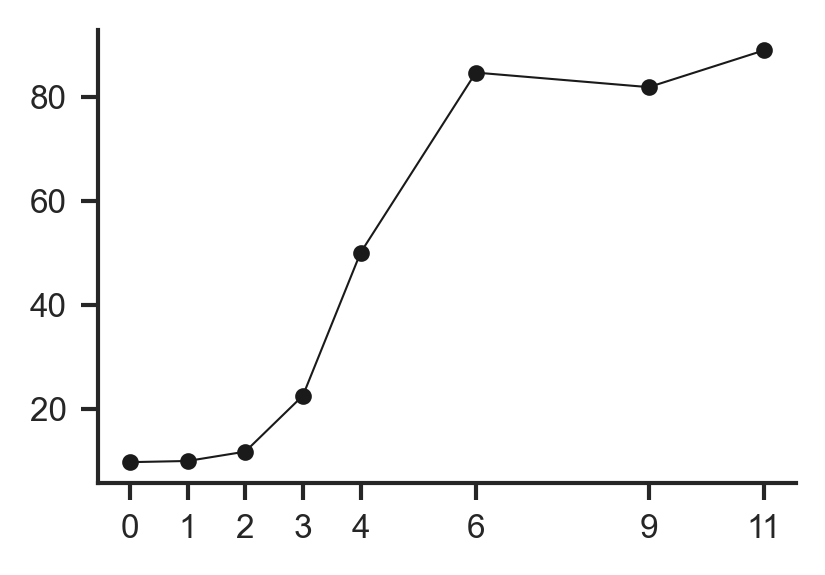

In [11]:
# From MSIsensor2
x,y=[],[]
for i in [0,1,2,3,4,6,9,11]:
    a=clinical[clinical['Number_of_Somatic_Sites']>= i]
    r=np.mean(a['MMR_mut']==1)*100
    print(i, r)
    x.append(i)
    y.append(r)
    
fig=plt.figure(figsize=(3,2))
ax=fig.add_subplot(111)
ax.plot(x,y,marker='.',c='k')

ax.set_xticks([0,1,2,3,4,6,9,11])

ax.tick_params(labelsize=8)
ax.spines['right' ].set_visible(False)
ax.spines['top' ].set_visible(False)

In [12]:
Counter(clinical['Total_Number_of_Sites'])

Counter({18.0: 694, 17.0: 12, nan: 1, nan: 1, nan: 1, nan: 1})

In [13]:
cat=[]
for idx in clinical.index: 
    if clinical.loc[idx,'POLE_mut']==1:
        cat.append('POLE_mut')
    elif clinical.loc[idx,'MSI_high']==1:
        cat.append('MSI_high') 
    else:
        cat.append('Others')
clinical['POLE_MSI']=cat

MannwhitneyuResult(statistic=152.0, pvalue=1.693222349307428e-08)

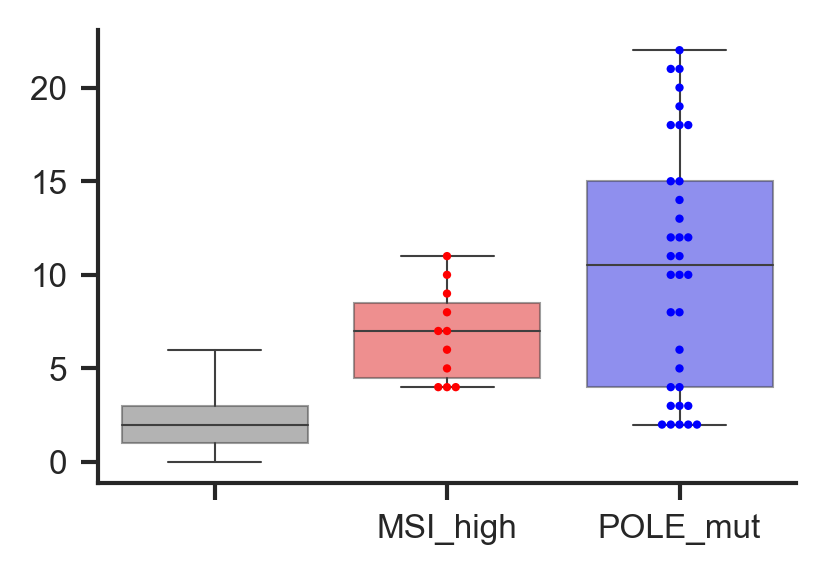

In [14]:
plt_df=clinical
cat='POLE_MSI'
val='TMB'
#plt_df=plt_df[plt_df[cat].isin(['HGSC','Endo_G3'])]
order=['Others','MSI_high','POLE_mut']
order2=[None,'MSI_high','POLE_mut']
#hue='MMR_mut'#cat='MMR_mut'
palette=['dimgrey','red','blue']
fig=plt.figure(figsize=(3,2))
ax=fig.add_subplot(1,1,1)
sns.boxplot(x=cat,y=val,data=plt_df,boxprops={'alpha':0.5},sym='',order=order,palette=palette)
sns.swarmplot(x=cat,y=val,data=plt_df,s=2,order=order2,palette=palette)
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(labelsize=8)

ax.spines['right' ].set_visible(False)
ax.spines['top' ].set_visible(False)

a=plt_df[plt_df[cat]==order[0]][val].values
b=plt_df[plt_df[cat]==order[1]][val].values
c=plt_df[plt_df[cat]==order[2]][val].values
stats.mannwhitneyu(a,b)

Best Threshold=7.0, F1-Score=0.667
Sensitivity=0.55
AUC: 0.6995205459728742


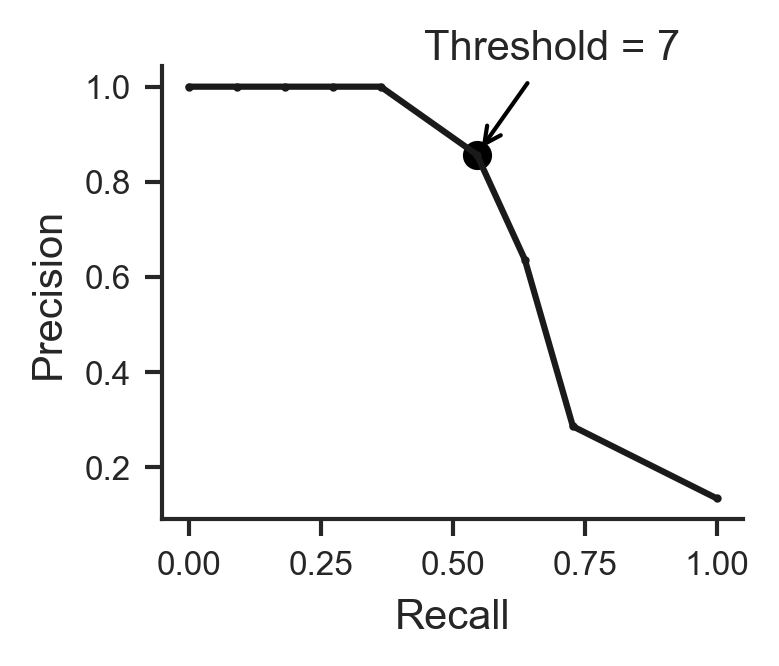

In [15]:
## TMB high cut-off
from sklearn.metrics import precision_recall_curve,auc,f1_score

flag="MSI_high"
value="TMB"
plt_df=clinical[clinical['POLE_mut']!=1]

# calculation
plt_df=plt_df.loc[:,[flag,value]].dropna()
y_true=plt_df[flag]
y_score=plt_df[value]
precision, recall, thresholds = precision_recall_curve(y_true, y_score)

# Optimal cutoff using best F1 score
f1score = (2 * precision * recall) / (precision + recall)
ix = np.argmax(f1score)
print('Best Threshold=%.1f, F1-Score=%.3f' % (thresholds[ix], f1score[ix]))
print('Sensitivity=%.2f' % (recall[ix]))
## precision = positive predictive value =TP/TP+FP
## recall = sensitivity = TP/TP+FN

# plot with Threshold
fig=plt.figure(figsize=(2.5,2))
ax=fig.add_subplot(111)
ax.plot(recall, precision, marker='o',ms=1,c='k',lw=1.5)
ax.scatter(recall[ix], precision[ix], marker='o', color='black')
arrow_dict = dict(color = "black",arrowstyle = "->",) #shrink=0.1,width=0,
ax.annotate("Threshold = {:.3g}".format(thresholds[ix]),
            xy=(recall[ix], precision[ix]),
            size=10,xytext=(recall[ix]-0.1, precision[ix]+0.2),arrowprops=arrow_dict )


ax.set_xlabel('Recall',fontsize=10)
ax.set_ylabel('Precision',fontsize=10)

ax.tick_params(labelsize=8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

auc_score = auc(recall, precision)
print('AUC:', auc_score)

In [16]:
clinical['TMB_high']=(clinical['TMB']>=7).astype(int)
Counter( clinical['TMB_high'])

Counter({0: 681, 1: 29})

# JGOG-TR2

In [17]:
clinical_esr=pd.read_csv('../data/JGOG_esr_289_clinical_genomic_info.txt'
                      ,sep='\t',index_col=0)
clinical_esr.shape

(289, 375)

In [18]:
clinical_esr['BRCA12_alt']=((clinical_esr['BRCA1_LOH']==1)|(clinical_esr['BRCA2_LOH']==1)|(clinical_esr['BRCA1_methylation_all']==1)).astype(int)

In [19]:
hrd_genes='ATM, ATR, ATRX, BAP1, BARD1, BLM, BRCA1, BRCA2, BRIP1, CHEK1, CHEK2, EMSY, FANCA, FANCC, FANCL, MLE11, NBN, PALB2, RAD21, RAD50, RAD51, RAD51B, RAD51C, RAD51D, RAD52, RAD54L, RECQL4, XRCC2'#POLD1
hrd_genes=set(hrd_genes.replace(' ','').split(','))
mmr_genes=set(['MLH1','MSH2','MSH6','PMS2'])
ov_genes=set(['TP53','ARID1A','PIK3CA','PTEN','KRAS'])

In [20]:
loh_genes=sorted(clinical_esr.columns[clinical_esr.columns.str.contains('_LOH')])
loh_genes

['ATM_LOH',
 'BAP1_LOH',
 'BARD1_LOH',
 'BLM_LOH',
 'BRCA1_LOH',
 'BRCA2_LOH',
 'BRIP1_LOH',
 'CHEK1_LOH',
 'CHEK2_LOH',
 'FANCA_LOH',
 'HRR_LOH',
 'RAD51C_LOH',
 'RAD51D_LOH',
 'RAD51_LOH']

In [21]:
clinical_esr['HRR_LOH']=(np.sum( clinical_esr[loh_genes],axis=1 )>=1).astype(int)

## clinical characteristics

In [22]:
pd.crosstab(clinical_esr['Stage'],clinical_esr['Histology'])

Histology  Endo_G3  HGSC
Stage                   
IIA              0     7
IIB              2    19
IIIA1(i)         1     6
IIIA1(ii)        0     9
IIIA2            1     4
IIIB             0    32
IIIC             4   138
IVA              1    11
IVB              6    42
Unknown          0     6

In [23]:
pd.crosstab(clinical_esr['PS'].fillna('NA'),clinical_esr['Histology'].fillna('NA'))

Histology  Endo_G3  HGSC
PS                      
0.0             12   202
1.0              2    48
2.0              0    15
3.0              0     1
NA               1     8

In [24]:
pd.crosstab(clinical_esr['R0'].fillna('NA'),clinical_esr['Histology'].fillna('NA'))

Histology  Endo_G3  HGSC
R0                      
0                5   113
1               10   161

In [25]:
pd.crosstab(clinical_esr['Optimal'].fillna('NA'),clinical_esr['Histology'].fillna('NA'))

Histology  Endo_G3  HGSC
Optimal                 
0                2    69
1               13   205

In [26]:
pd.crosstab(clinical_esr['Surgery'].fillna('NA'),clinical_esr['Histology'].fillna('NA'))

Histology  Endo_G3  HGSC
Surgery                 
IDS              4   114
NA               0     2
NonDS            2    32
PDS              9   126

In [27]:
clinical_esr.groupby('Histology').describe()['AGE']

count       mean        std   min   25%   50%   75%   max
Histology                                                           
Endo_G3     15.0  58.200000  12.745868  31.0  53.0  59.0  68.0  73.0
HGSC       274.0  61.222628  11.409690  28.0  54.0  61.5  69.0  89.0

In [28]:
clinical_esr.groupby('Histology').describe()['OS']

count         mean         std    min     25%     50%      75%  \
Histology                                                                   
Endo_G3     15.0  1151.333333  360.844182  401.0  914.50  1310.0  1398.50   
HGSC       274.0  1021.620438  321.416397   56.0  932.25  1072.0  1229.25   

              max  
Histology          
Endo_G3    1605.0  
HGSC       1639.0

In [29]:
pd.crosstab( clinical_esr['Histology'], clinical_esr['initial_diagnosis'])

initial_diagnosis  HGEC  HGSC  Others
Histology                            
Endo_G3               6     6       3
HGSC                 10   258       6

In [30]:
clinical_esr['HGEC']=(clinical_esr['Histology']=='Endo_G3').astype(int)
clinical_esr['HGSC']=(clinical_esr['Histology']=='HGSC').astype(int)

## Mutation plot

In [31]:
vc_table_esr=pd.read_csv('../data/JGOG_esr_289_variant_types.txt',sep='\t',index_col=0).T
vc_table_esr

R0001              R0003 R0004              R0006  \
ARID1A                     None               None  None               None   
ARID1B                     None               None  None               None   
ATM                        None               None  None               None   
BAP1                       None               None  None               None   
BARD1                      None               None  None               None   
BIVM-ERCC5                 None               None  None               None   
BLM                        None               None  None               None   
BRCA1       Frameshift deletion               None  None               None   
BRCA2                      None               None  None               None   
BRIP1                      None               None  None               None   
CHEK1                      None               None  None               None   
CHEK2                      None               None  None               None   
CTCF                       None               None  None               None   
ERCC2                      None               None  None               None   
ERCC3                      None               None  None               None   
ERCC4                      None               None  None               None   
FANCA                      None               None  None               None   
KRAS                       None               None  None               None   
MED12                      None               None  None               None   
MLH1                       None               None  None               None   
MRE11                      None               None  None               None   
MSH2                       None               None  None               None   
MSH6                       None               None  None               None   
MUTYH                      None               None  None               None   
PIK3CA                     None               None  None               None   
PMS1                       None               None  None               None   
PMS2                       None               None  None               None   
POLD1                      None               None  None               None   
POLE                       None               None  None               None   
PTEN                       None               None  None               None   
RAD51                      None               None  None               None   
RAD51C                     None               None  None               None   
RAD51D                     None  Nonsense mutation  None               None   
SMARCA4                    None               None  None               None   
SMARCB1                    None               None  None               None   
TP53          Missense mutation  Missense mutation  None  Missense mutation   

                          R0011              R0012              R0013  \
ARID1A                     None               None               None   
ARID1B                     None               None               None   
ATM                        None               None               None   
BAP1                       None               None               None   
BARD1                      None               None               None   
BIVM-ERCC5                 None               None               None   
BLM                        None               None               None   
BRCA1       Frameshift deletion               None               None   
BRCA2                      None               None  Nonsense mutation   
BRIP1         Missense mutation               None               None   
CHEK1                      None               None               None   
CHEK2                      None               None               None   
CTCF                       None               None               None   
ERCC2                      None               None               None   
ERCC3  

In [32]:
vc_table_esr_int=vc_table_esr.replace({'multiple hit':0,
        'Nonsense mutation': 1,
         'Frameshift deletion': 2,
         'Frameshift insertion': 2,
        'Missense mutation': 3,
         'Splice site':4,
             'Others':5,
             "None":8 })

In [33]:
clinical_esr_e=clinical_esr[clinical_esr['HGEC']==1]
clinical_esr_s=clinical_esr[clinical_esr['HGSC']==1]

In [34]:
a=np.sum(vc_table_esr_int!=8,axis=1).sort_values(ascending=False)
col_order=list(a.index)
col_order

['TP53',
 'BRCA1',
 'BRCA2',
 'ARID1A',
 'BIVM-ERCC5',
 'MED12',
 'PIK3CA',
 'PTEN',
 'ERCC2',
 'RAD51',
 'MSH2',
 'MSH6',
 'KRAS',
 'POLE',
 'CTCF',
 'ERCC3',
 'RAD51D',
 'SMARCA4',
 'POLD1',
 'FANCA',
 'CHEK2',
 'ARID1B',
 'MLH1',
 'BRIP1',
 'ATM',
 'BAP1',
 'PMS1',
 'RAD51C',
 'SMARCB1',
 'MRE11',
 'ERCC4',
 'PMS2',
 'MUTYH',
 'CHEK1',
 'BLM',
 'BARD1']

In [35]:
col_order_r=[
 'TP53',
 'BRCA1',
 'BRCA2',
 'ARID1A',
 'PTEN',
 'PIK3CA',
 'KRAS',
    
 'RAD51',
 'RAD51D',
 'FANCA',
 'CHEK2',
 'BRIP1',
 'ATM',
 'RAD51C',
 'BAP1',
 'MRE11',
 'BLM',
 'BARD1',
 'CHEK1',
   
 'MSH2',
 'MSH6',
 'MLH1',
 'PMS2',
    
 'POLE',
 'POLD1',
    
 'BIVM-ERCC5',
 'MED12',
 'ERCC2',
 'CTCF',
 'ERCC3',    
 'SMARCA4',
 'ARID1B',
 'PMS1',
 'SMARCB1',
 'ERCC4',
 'MUTYH'
]

In [36]:
for gene in col_order_r:
    print(gene)

TP53
BRCA1
BRCA2
ARID1A
PTEN
PIK3CA
KRAS
RAD51
RAD51D
FANCA
CHEK2
BRIP1
ATM
RAD51C
BAP1
MRE11
BLM
BARD1
CHEK1
MSH2
MSH6
MLH1
PMS2
POLE
POLD1
BIVM-ERCC5
MED12
ERCC2
CTCF
ERCC3
SMARCA4
ARID1B
PMS1
SMARCB1
ERCC4
MUTYH


In [37]:
vc_table_esr_int_order=vc_table_esr_int.loc[col_order_r,:]
vc_table_esr_int_order

R0001  R0003  R0004  R0006  R0011  R0012  R0013  R0016  R0020  \
TP53            3      3      8      3      8      3      1      1      2   
BRCA1           2      8      8      8      2      8      8      8      8   
BRCA2           8      8      8      8      8      8      1      8      8   
ARID1A          8      8      8      8      8      8      8      8      8   
PTEN            8      8      8      8      8      8      8      8      8   
PIK3CA          8      8      8      8      8      8      8      8      8   
KRAS            8      8      8      8      8      8      8      8      8   
RAD51           8      8      8      8      8      8      8      8      8   
RAD51D          8      1      8      8      8      8      8      8      8   
FANCA           8      8      8      8      8      8      8      8      8   
CHEK2           8      8      8      8      8      8      8      8      8   
BRIP1           8      8      8      8      3      8      8      8      8   
ATM             8      8      8      8      8      8      8      8      8   
RAD51C          8      8      8      8      8      8      8      8      8   
BAP1            8      8      8      8      8      8      8      8      8   
MRE11           8      8      8      8      8      8      8      8      8   
BLM             8      8      8      8      8      8      8      8      8   
BARD1           8      8      8      8      8      8      8      8      8   
CHEK1           8      8      8      8      8      8      8      8      8   
MSH2            8      8      8      8      8      8      8      3      8   
MSH6            8      8      8      8      8      8      8      8      8   
MLH1            8      8      8      8      8      8      8      8      8   
PMS2            8      8      8      8      8      8      8      8      8   
POLE            8      8      8      8      8      8      8      8      8   
POLD1           8      8      8      8      8      8      8      8      8   
BIVM-ERCC5      8      8      8      8      8      8      8      8      3   
MED12           8      8      8      8      8      8      8      8      8   
ERCC2           8      8      8      8      8      8      8      8      8   
CTCF            8      8      8      8      8      8      8      8      8   
ERCC3           8      8      8      8      8      8      8      3      8   
SMARCA4         8      8      8      8      8      8      8      8      8   
ARID1B          8      8      8      8      8      8      8      8      8   
PMS1            8      8      8      8      8      8      8      8      8   
SMARCB1         8      8      8      8      8      8      8      8      8   
ERCC4           8      8      8      8      8      8      8      8      8   
MUTYH           8      8      8      8      3      8      8      8      8   

            R0024  R0026  R0029  R0030  R0032  R0033  R0037  R0038  R0041  \
TP53            3      3      3      3      4      3      3      5      3   
BRCA1           2      8      8      8      8      8      8      8      8   
BRCA2           8      8      8      8      8      8      8      8      8   
ARID1A          8      8      8      8      8      8      8      8      8   
PTEN            8      8      8      8      8      8      8      8      8   
PIK3CA          8      8      8      8      8      8      8      8      8   
KRAS            8      8      8      8      8      8      8      8      8   
RAD51           8      8      8      8      5      8      8      8      8   
RAD51D          8      8      8      8      8      8      8      8      8   
FANCA           8      8      8      8      8      8      8      8      8   
CHEK2           8      8      8      8      8      8      8      8      8   
BRIP1           8      8      8      8      8      8      8      8      8   
ATM             8      8      8      8      8      8      8      8      8   
RAD51C          8      8      8      8      8      8      8      8      8   
BAP1   

In [38]:
in_df=vc_table_esr_int_order.loc[:,clinical_esr_e.index].T
sns_df1=in_df.sort_values(col_order_r).T

In [39]:
in_df=vc_table_esr_int_order.loc[:,clinical_esr_s.index].T
sns_df2=in_df.sort_values(col_order_r).T

In [40]:
cmap1=generate_cmap(['black','tab:red','tab:blue','tab:green','tab:orange',
                     'dimgrey','grey','grey','lightgrey'])

TP53
BRCA1
BRCA2
ARID1A
PTEN
PIK3CA
KRAS
RAD51
RAD51D
FANCA
CHEK2
BRIP1
ATM
RAD51C
BAP1
MRE11
BLM
BARD1
CHEK1
MSH2
MSH6
MLH1
PMS2
POLE
POLD1
BIVM-ERCC5
MED12
ERCC2
CTCF
ERCC3
SMARCA4
ARID1B
PMS1
SMARCB1
ERCC4
MUTYH


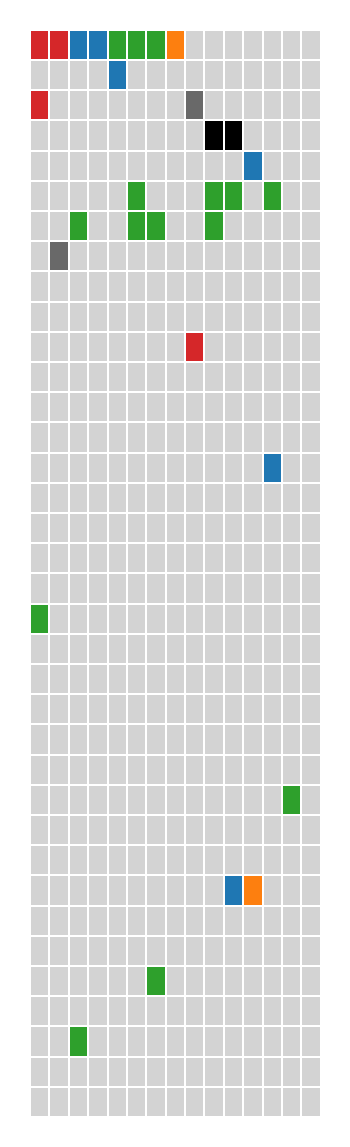

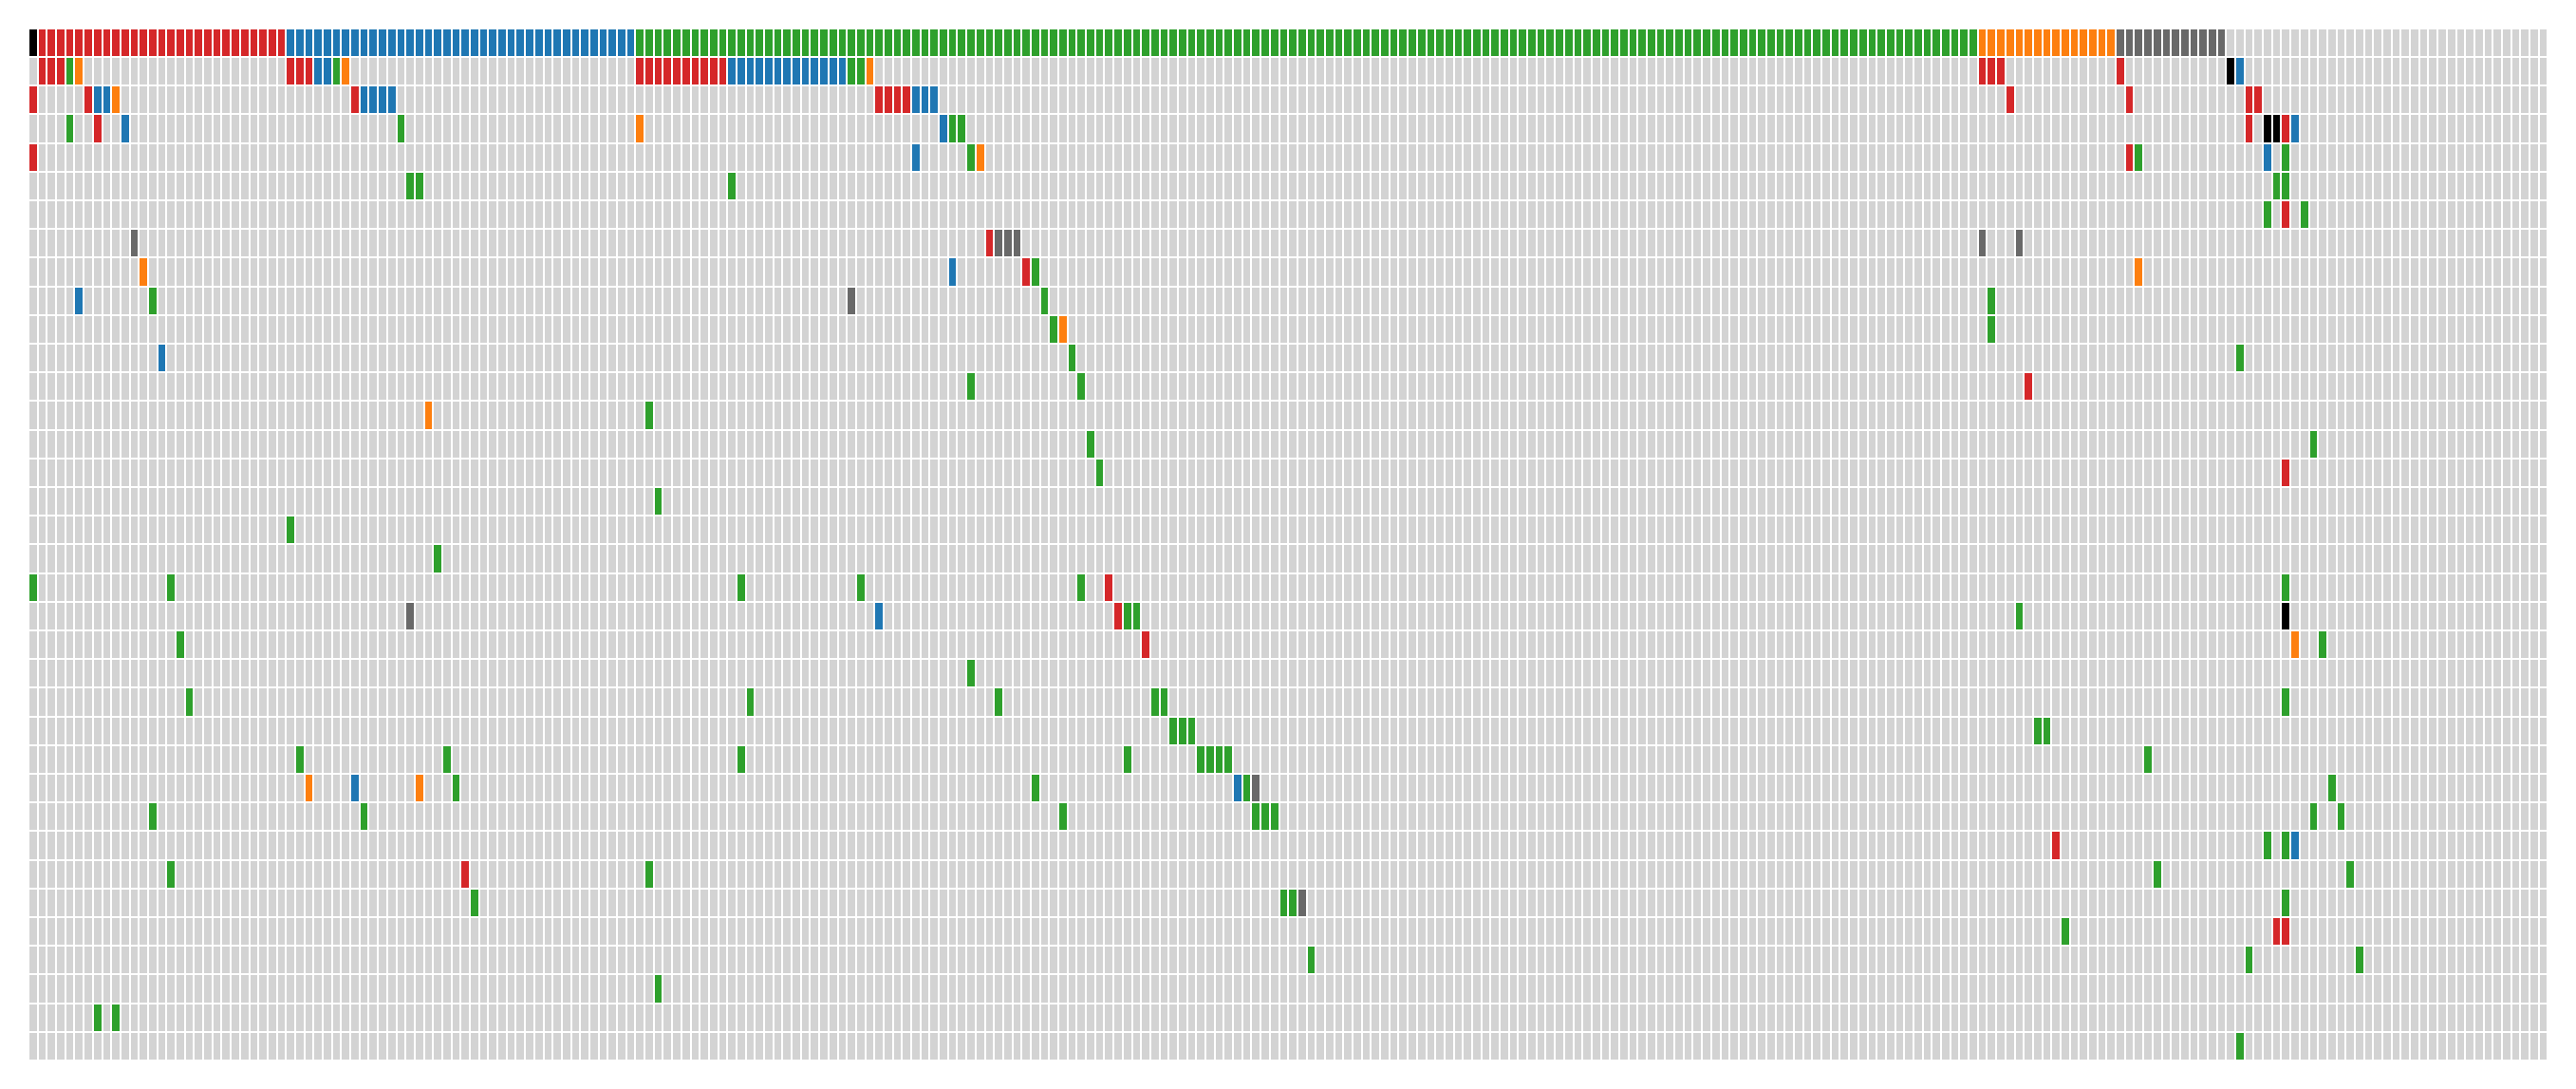

In [41]:
n=sns_df1.shape[0]
m=sns_df1.shape[1]
fig=plt.figure(figsize=(m/12,n/7.5))
ax=fig.add_subplot(111)
sns.heatmap(sns_df1,cmap=cmap1,ax=ax,cbar=False,xticklabels=0,yticklabels=0,linecolor='w',linewidths=0.1)
ax.set_xlabel('')

n=sns_df2.shape[0]
m=sns_df2.shape[1]
fig=plt.figure(figsize=(m/24,n/7.5))
ax=fig.add_subplot(111)
sns.heatmap(sns_df2,cmap=cmap1,ax=ax,cbar=False,xticklabels=0,yticklabels=0,linecolor='w',linewidths=0.01)
ax.set_xlabel('')

for gene in col_order_r:
    print(gene.split('_')[0])

In [42]:
for i in np.round(np.mean(sns_df1!=8,axis=1)*100,1).values:
    print(i)

53.3
6.7
13.3
13.3
6.7
26.7
26.7
6.7
0.0
0.0
6.7
0.0
0.0
0.0
6.7
0.0
0.0
0.0
0.0
6.7
0.0
0.0
0.0
0.0
0.0
6.7
0.0
0.0
13.3
0.0
0.0
6.7
0.0
6.7
0.0
0.0


In [43]:
for i in np.round(np.mean(sns_df2!=8,axis=1)*100,1).values:
    print(i)

87.2
16.1
7.7
4.7
2.9
1.8
1.1
2.6
1.8
1.8
1.1
1.1
1.1
0.7
0.7
0.7
0.4
0.4
0.4
2.6
2.6
1.5
0.4
2.2
1.8
3.3
3.3
2.9
1.5
1.8
1.8
1.1
1.1
0.4
0.7
0.4


Text(411.4583333333333, 0.5, '')

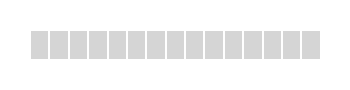

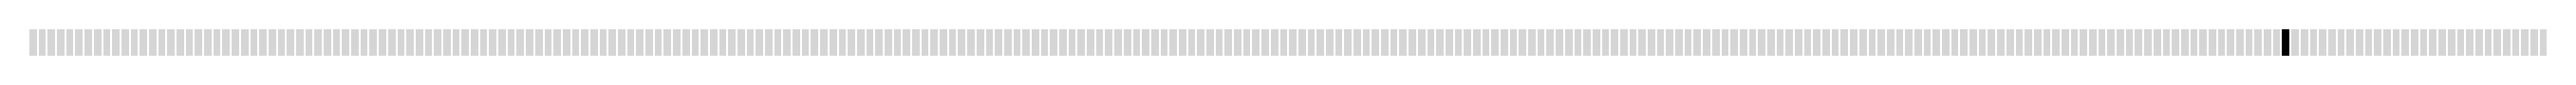

In [44]:
cat='TMB_high'

in_df=clinical_esr_e.loc[sns_df1.columns,[cat]].T
n=in_df.shape[0]
m=in_df.shape[1]

fig=plt.figure(figsize=(m/12,n/7.5))
ax=fig.add_subplot(111)
sns.heatmap(in_df,cmap=wk,ax=ax,cbar=False,vmin=-0.2,vmax=1,xticklabels=0,yticklabels=0,linecolor='w',linewidths=0.1)
ax.set_xlabel('')
ax.set_ylabel('')

in_df2=clinical_esr_s.loc[sns_df2.columns,[cat]].T

n=in_df2.shape[0]
m=in_df2.shape[1]

fig=plt.figure(figsize=(m/24,n/7.5))
ax=fig.add_subplot(111)
sns.heatmap(in_df2,cmap=wk,ax=ax,cbar=False,vmin=-0.2,xticklabels=0,yticklabels=0,linecolor='w',linewidths=0.03)
ax.set_xlabel('')
ax.set_ylabel('')

Text(411.4583333333333, 0.5, '')

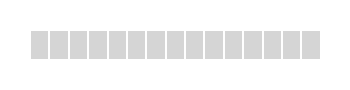

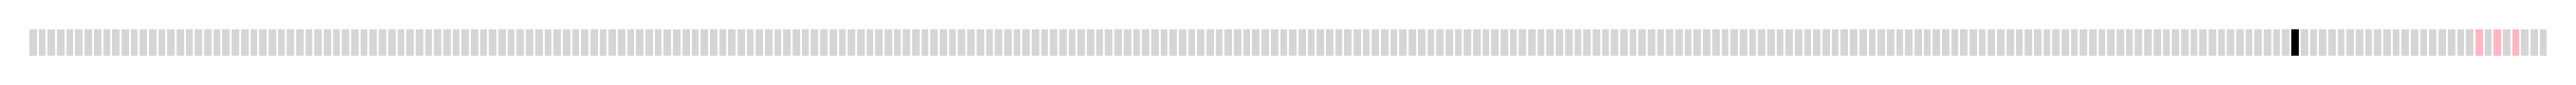

In [45]:
cat='MSI_high'

in_df=clinical_esr_e.loc[sns_df1.columns,[cat]].T
n=in_df.shape[0]
m=in_df.shape[1]

fig=plt.figure(figsize=(m/12,n/7.5))
ax=fig.add_subplot(111)
sns.heatmap(in_df,cmap=wk,ax=ax,cbar=False,vmin=-0.2,vmax=1,xticklabels=0,yticklabels=0,linecolor='w',linewidths=0.1)
ax.set_xlabel('')
ax.set_ylabel('')

in_df2=clinical_esr_s.loc[sns_df2.columns,[cat]].T

n=in_df2.shape[0]
m=in_df2.shape[1]

fig=plt.figure(figsize=(m/24,n/7.5))
ax=fig.add_subplot(111)
sns.heatmap(in_df2,cmap=wk,ax=ax,cbar=False,vmin=-0.2,xticklabels=0,yticklabels=0,linecolor='w',linewidths=0.03)
ax.set_xlabel('')
ax.set_ylabel('')


In [46]:
pd.crosstab(clinical_esr['MMR_mut'],clinical_esr['Histology'])[['HGSC','Endo_G3']]

Histology  HGSC  Endo_G3
MMR_mut                 
0           256       14
1            18        1

In [47]:
pd.crosstab(clinical_esr['POLE_mut'],clinical_esr['Histology'])[['HGSC','Endo_G3']]


Histology  HGSC  Endo_G3
POLE_mut                
0           268       15
1             6        0

In [48]:
pd.crosstab(clinical_esr['TP53_mut'],clinical_esr['Histology'])[['HGSC','Endo_G3']]


Histology  HGSC  Endo_G3
TP53_mut                
0            35        7
1           239        8

In [49]:
pd.crosstab(clinical_esr['PIK3CA_mut'],clinical_esr['Histology'])[['HGSC','Endo_G3']]


Histology   HGSC  Endo_G3
PIK3CA_mut               
0            269       11
1              5        4

In [50]:
pd.crosstab(clinical_esr['ARID1A_mut'],clinical_esr['Histology'])[['HGSC','Endo_G3']]


Histology   HGSC  Endo_G3
ARID1A_mut               
0            261       13
1             13        2

In [51]:
pd.crosstab(clinical_esr['PTEN_mut'],clinical_esr['Histology'])[['HGSC','Endo_G3']]


Histology  HGSC  Endo_G3
PTEN_mut                
0           266       14
1             8        1

In [52]:
pd.crosstab(clinical_esr['BRCA1_LOH'],clinical_esr['Histology'])[['HGSC','Endo_G3']]


Histology  HGSC  Endo_G3
BRCA1_LOH               
0           230       14
1            44        1

In [53]:
pd.crosstab(clinical_esr['BRCA2_LOH'],clinical_esr['Histology'])[['HGSC','Endo_G3']]


Histology  HGSC  Endo_G3
BRCA2_LOH               
0           253       13
1            21        2

In [54]:
clinical_esr['BRCA12_alt'].sum()

97

## Genomic features

In [55]:
from statsmodels.stats.diagnostic import kstest_normal

MW test p= 0.028579913887488647


Text(0.5, 1.0, 'HRD score')

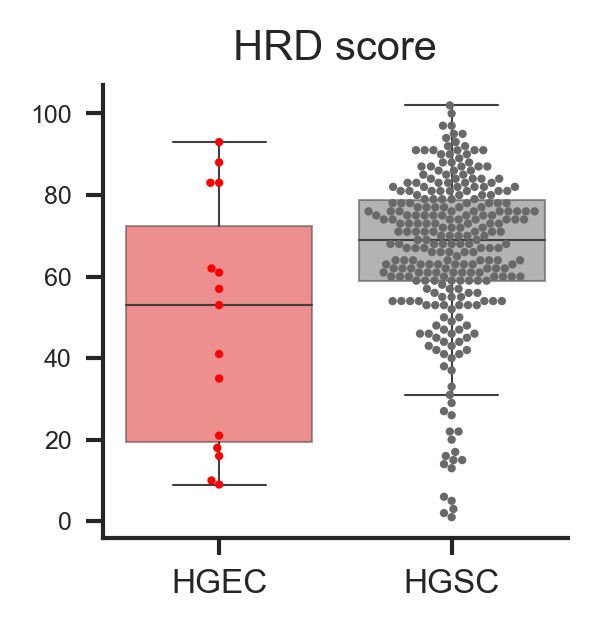

In [56]:
plt_df=clinical_esr
cat='HGSC'
val='HRD_score'
#order=[]
hue='TP53_mut'
palette=['red','dimgrey']
fig=plt.figure(figsize=(2,2))
ax=fig.add_subplot(1,1,1)
sns.boxplot(x=cat,y=val,data=plt_df,boxprops={'alpha':0.5},sym='',palette=palette)#,order=orderpalette=palette)
sns.swarmplot(x=cat,y=val,data=plt_df,s=2,palette=palette)#,order=order,hue=hue,dodge=True,palette=palette)

a=plt_df[plt_df[cat]==1][val].dropna()
b=plt_df[plt_df[cat]==0][val].dropna()

_,p1=kstest_normal(a)
_,p2=kstest_normal(b)
if (p1>0.05)&(p2>0.05):
    _,p=stats.ttest_ind(a,b,nan_policy='omit')
    print("T-test p=",p)
else:
    _,p=stats.mannwhitneyu(a,b)
    print('MW test p=',p)

ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(labelsize=6)
ax.set_xticklabels(['HGEC','HGSC'],fontsize=8)
ax.spines['right' ].set_visible(False)
ax.spines['top' ].set_visible(False)
ax.set_title('HRD score',fontsize=10)


MW test p= 0.00015863866610673505


Text(0.5, 1.0, 'Aneuploidy')

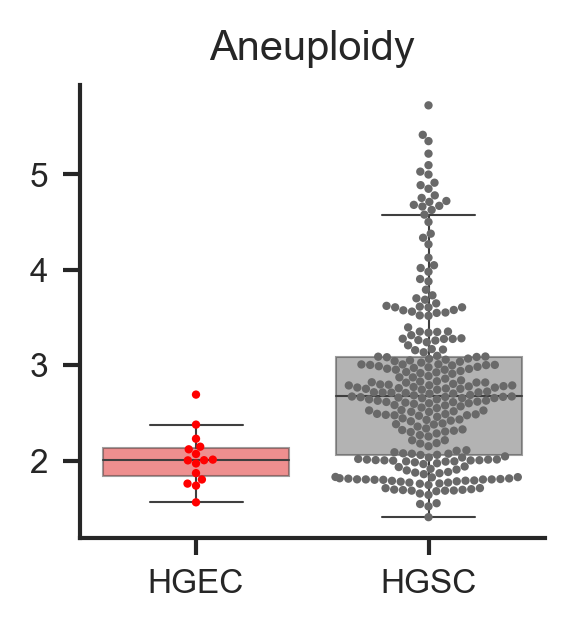

In [57]:
plt_df=clinical_esr
cat='HGSC'
val='ploidy'
#order=[]
#hue='TP53_mut'
palette=['red','dimgrey']
fig=plt.figure(figsize=(2,2))
ax=fig.add_subplot(1,1,1)
sns.boxplot(x=cat,y=val,data=plt_df,boxprops={'alpha':0.5},sym='',palette=palette)#,order=order)
sns.swarmplot(x=cat,y=val,data=plt_df,s=2,palette=palette)#,order=order,hue=hue,dodge=True,palette=palette)

a=plt_df[plt_df[cat]==1][val].dropna()
b=plt_df[plt_df[cat]==0][val].dropna()

_,p1=kstest_normal(a)
_,p2=kstest_normal(b)

if (p1>0.05)&(p2>0.05):
    _,p=stats.ttest_ind(a,b,nan_policy='omit')
    print("T-test p=",p)
else:
    _,p=stats.mannwhitneyu(a,b)
    print('MW test p=',p)

ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(labelsize=8)
ax.set_xticklabels(['HGEC','HGSC'],fontsize=8)
ax.spines['right' ].set_visible(False)
ax.spines['top' ].set_visible(False)
ax.set_title('Aneuploidy', fontsize=10)

MW test p= 5.466760786130907e-05


Text(0.5, 1.0, 'MATH score')

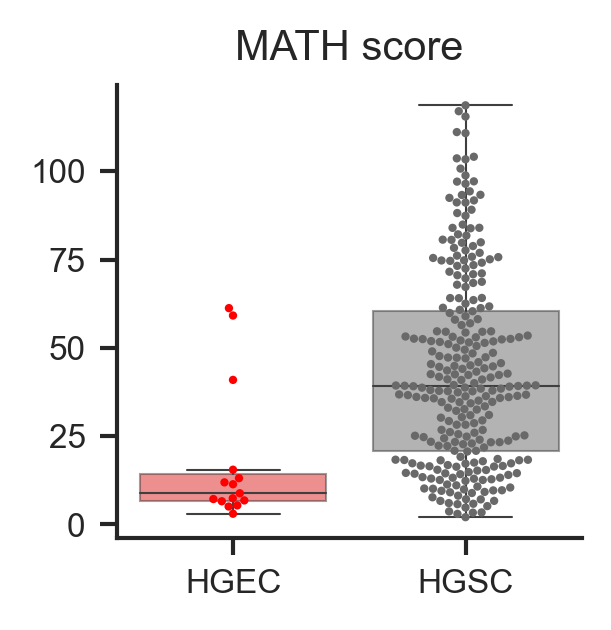

In [58]:
plt_df=clinical_esr
cat='HGSC'
val='MATH'
#order=[]
hue='TP53_mut'
palette=['red','dimgrey']
fig=plt.figure(figsize=(2,2))
ax=fig.add_subplot(1,1,1)
sns.boxplot(x=cat,y=val,data=plt_df,boxprops={'alpha':0.5},sym='',palette=palette)#,order=order)
sns.swarmplot(x=cat,y=val,data=plt_df,s=2,palette=palette)#,order=order,hue=hue,dodge=True,palette=palette)

a=plt_df[plt_df[cat]==1][val].dropna()
b=plt_df[plt_df[cat]==0][val].dropna()

_,p1=kstest_normal(a)
_,p2=kstest_normal(b)

if (p1>0.05)&(p2>0.05):
    _,p=stats.ttest_ind(a,b,nan_policy='omit')
    print("T-test p=",p)
else:
    _,p=stats.mannwhitneyu(a,b)
    print('MW test p=',p)
    
ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(labelsize=8)
ax.set_xticklabels(['HGEC','HGSC'],fontsize=8)
ax.spines['right' ].set_visible(False)
ax.spines['top' ].set_visible(False)
ax.set_title('MATH score', fontsize=10)

MW test p= 0.00031080376055845195


Text(0.5, 1.0, 'WT1 expression')

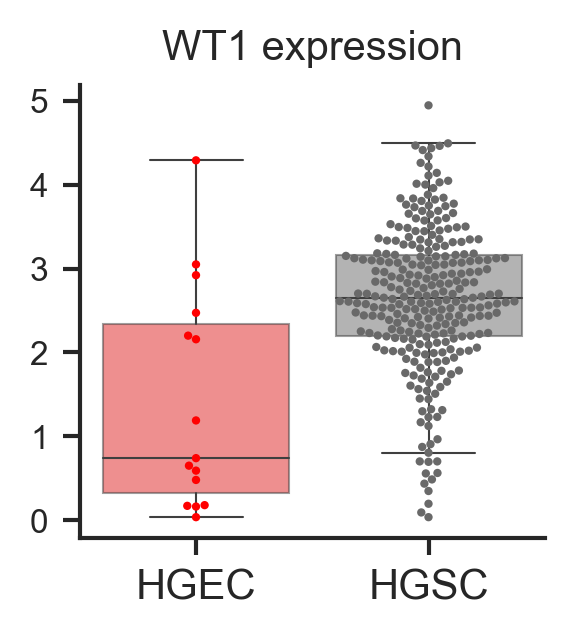

In [59]:
## WT1 exp
plt_df=clinical_esr
cat='HGSC'
val='WT1_log'
#order=[]
hue='TP53_mut'
palette=['red','dimgrey',]
fig=plt.figure(figsize=(2,2))
ax=fig.add_subplot(1,1,1)
sns.boxplot(x=cat,y=val,data=plt_df,boxprops={'alpha':0.5},sym='',palette=palette)#,order=order)
sns.swarmplot(x=cat,y=val,data=plt_df,s=2,palette=palette)#,order=order,hue=hue,dodge=True,palette=palette)

a=plt_df[plt_df[cat]==1][val].dropna()
b=plt_df[plt_df[cat]==0][val].dropna()

_,p1=kstest_normal(a)
_,p2=kstest_normal(b)

if (p1>0.05)&(p2>0.05):
    _,p=stats.ttest_ind(a,b,nan_policy='omit')
    print("T-test p=",p)
else:
    _,p=stats.mannwhitneyu(a,b)
    print('MW test p=',p)

ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(labelsize=8)
ax.set_xticklabels(['HGEC','HGSC'],fontsize=10)
ax.spines['right' ].set_visible(False)
ax.spines['top' ].set_visible(False)
ax.set_title('WT1 expression', fontsize=10)

## CNV signatures

### Hierarchical clustering

In [60]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cophenet, set_link_color_palette, cut_tree
from scipy.spatial.distance import pdist

In [61]:
cnv=pd.read_csv('../data/JGOG_282_ascat_spmg.CNV48.matrix.txt'
                ,sep='\t',index_col=0)
cnv_r=cnv.apply(lambda x: x/np.sum(x),axis=1)
np.sum(cnv)

0:homdel:0-100kb        182
0:homdel:100kb-1Mb      995
0:homdel:>1Mb          1792
1:LOH:0-100kb           376
1:LOH:100kb-1Mb        2579
1:LOH:1Mb-10Mb         6567
1:LOH:10Mb-40Mb        4167
1:LOH:>40Mb             781
2:LOH:0-100kb           385
2:LOH:100kb-1Mb        3430
2:LOH:1Mb-10Mb         5748
2:LOH:10Mb-40Mb        1242
2:LOH:>40Mb             138
3-4:LOH:0-100kb         423
3-4:LOH:100kb-1Mb      2574
3-4:LOH:1Mb-10Mb       3482
3-4:LOH:10Mb-40Mb       740
3-4:LOH:>40Mb            55
5-8:LOH:0-100kb         142
5-8:LOH:100kb-1Mb       657
5-8:LOH:1Mb-10Mb        735
5-8:LOH:10Mb-40Mb       111
5-8:LOH:>40Mb             3
9+:LOH:0-100kb           34
9+:LOH:100kb-1Mb        139
9+:LOH:1Mb-10Mb          45
9+:LOH:10Mb-40Mb          1
9+:LOH:>40Mb              0
2:het:0-100kb           168
2:het:100kb-1Mb        2524
2:het:1Mb-10Mb         6385
2:het:10Mb-40Mb        3392
2:het:>40Mb            1136
3-4:het:0-100kb         595
3-4:het:100kb-1Mb      4935
3-4:het:1Mb-10Mb    

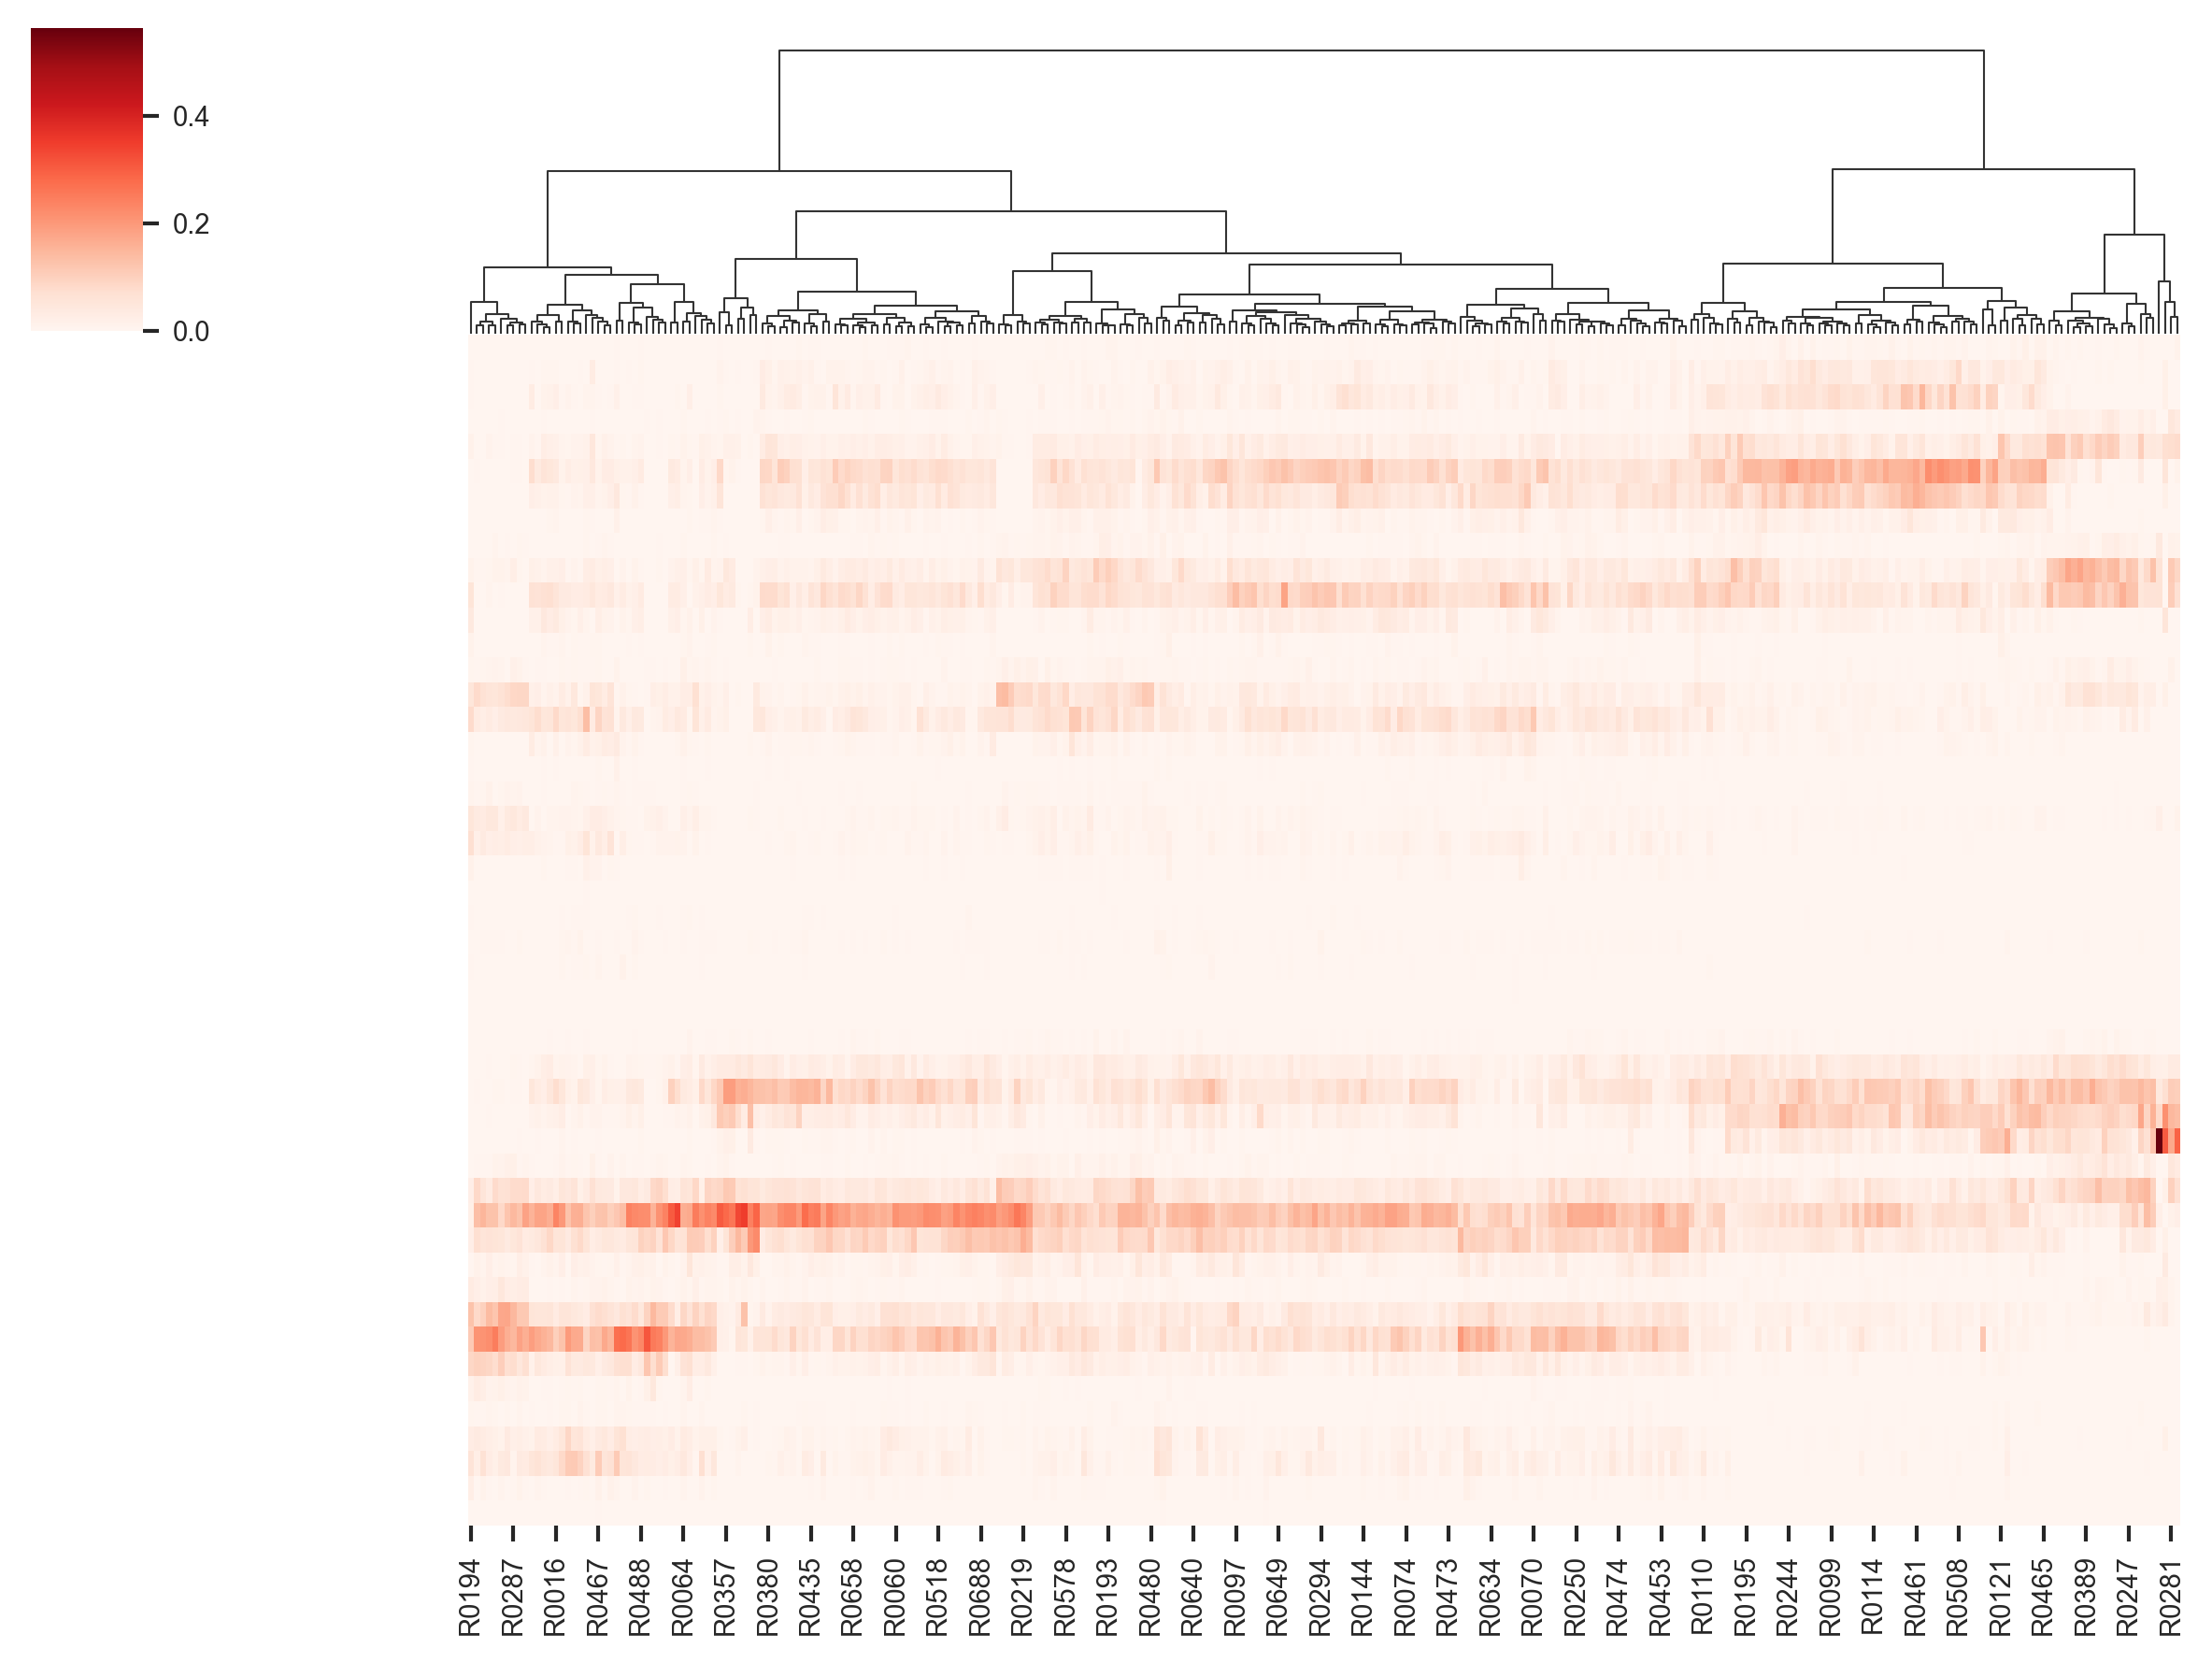

In [62]:
sns_df=cnv_r.T
g=sns.clustermap(sns_df,figsize=(8,6),row_cluster=False,
                 method='ward',metric='euclidean',yticklabels=0,cmap='Reds')

In [63]:
order=g.data2d.columns
clinical_order=clinical_esr.reindex(order)
clinical_order.shape

(282, 375)

Text(208.33333333333334, 0.5, '')

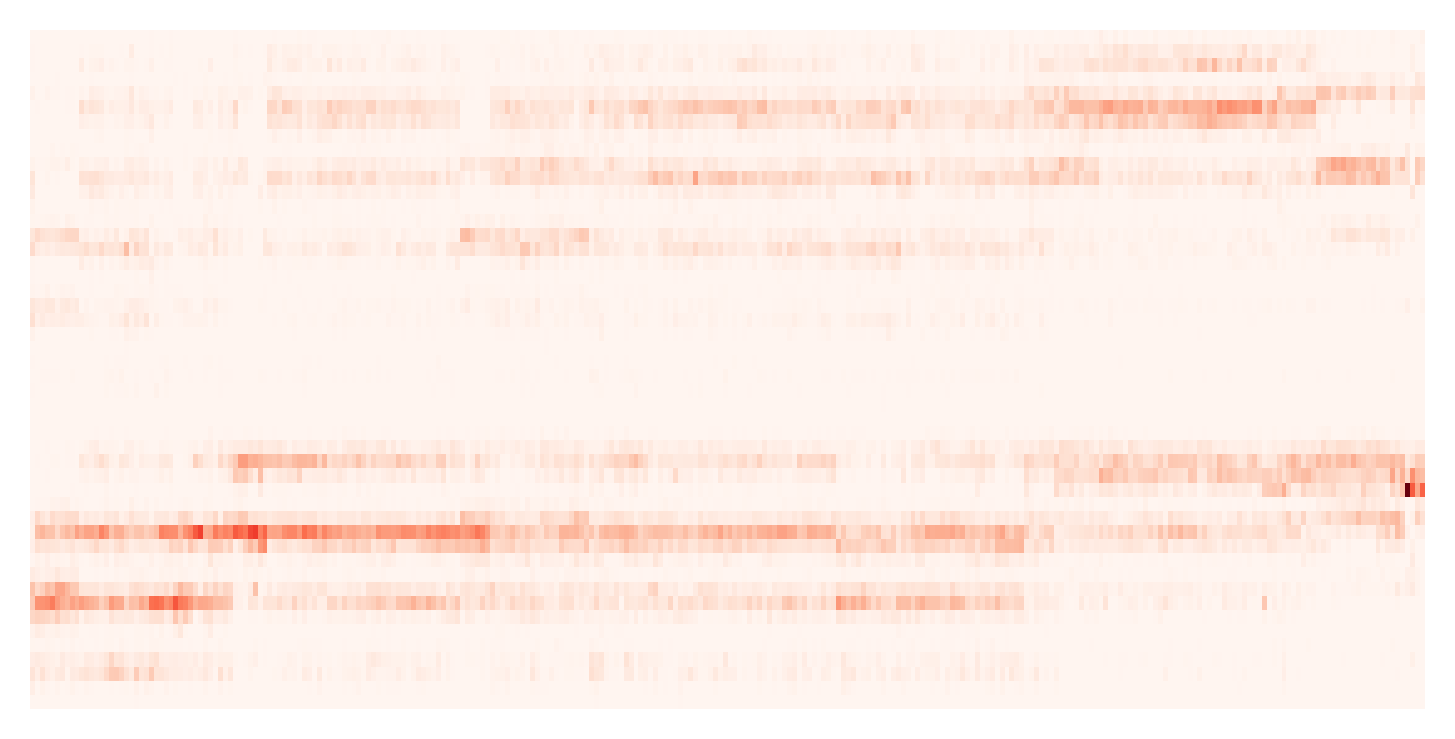

In [64]:
fig=plt.figure(figsize=(6,3))
ax=fig.add_subplot(111)
sns.heatmap(g.data2d,cmap='Reds',cbar=False,yticklabels=0,xticklabels=0,ax=ax)
ax.tick_params(labelsize=6)
ax.set_ylabel('')

In [65]:
sns_df=cnv_r.T
Z = linkage(sns_df.T, method='ward', metric='euclidean')

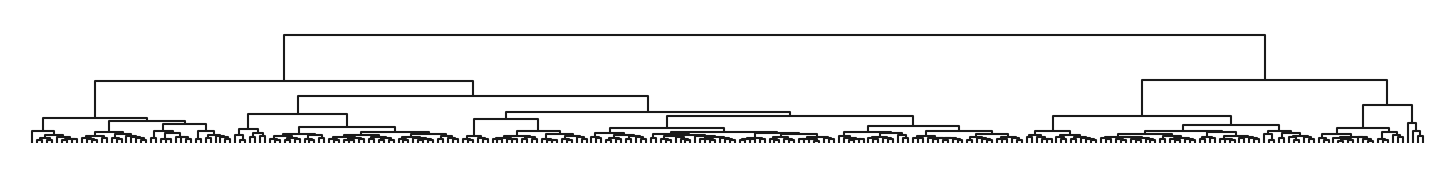

In [66]:
fig=plt.figure( figsize=(6, 0.5),facecolor='w')
ax = fig.add_subplot(1,1,1)
d=dendrogram(Z,ax=ax,no_labels=True,color_threshold=0, above_threshold_color='k')
ax.set_axis_off()

In [67]:
cuttree = cut_tree(Z, n_clusters=np.arange(2,10))
cuttree[:,2]

array([0, 1, 1, 0, 0, 0, 1, 2, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 3, 1,
       0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 0, 1, 0, 2, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 2, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 3,
       1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 0, 1, 1, 2, 1, 3, 0, 2,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 3, 2, 1, 0, 1, 0,
       2, 2, 1, 2, 1, 3, 1, 0, 3, 3, 1, 2, 2, 0, 1, 1, 1, 2, 0, 3, 2, 1,
       0, 1, 2, 0, 1, 1, 2, 2, 1, 0, 1, 1, 1, 1, 1, 0, 3, 1, 1, 1, 1, 2,
       1, 0, 2, 1, 1, 1, 0, 1, 2, 3, 0, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1,
       0, 1, 3, 2, 3, 1, 1, 1, 1, 1, 3, 1, 0, 1, 1, 3, 0, 1, 0, 2, 0, 1,
       2, 2, 3, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 1, 1, 3, 0, 0, 0, 1, 0, 1,
       2, 1, 0, 2, 1, 1, 3, 1, 1, 1, 1, 0, 1, 2, 3, 1, 1, 1, 1, 3, 1, 2,
       1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 3, 2, 1, 2, 1, 1, 1, 1, 1, 2, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 2, 2, 1, 1])

In [68]:
clinical_order=clinical_esr.loc[sns_df.columns,:]
for k in np.arange(2,10):
    clinical_order["cluster_"+str(k)]=cuttree[:,k-2]

In [69]:
clinical_order=clinical_order.iloc[d['leaves'],:]

[]

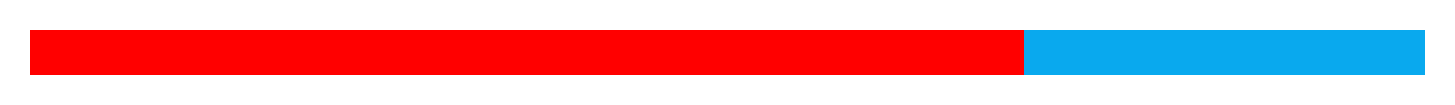

In [70]:
sns_df=clinical_order[['cluster_2']].T
fig=plt.figure(figsize=(6,0.20))
ax=fig.add_subplot(111)
ax=sns.heatmap(sns_df,cmap='rainbow',cbar=False,vmin=-0.3,xticklabels=0)
ax.set_yticks([])

[]

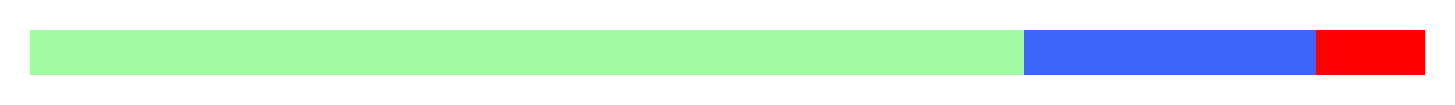

In [71]:
sns_df=clinical_order[['cluster_3']].T
fig=plt.figure(figsize=(6,0.20))
ax=fig.add_subplot(111)
ax=sns.heatmap(sns_df,cmap='rainbow',cbar=False,vmin=-0.3,xticklabels=0)
ax.set_yticks([])

[]

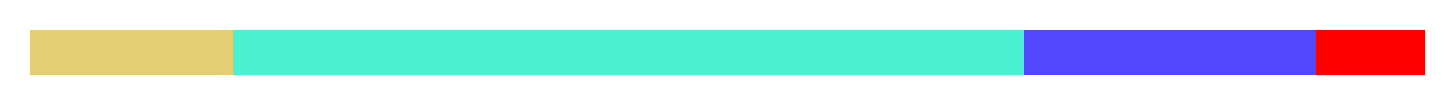

In [72]:
sns_df=clinical_order[['cluster_4']].T
fig=plt.figure(figsize=(6,0.20))
ax=fig.add_subplot(111)
ax=sns.heatmap(sns_df,cmap='rainbow',cbar=False,vmin=-0.3,xticklabels=0)
ax.set_yticks([])

[]

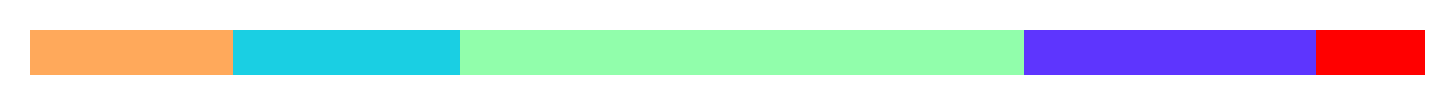

In [73]:
sns_df=clinical_order[['cluster_5']].T
fig=plt.figure(figsize=(6,0.20))
ax=fig.add_subplot(111)
ax=sns.heatmap(sns_df,cmap='rainbow',cbar=False,vmin=-0.3,xticklabels=0)
ax.set_yticks([])

[]

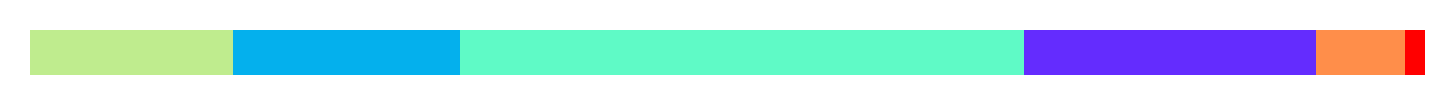

In [74]:
sns_df=clinical_order[['cluster_6']].T
fig=plt.figure(figsize=(6,0.20))
ax=fig.add_subplot(111)
ax=sns.heatmap(sns_df,cmap='rainbow',cbar=False,vmin=-0.3,xticklabels=0)
ax.set_yticks([])

In [75]:
from matplotlib.colors import ListedColormap as lc
cluster_4_colors=lc(["tab:blue",'tab:orange','tab:green','tab:red'])
cluster_5_colors=lc(["tab:blue",'tab:orange','tab:green','tab:red','tab:grey'])
cluster_4p1_colors=lc(['grey',"tab:blue",'tab:orange','tab:green','tab:red'])

In [76]:
clinical_order['cluster_4'].unique()

array([2, 1, 0, 3])

[]

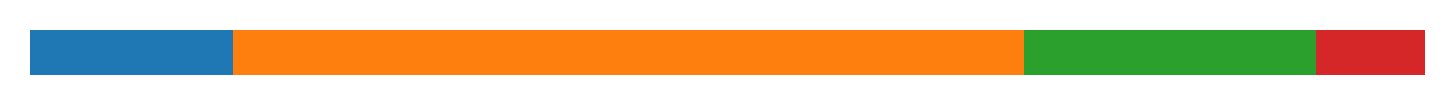

In [77]:
sns_df=clinical_order[['cluster_4']].T.replace({2:0,1:1,0:2,3:3})
fig=plt.figure(figsize=(6,0.20))
ax=fig.add_subplot(111)
ax=sns.heatmap(sns_df,cmap=cluster_4_colors,cbar=False,vmin=-0.3,xticklabels=0)
ax.set_yticks([])

### Silhoette test

In [78]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

For n_clusters = 2 The average silhouette_score is : 0.32416283661624434
For n_clusters = 3 The average silhouette_score is : 0.31727662950618346
For n_clusters = 4 The average silhouette_score is : 0.2714257456296584
For n_clusters = 5 The average silhouette_score is : 0.22813573931397305
For n_clusters = 6 The average silhouette_score is : 0.23302832228262146
For n_clusters = 7 The average silhouette_score is : 0.20977467324644533
For n_clusters = 8 The average silhouette_score is : 0.19841326120621436


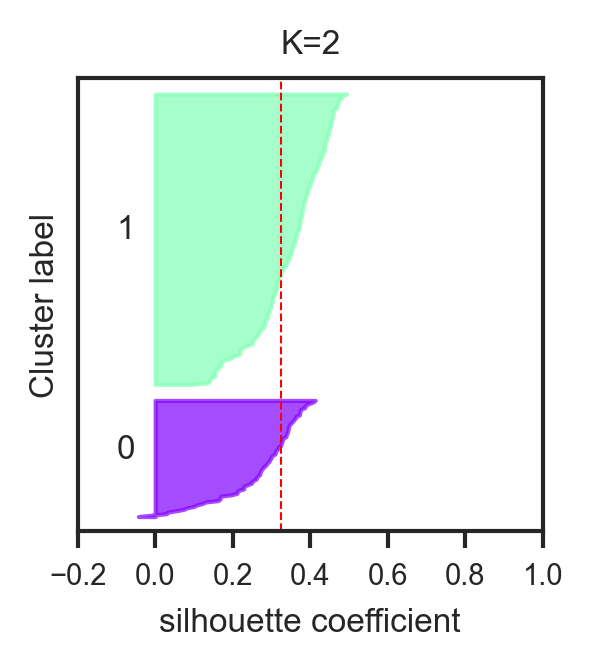

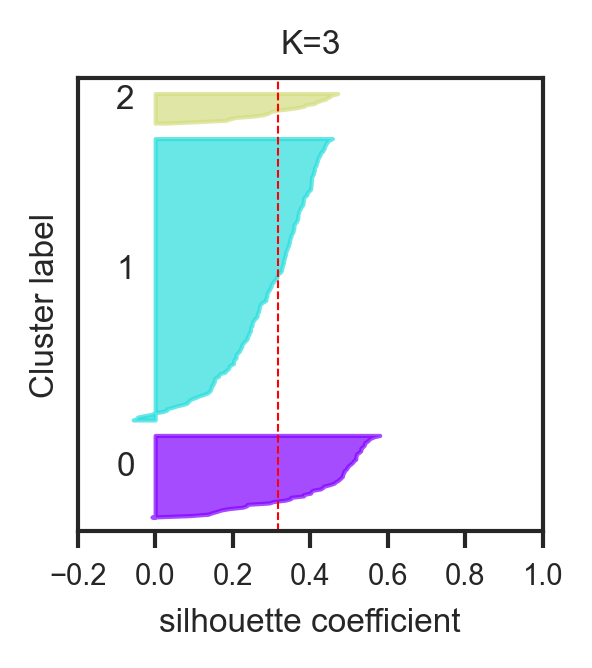

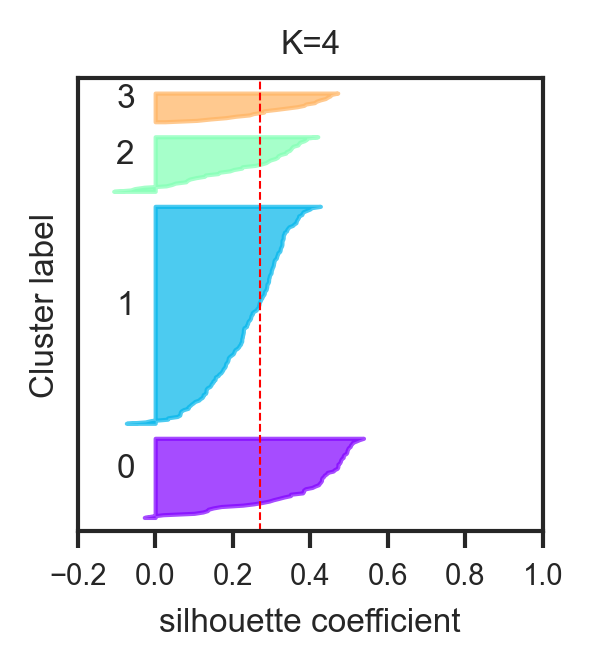

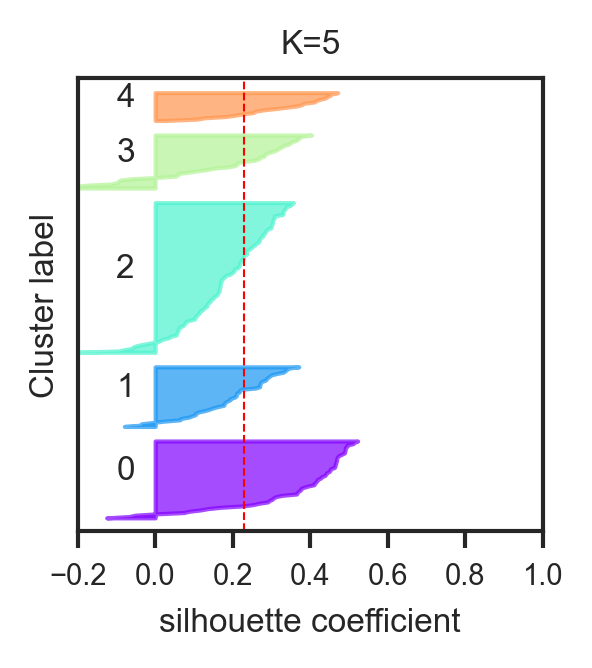

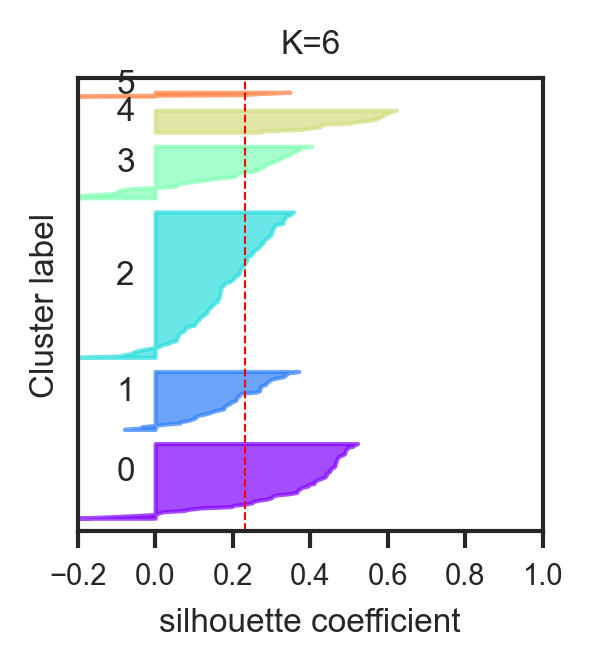

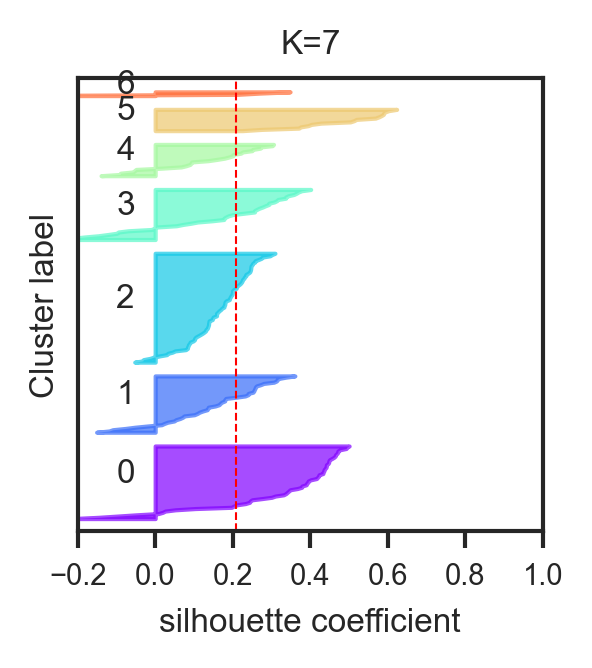

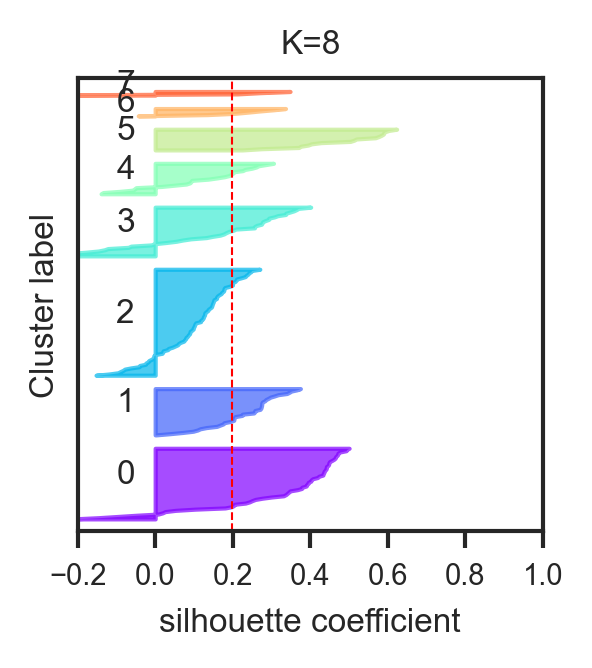

In [79]:
range_n_clusters = [2, 3, 4, 5, 6,7,8]
silhouette_avgs=[]
X = cnv_r
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(2,2)
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    cluster_labels = cuttree[:,n_clusters-2]
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_avgs.append(silhouette_avg)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.rainbow(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.1, y_lower + 0.5 * size_cluster_i, str(i), fontsize=8)

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("K="+str(n_clusters))
    ax.set_xlabel("silhouette coefficient")
    ax.set_ylabel("Cluster label")
    ax.set_xlim(-0.2,1)

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

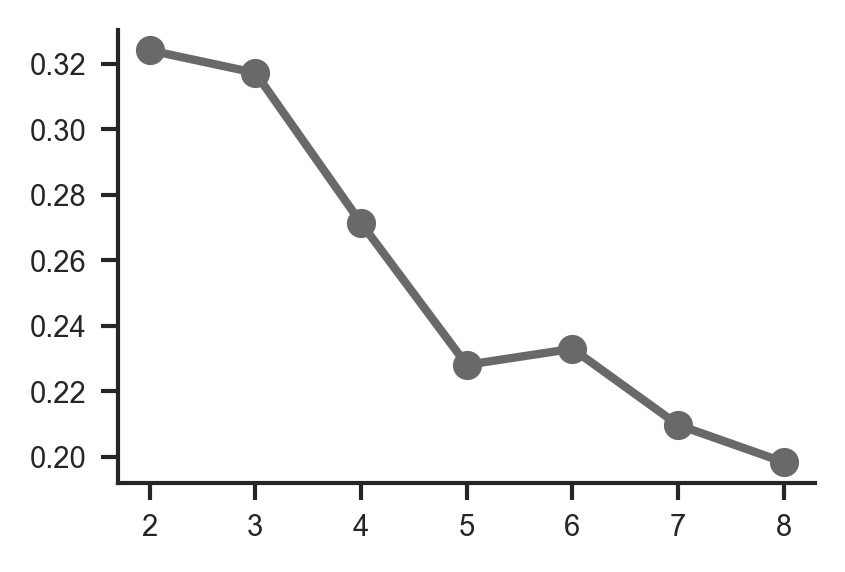

In [80]:
fig=plt.figure(figsize=(3,2))
ax=fig.add_subplot(111)
x=np.arange(2,9)
y=silhouette_avgs
ax.plot(x,y,c='dimgrey',lw=2)
ax.scatter(x,y,c=['dimgrey'])
ax.spines['right' ].set_visible(False)
ax.spines['top' ].set_visible(False)

In [81]:
Counter(clinical_order['cluster_4'])

Counter({2: 41, 1: 160, 0: 59, 3: 22})

### PCA/UMAP

In [82]:
cluster_label_prder=clinical_order['cluster_4'].unique()
dict_cluster_order={k:'C'+str(i+1) for i,k in enumerate(cluster_label_prder)}
dict_cluster_order2={k:i for i,k in enumerate(cluster_label_prder)}
clinical_order['cluster_c']=clinical_order['cluster_4'].replace(dict_cluster_order)
clinical_order['cluster_c_int']=clinical_order['cluster_4'].replace(dict_cluster_order2)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


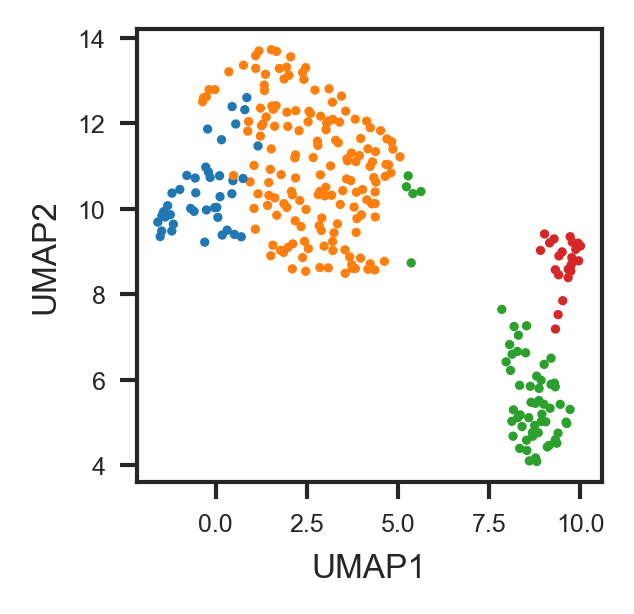

In [83]:
### umap check
import umap

data=cnv_r
trans=umap.UMAP(random_state=0,n_components=2,
                n_neighbors=25,
                min_dist=0.35,
                metric='euclidean'
               ).fit(data)
X=trans.transform(data)

colors=clinical_order.loc[data.index,'cluster_c_int'].replace({0:'tab:blue',1:'tab:orange',2:'tab:green',3:'tab:red',4:'purple',5:'brown',
                                                          6:'hotpink'})

#colors2=y_resampled.replace({0:'dimgrey',1:'blue'})

# plot
fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot(1,1,1)    
ax.scatter(X[:, 0], X[:, 1],ec=colors,fc=colors,s=3,lw=0.5)
#ax.scatter(X2[:, 0], X2[:, 1],ec='k',fc='None',s=10,lw=0.5)
#ax.scatter(X3[:, 0], X3[:, 1],ec='k',fc=colors2,s=10,lw=0.5)


ax.set_xlabel("UMAP1",fontsize=8)
ax.set_ylabel("UMAP2",fontsize=8)
ax.tick_params(labelsize=6)  

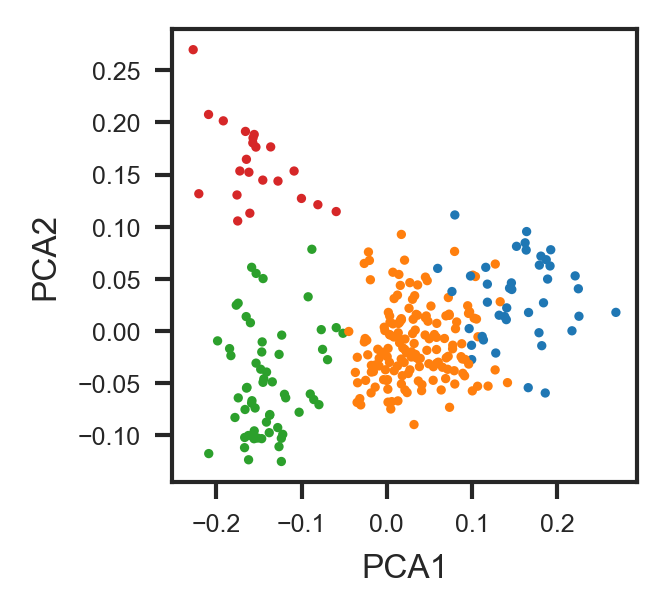

In [84]:
### pca
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

data=cnv_r
pca =PCA(n_components=2)
pca.fit(data)
X=pca.transform(data)

colors=clinical_order.loc[data.index,'cluster_c_int'].replace({0:'tab:blue',1:'tab:orange',2:'tab:green',3:'tab:red',4:'purple',5:'brown',
                                                          6:'hotpink'})

fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot(1,1,1)    
ax.scatter(X[:, 0], X[:, 1],ec=colors,fc=colors,s=3,lw=0.5)


ax.set_xlabel("PCA1",fontsize=8)
ax.set_ylabel("PCA2",fontsize=8)
ax.tick_params(labelsize=6)  

In [85]:
Counter(clinical_order['cluster_c'])

Counter({'C1': 41, 'C2': 160, 'C3': 59, 'C4': 22})

In [86]:
add=pd.get_dummies(clinical_order['cluster_c'])
clinical_order=clinical_order.merge(add,left_index=True,right_index=True,how='left')

In [87]:
clinical_order[['cluster_c','cluster_c_int','C4']].to_csv('../data/JGOG_282_assigned_cluster.txt',sep='\t')

## Genomic features

### Heatmap

[]

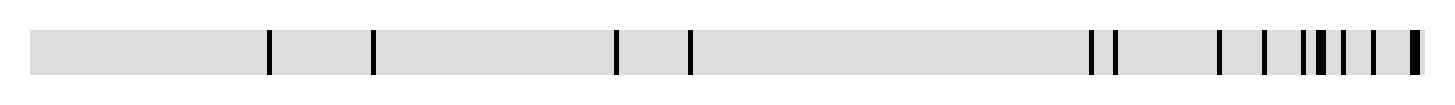

In [88]:
sns_df=(clinical_order[['HGEC']]).T
fig=plt.figure(figsize=(6,0.20))
ax=fig.add_subplot(111)
ax=sns.heatmap(sns_df,cmap='Greys',cbar=False,vmin=-0.3,xticklabels=0)
ax.set_yticks([])

In [89]:
clinical_order['HGEC_add']=((clinical_order['HGEC']==1)|(clinical_order['initial_diagnosis']=='HGEC')).astype(int)
clinical_order['HGEC2']=(clinical_order['initial_diagnosis']=='HGEC').astype(int)

[]

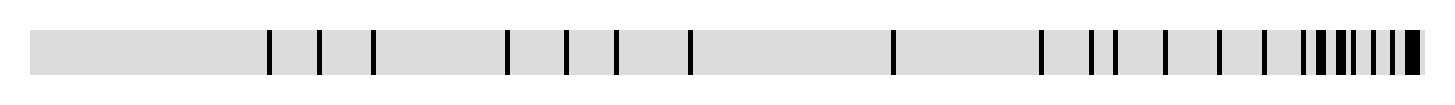

In [90]:
sns_df=(clinical_order[['HGEC_add']]).T
fig=plt.figure(figsize=(6,0.20))
ax=fig.add_subplot(111)
ax=sns.heatmap(sns_df,cmap='Greys',cbar=False,vmin=-0.3,xticklabels=0)
ax.set_yticks([])

[]

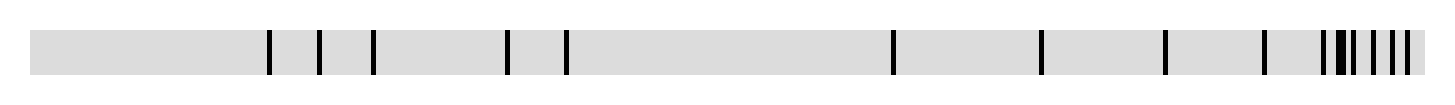

In [91]:
sns_df=(clinical_order[['HGEC2']]).T
fig=plt.figure(figsize=(6,0.20))
ax=fig.add_subplot(111)
ax=sns.heatmap(sns_df,cmap='Greys',cbar=False,vmin=-0.3,xticklabels=0)
ax.set_yticks([])

[]

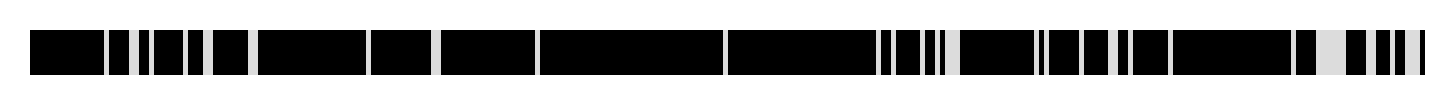

In [92]:
sns_df=(clinical_order[['TP53_mut']]).T
fig=plt.figure(figsize=(6,0.20))
ax=fig.add_subplot(111)
ax=sns.heatmap(sns_df,cmap='Greys',cbar=False,vmin=-0.3,xticklabels=0)
ax.set_yticks([])

[]

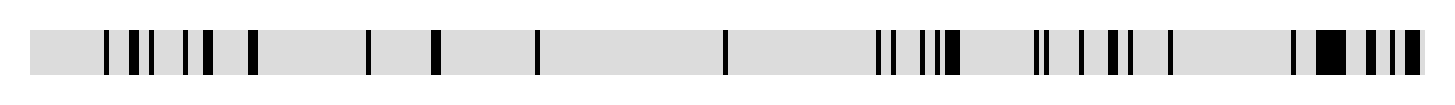

In [93]:
sns_df=(clinical_order[['TP53_neg']]).T
fig=plt.figure(figsize=(6,0.20))
ax=fig.add_subplot(111)
ax=sns.heatmap(sns_df,cmap='Greys',cbar=False,vmin=-0.3,xticklabels=0)
ax.set_yticks([])

[]

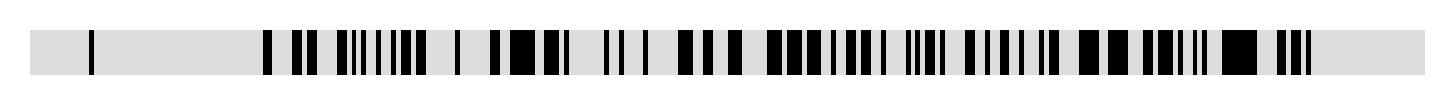

In [94]:
sns_df=clinical_order[['BRCA12_alt']].T
fig=plt.figure(figsize=(6,0.20))
ax=fig.add_subplot(111)
ax=sns.heatmap(sns_df,cmap='Greys',cbar=False,vmin=-0.3,xticklabels=0)
ax.set_yticks([])

[]

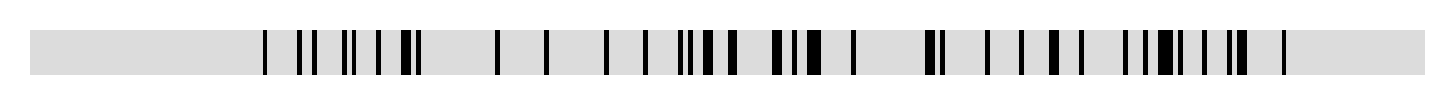

In [95]:
sns_df=clinical_order[['BRCA1_LOH']].T
fig=plt.figure(figsize=(6,0.20))
ax=fig.add_subplot(111)
ax=sns.heatmap(sns_df,cmap='Greys',cbar=False,vmin=-0.3,xticklabels=0)
ax.set_yticks([])

[]

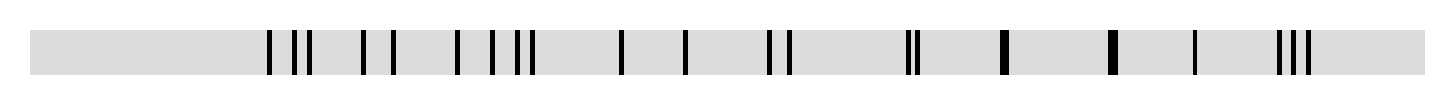

In [96]:
sns_df=clinical_order[['BRCA2_LOH']].T
fig=plt.figure(figsize=(6,0.20))
ax=fig.add_subplot(111)
ax=sns.heatmap(sns_df,cmap='Greys',cbar=False,vmin=-0.3,xticklabels=0)
ax.set_yticks([])

[]

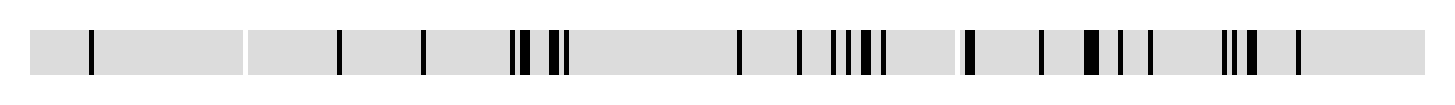

In [97]:
sns_df=clinical_order[['BRCA1_methylation_all']].T
fig=plt.figure(figsize=(6,0.20))
ax=fig.add_subplot(111)
ax=sns.heatmap(sns_df,cmap='Greys',cbar=False,vmin=-0.3,xticklabels=0)
ax.set_yticks([])

[]

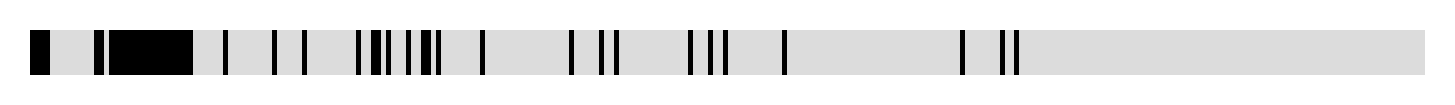

In [98]:
sns_df=clinical_order[['CCNE1_amp2']].T
fig=plt.figure(figsize=(6,0.20))
ax=fig.add_subplot(111)
ax=sns.heatmap(sns_df,cmap='Greys',cbar=False,vmin=-0.3,xticklabels=0)
ax.set_yticks([])

[]

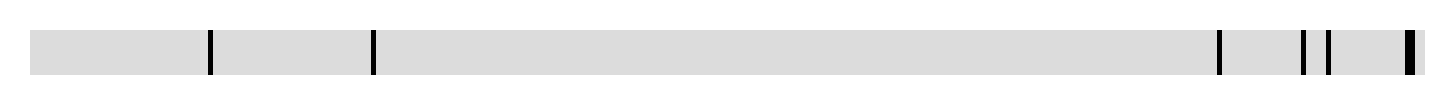

In [99]:
sns_df=clinical_order[['KRAS_mut']].T
fig=plt.figure(figsize=(6,0.20))
ax=fig.add_subplot(111)
ax=sns.heatmap(sns_df,cmap='Greys',cbar=False,vmin=-0.3,xticklabels=0)
ax.set_yticks([])

[]

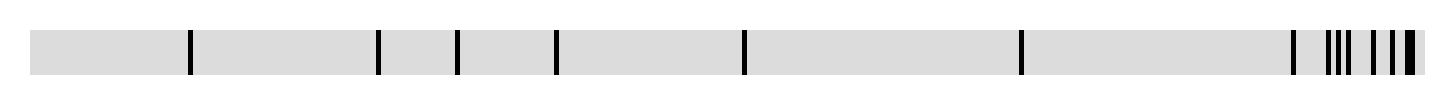

In [100]:
sns_df=clinical_order[['ARID1A_mut']].T
fig=plt.figure(figsize=(6,0.20))
ax=fig.add_subplot(111)
ax=sns.heatmap(sns_df,cmap='Greys',cbar=False,vmin=-0.3,xticklabels=0)
ax.set_yticks([])

[]

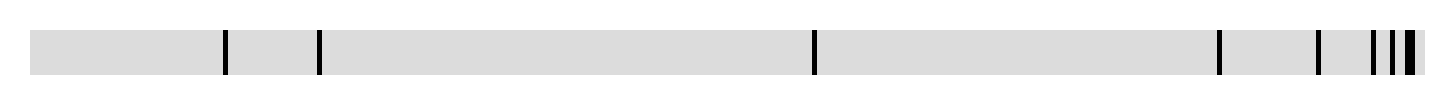

In [101]:
sns_df=clinical_order[['PIK3CA_mut']].T
fig=plt.figure(figsize=(6,0.20))
ax=fig.add_subplot(111)
ax=sns.heatmap(sns_df,cmap='Greys',cbar=False,vmin=-0.3,xticklabels=0)
ax.set_yticks([])

[]

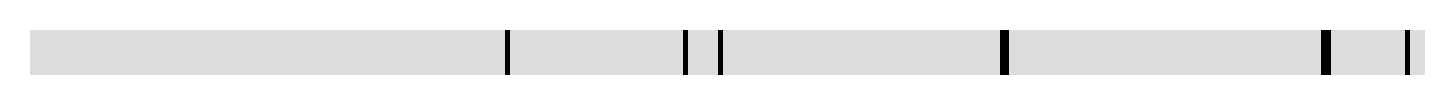

In [102]:
sns_df=clinical_order[['PTEN_mut']].T
fig=plt.figure(figsize=(6,0.20))
ax=fig.add_subplot(111)
ax=sns.heatmap(sns_df,cmap='Greys',cbar=False,vmin=-0.3,xticklabels=0)
ax.set_yticks([])

[]

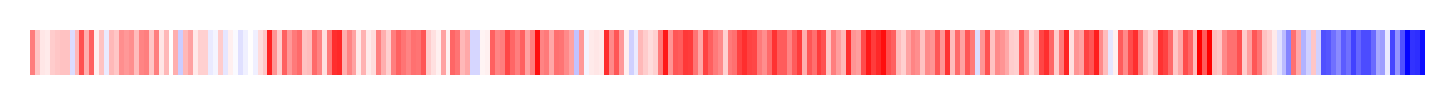

In [103]:
sns_df=clinical_order[['HRD_score']].T
fig=plt.figure(figsize=(6,0.20))
ax=fig.add_subplot(111)
ax=sns.heatmap(sns_df,cmap=bwr,cbar=False,xticklabels=0,vmin=0,vmax=100)
ax.set_yticks([])

[]

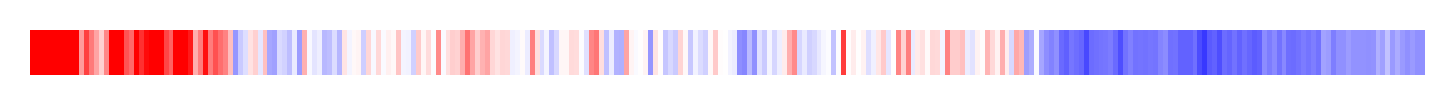

In [104]:
clinical_order[['ploidy_z']]=stats.zscore(clinical_order[['ploidy']],axis=0,nan_policy='omit')
sns_df=clinical_order[['ploidy_z']].T
fig=plt.figure(figsize=(6,0.20))
ax=fig.add_subplot(111)
ax=sns.heatmap(sns_df,cmap=bwr,cbar=False,xticklabels=0,vmin=-2,vmax=2)
ax.set_yticks([])

[]

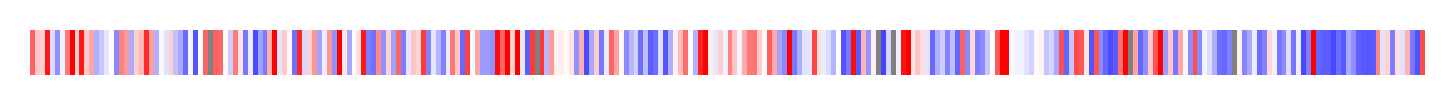

In [105]:
clinical_order[['MATH_z']]=stats.zscore(clinical_order[['MATH']],axis=0,nan_policy='omit')
sns_df=stats.zscore( clinical_order[['MATH_z']],axis=0,nan_policy='omit').T 
fig=plt.figure(figsize=(6,0.20))
ax=fig.add_subplot(111)
ax=sns.heatmap(sns_df,cmap=bwr,cbar=False,xticklabels=0,vmin=-2,vmax=2)
ax.set_yticks([])

[]

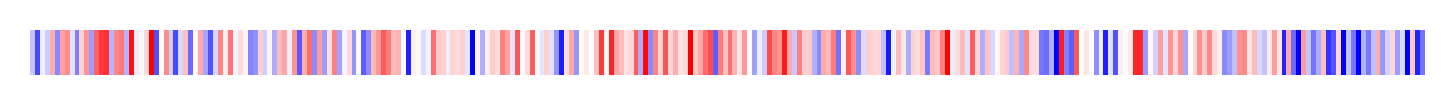

In [106]:
sns_df=clinical_order[['KEGG_CELL_CYCLE']].T 
fig=plt.figure(figsize=(6,0.20))
ax=fig.add_subplot(111)
ax=sns.heatmap(sns_df,cmap=bwr,cbar=False,xticklabels=0,vmin=-2,vmax=2)
ax.set_yticks([])

[]

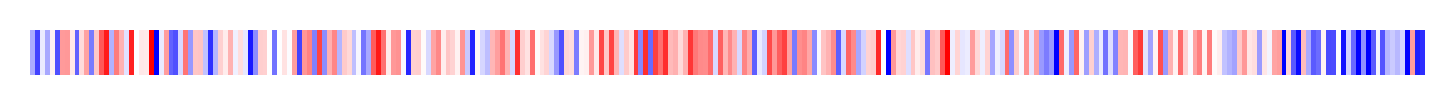

In [107]:
sns_df=clinical_order[['HALLMARK_G2M_CHECKPOINT']].T 
fig=plt.figure(figsize=(6,0.20))
ax=fig.add_subplot(111)
ax=sns.heatmap(sns_df,cmap=bwr,cbar=False,xticklabels=0,vmin=-2,vmax=2)
ax.set_yticks([])

[]

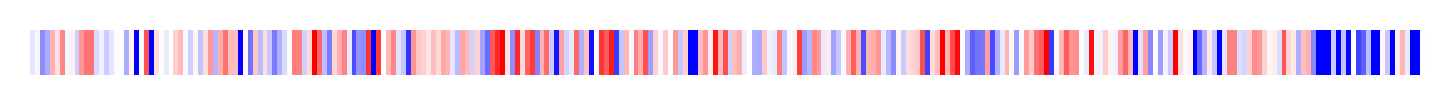

In [108]:
clinical_order['WT1_log_z']=stats.zscore(clinical_order['WT1_log'])
sns_df=clinical_order[['WT1_log_z']].T 
fig=plt.figure(figsize=(6,0.20))
ax=fig.add_subplot(111)
ax=sns.heatmap(sns_df,cmap=bwr,cbar=False,xticklabels=0,vmin=-2,vmax=2)
ax.set_yticks([])

### BOX plot

cluster_c MW test p= 1.207074815183992e-14
cluster_c MW test p= 1.902838031576459e-05
cluster_c MW test p= 0.00022614743428306136


/Users/tshiro/.pyenv/versions/miniforge3-4.10/envs/ngs/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 11.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/tshiro/.pyenv/versions/miniforge3-4.10/envs/ngs/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 13.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/tshiro/.pyenv/versions/miniforge3-4.10/envs/ngs/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 11.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


cluster_c T-test p= 1.9456615072056088e-07
cluster_c MW test p= 2.078320099260525e-07
cluster_c MW test p= 1.5016684029824588e-06


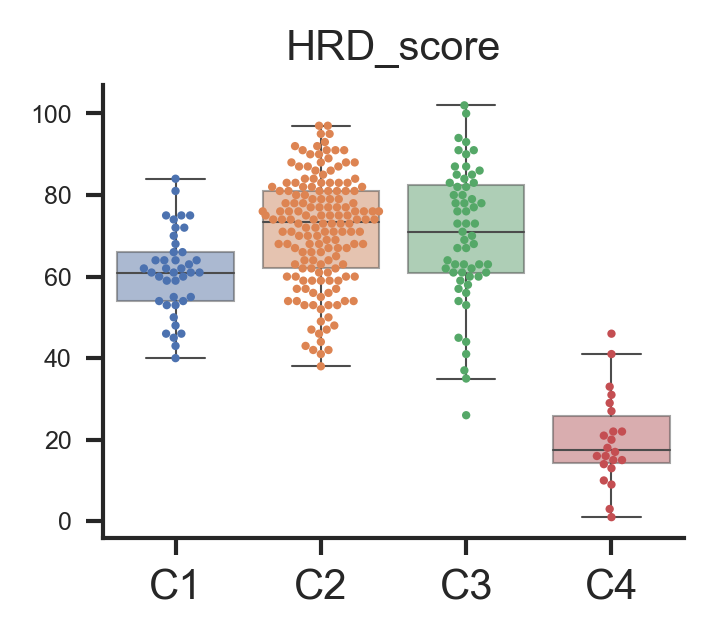

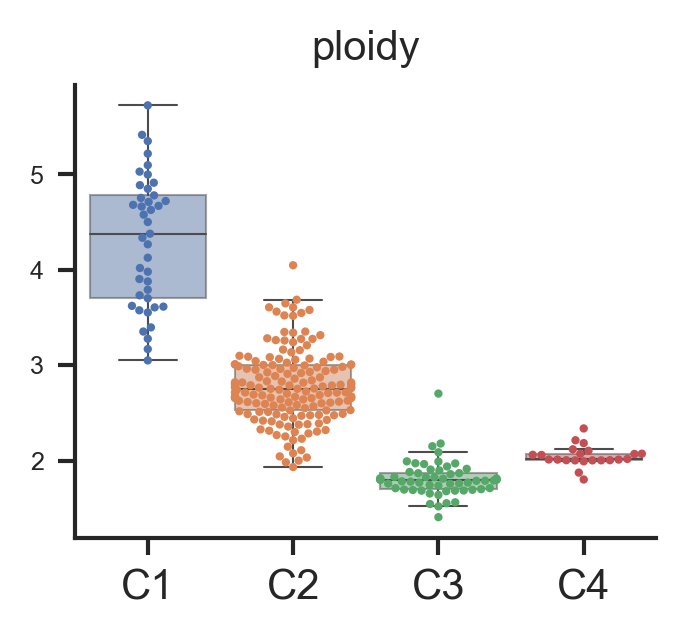

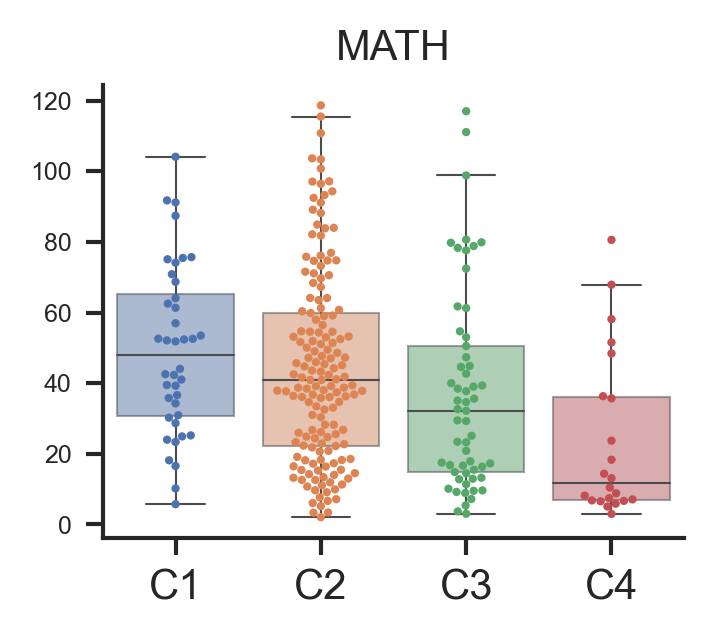

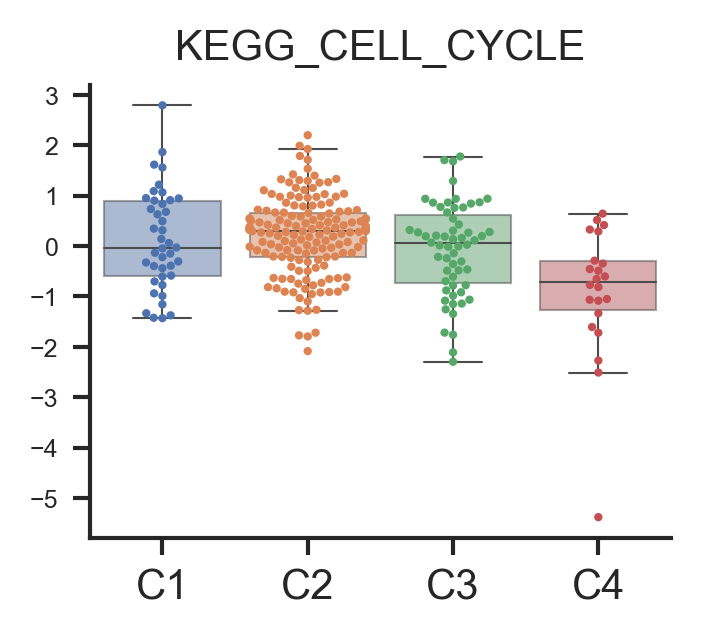

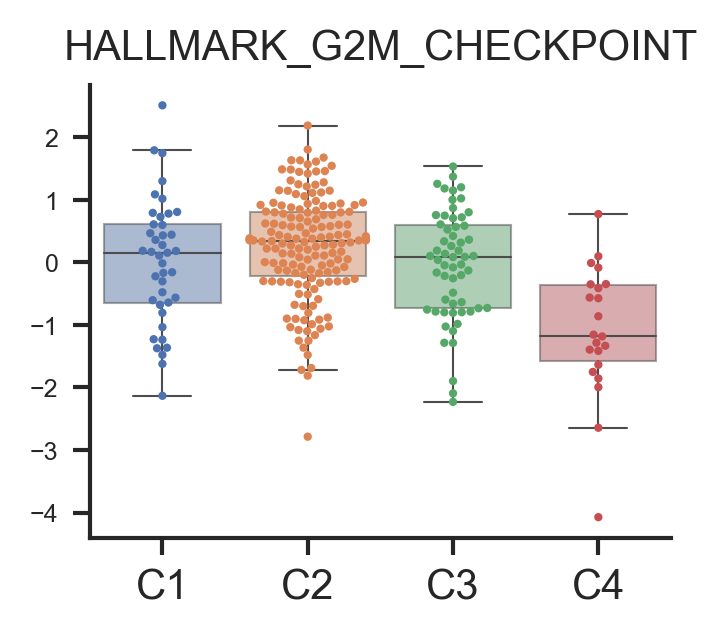

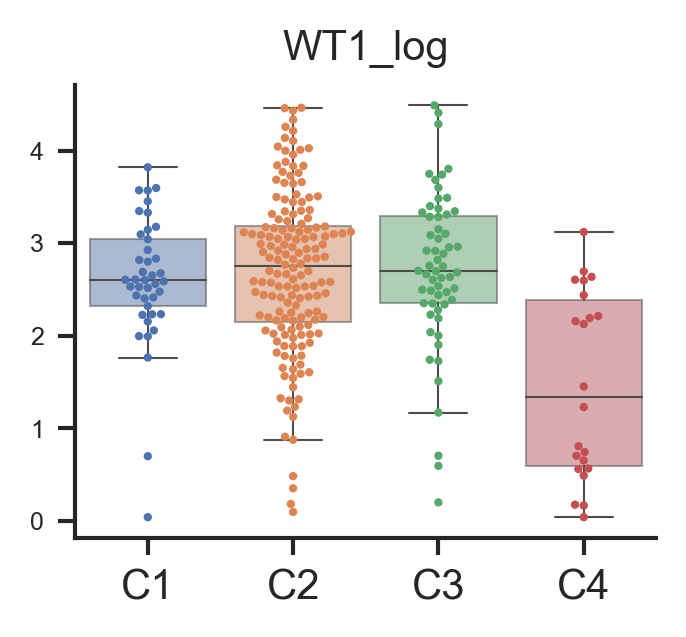

In [109]:
vals=['HRD_score','ploidy','MATH','KEGG_CELL_CYCLE','HALLMARK_G2M_CHECKPOINT','WT1_log']
for val in vals:
    plt_df=clinical_order
    cat='cluster_c'
    c_order=['C1','C2','C3','C4']
    fig=plt.figure(figsize=(2.5,2))
    ax=fig.add_subplot(1,1,1)
    sns.boxplot(x=cat,y=val,data=plt_df,boxprops={'alpha':0.5},sym='',order=c_order)#,hue=hue,palette=palette)
    sns.swarmplot(x=cat,y=val,data=plt_df,s=2,order=c_order)#,order=order,hue=hue,dodge=True,palette=palette)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(val,fontsize=10)
    ax.tick_params('y',labelsize=6)
    ax.tick_params('x',labelsize=10)
    
    ax.spines['top'   ].set_visible(False)# .set_color("w")
    ax.spines['right' ].set_visible(False)
    ax.legend([])
    
    a=plt_df[plt_df[cat].isin(['C1','C2','C3'])][val].dropna()
    b=plt_df[plt_df[cat].isin(['C4'])][val].dropna()
    
    _,p1=kstest_normal(a)
    _,p2=kstest_normal(b)

    if (p1>0.05)&(p2>0.05):
        _,p=stats.ttest_ind(a,b,nan_policy='omit')
        print(cat,"T-test p=",p)
    else:
        _,p=stats.mannwhitneyu(a,b)
        print(cat,'MW test p=',p)

### Table categorical

In [110]:
ct=pd.crosstab(clinical_order['cluster_c'],clinical_order['HGEC']).T
ct

cluster_c  C1   C2  C3  C4
HGEC                      
0          41  156  54  16
1           0    4   5   6

In [111]:
ct2=pd.concat(  [ ct.loc[:,'C1':'C3'].apply(np.sum, axis=1), ct['C4']],axis=1)
print(ct2)
stats.chi2_contingency(ct2,correction=False)[1]

        0  C4
HGEC         
0     251  16
1       9   6


1.765034665550221e-06

In [112]:
ct2=pd.concat(  [ ct.loc[:,'C2':'C4'].apply(np.sum, axis=1), ct['C1']],axis=1)
print(ct2)
stats.chi2_contingency(ct2,correction=False)[1]

        0  C1
HGEC         
0     226  41
1      15   0


0.10064892965446112

In [113]:
add1=ct.iloc[1,:]/np.sum(ct,axis=0)*100
add1.name='HGEC'
add1

cluster_c
C1     0.000000
C2     2.500000
C3     8.474576
C4    27.272727
Name: HGEC, dtype: float64

In [114]:
ct=pd.crosstab(clinical_order['cluster_c'],clinical_order['TP53_mut']).T
ct

cluster_c  C1   C2  C3  C4
TP53_mut                  
0           7   14   8  12
1          34  146  51  10

In [115]:
ct2=pd.concat(  [ ct.loc[:,'C1':'C3'].apply(np.sum, axis=1), ct['C4']],axis=1)
print(ct2)
stats.chi2_contingency(ct2,correction=False)[1]

            0  C4
TP53_mut         
0          29  12
1         231  10


2.9553866419125982e-08

In [116]:
add2=ct.iloc[1,:]/np.sum(ct,axis=0)*100
add2.name='TP53 mutation'
add2

cluster_c
C1    82.926829
C2    91.250000
C3    86.440678
C4    45.454545
Name: TP53 mutation, dtype: float64

In [117]:
ct=pd.crosstab(clinical_order['cluster_c'],clinical_order['CCNE1_amp2']).T
ct

cluster_c   C1   C2  C3  C4
CCNE1_amp2                 
0.0         17  139  59  22
1.0         24   21   0   0

In [118]:
ct2=pd.concat(  [ ct.loc[:,'C1':'C3'].apply(np.sum, axis=1), ct['C4']],axis=1)
print(ct2)
stats.fisher_exact(ct2)[1]

              0  C4
CCNE1_amp2         
0.0         215  22
1.0          45   0


0.0311257792222933

In [119]:
ct2=pd.concat(  [ ct.loc[:,'C2':'C4'].apply(np.sum, axis=1), ct['C1']],axis=1)
print(ct2)
stats.chi2_contingency(ct2,correction=False)[1]

              0  C1
CCNE1_amp2         
0.0         220  17
1.0          21  24


8.0595528234985e-16

In [120]:
add3=ct.iloc[1,:]/np.sum(ct,axis=0)*100
add3.name='CCNE1 amplification'
add3

cluster_c
C1    58.536585
C2    13.125000
C3     0.000000
C4     0.000000
Name: CCNE1 amplification, dtype: float64

In [121]:
ct=pd.crosstab(clinical_order['cluster_c'],clinical_order['BRCA12_alt']).T
ct

cluster_c   C1  C2  C3  C4
BRCA12_alt                
0           40  95  28  22
1            1  65  31   0

In [122]:
ct2=pd.concat(  [ ct.loc[:,'C1':'C3'].apply(np.sum, axis=1), ct['C4']],axis=1)
print(ct2)
stats.fisher_exact(ct2)[1]

              0  C4
BRCA12_alt         
0           163  22
1            97   0


8.302372901948831e-05

In [123]:
add4=ct.iloc[1,:]/np.sum(ct,axis=0)*100
add4.name='BRCA1/2 alteration'
add4

cluster_c
C1     2.439024
C2    40.625000
C3    52.542373
C4     0.000000
Name: BRCA1/2 alteration, dtype: float64

In [124]:
clinical_order['AKPP_mut']=((clinical_order['ARID1A_mut']==1)|(clinical_order['KRAS_mut']==1)|\
(clinical_order['PTEN_mut']==1)|(clinical_order['PIK3CA_mut']==1)).astype(int)

In [125]:
ct=pd.crosstab(clinical_order['cluster_c'],clinical_order['AKPP_mut']).T
ct

cluster_c  C1   C2  C3  C4
AKPP_mut                  
0          38  147  56  13
1           3   13   3   9

In [126]:
ct2=pd.concat(  [ ct.loc[:,'C1':'C3'].apply(np.sum, axis=1), ct['C4']],axis=1)
print(ct2)
stats.chi2_contingency(ct2,correction=False)[1]

            0  C4
AKPP_mut         
0         241  13
1          19   9


4.1839824402561536e-07

In [127]:
add5=ct.iloc[1,:]/np.sum(ct,axis=0)*100
add5.name='AKPP mutation'
add5

cluster_c
C1     7.317073
C2     8.125000
C3     5.084746
C4    40.909091
Name: AKPP mutation, dtype: float64

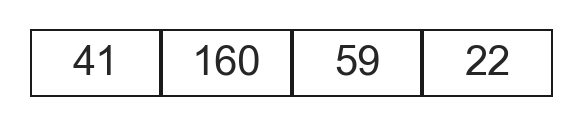

In [128]:
sns_df=pd.DataFrame(np.sum(ct)).T
sns_df.index=['number']
fig=plt.figure(figsize=(2.25,0.3))
ax=fig.add_subplot(111)
sns.heatmap(sns_df,vmin=200,vmax=200,cmap=wk,cbar=False,ax=ax,linecolor='k',linewidths=0.5,
           annot=sns_df.astype(int),fmt='.3g' )
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('')
ax.set_yticks([])
ax.set_xticks([])

ax.tick_params(labelsize=10)

[]

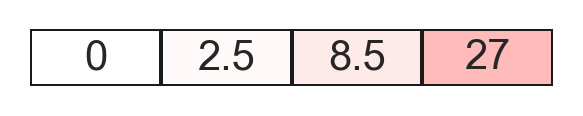

In [129]:
sns_df=pd.concat([add1],axis=1).T
fig=plt.figure(figsize=(2.25,0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df,vmin=0,vmax=100,cmap=wr,cbar=False,ax=ax,linecolor='k',linewidths=0.5,
           annot=sns_df)
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('')
ax.set_xticks([])
ax.set_yticks([])
#ax.tick_params(labelsize=10)
#ax.set_yticklabels([])

[]

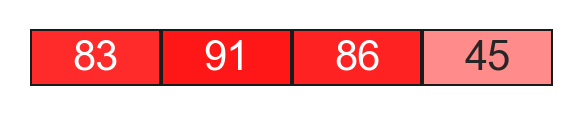

In [130]:
sns_df=pd.concat([add2],axis=1).T
fig=plt.figure(figsize=(2.25,0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df,vmin=0,vmax=100,cmap=wr,cbar=False,ax=ax,linecolor='k',linewidths=0.5,
           annot=sns_df)
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('')
ax.set_xticks([])
ax.set_yticks([])
#ax.tick_params(labelsize=10)
#ax.set_yticklabels([])

[]

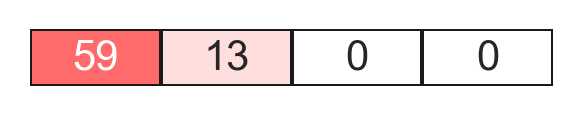

In [131]:
sns_df=pd.concat([add3],axis=1).T
fig=plt.figure(figsize=(2.25,0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df,vmin=0,vmax=100,cmap=wr,cbar=False,ax=ax,linecolor='k',linewidths=0.5,
           annot=sns_df)
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('')
ax.set_xticks([])
ax.set_yticks([])
#ax.tick_params(labelsize=10)
#ax.set_yticklabels([])

[]

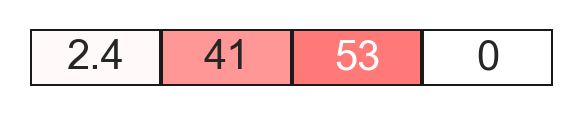

In [132]:
sns_df=pd.concat([add4],axis=1).T
fig=plt.figure(figsize=(2.25,0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df,vmin=0,vmax=100,cmap=wr,cbar=False,ax=ax,linecolor='k',linewidths=0.5,
           annot=sns_df)
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('')
ax.set_xticks([])
ax.set_yticks([])
#ax.tick_params(labelsize=10)
#ax.set_yticklabels([])

[]

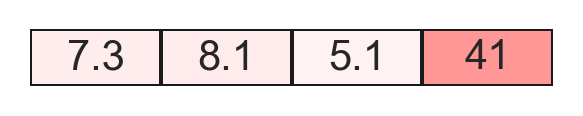

In [133]:
sns_df=pd.concat([add5],axis=1).T
fig=plt.figure(figsize=(2.25,0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df,vmin=0,vmax=100,cmap=wr,cbar=False,ax=ax,linecolor='k',linewidths=0.5,
           annot=sns_df)
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('')
ax.set_xticks([])
ax.set_yticks([])
#ax.tick_params(labelsize=10)
#ax.set_yticklabels([])

### Table2 continuous

In [134]:
cat='HRD_score'
clinical_order.groupby('cluster_c').mean()['HRD_score']

cluster_c
C1    61.146341
C2    71.437500
C3    70.271186
C4    19.954545
Name: HRD_score, dtype: float64

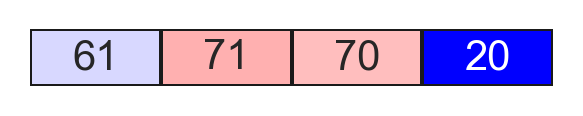

In [135]:
cat='HRD_score'
p1=np.nanpercentile(clinical_order[cat],10)
p3=np.nanpercentile(clinical_order[cat],90)
sns_df=pd.DataFrame(clinical_order.groupby('cluster_c').mean()[cat]).T
sns_df.index=[cat]
fig=plt.figure(figsize=(2.25,0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df,vmin=p1,vmax=p3,cmap=bwr,cbar=False,ax=ax,linecolor='k',linewidths=0.5,
           annot=sns_df,fmt='.2g' )
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('')
ax.set_yticks([])
ax.set_xticks([])

ax.tick_params(labelsize=10)

In [136]:
a=clinical_order[clinical_order['cluster_c']=='C4'][cat].values
b=clinical_order[clinical_order['cluster_c'].isin(['C1','C2','C3'])][cat].values

_,p1=kstest_normal(a)
_,p2=kstest_normal(b)

if (p1>0.05)&(p2>0.05):
    _,p=stats.ttest_ind(a,b,nan_policy='omit')
    print("T-test p=",p)
else:
    _,p=stats.mannwhitneyu(a,b)
    print('MW test p=',p)

MW test p= 1.207074815183992e-14


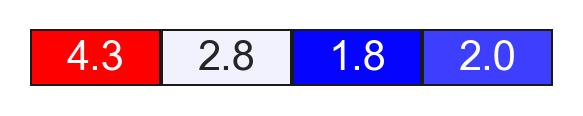

In [137]:
cat='ploidy'
p1=np.nanpercentile(clinical_order[cat],10)
p3=np.nanpercentile(clinical_order[cat],90)
sns_df=pd.DataFrame(clinical_order.groupby('cluster_c').mean()[cat]).T
sns_df.index=[cat]
fig=plt.figure(figsize=(2.25,0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df,vmin=p1,vmax=p3,cmap=bwr,cbar=False,ax=ax,linecolor='k',linewidths=0.5,
           annot=sns_df,fmt='.1f' )
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('')
ax.set_yticks([])
ax.set_xticks([])

ax.tick_params(labelsize=10)

In [138]:
a=clinical_order[clinical_order['cluster_c']=='C4'][cat].values
b=clinical_order[clinical_order['cluster_c']!='C4'][cat].values
_,p1=kstest_normal(a)
_,p2=kstest_normal(b)
if (p1>0.05)&(p2>0.05):
    _,p=stats.ttest_ind(a,b,nan_policy='omit')
    print("T-test p=",p)
else:
    _,p=stats.mannwhitneyu(a,b)
    print('MW test p=',p)

MW test p= 1.902838031576459e-05


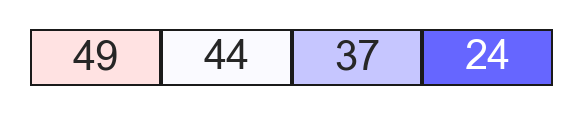

In [139]:
cat='MATH'
p1=np.nanpercentile(clinical_order[cat],10)
p3=np.nanpercentile(clinical_order[cat],90)
sns_df=pd.DataFrame(clinical_order.groupby('cluster_c').mean()[cat]).T
sns_df.index=[cat]
fig=plt.figure(figsize=(2.25,0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df,vmin=p1,vmax=p3,cmap=bwr,cbar=False,ax=ax,linecolor='k',linewidths=0.5,
           annot=sns_df,fmt='.2g' )
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('')
ax.set_yticks([])
ax.set_xticks([])

ax.tick_params(labelsize=10)

In [140]:
a=clinical_order[clinical_order['cluster_c']=='C4'][cat].dropna().values
b=clinical_order[clinical_order['cluster_c'].isin(['C1','C2','C3'])][cat].dropna().values
_,p1=kstest_normal(a)
_,p2=kstest_normal(b)
if (p1>0.05)&(p2>0.05):
    _,p=stats.ttest_ind(a,b,nan_policy='omit')
    print("T-test p=",p)
else:
    _,p=stats.mannwhitneyu(a,b)
    print('MW test p=',p)

MW test p= 0.00022614743428306136


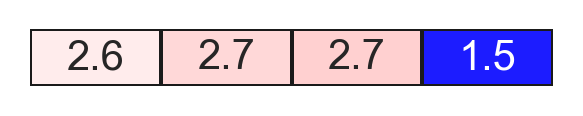

In [141]:
cat='WT1_log'
p1=np.nanpercentile(clinical_order[cat],10)
p3=np.nanpercentile(clinical_order[cat],90)
sns_df=pd.DataFrame(clinical_order.groupby('cluster_c').mean()[cat]).T
sns_df.index=[cat]
fig=plt.figure(figsize=(2.25,0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df,vmin=p1,vmax=p3,cmap=bwr,cbar=False,ax=ax,linecolor='k',linewidths=0.5,
           annot=sns_df,fmt='.2g' )
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('')
ax.set_yticks([])
ax.set_xticks([])

ax.tick_params(labelsize=10)

In [142]:
a=clinical_order[clinical_order['cluster_c']=='C4'][cat].dropna().values
b=clinical_order[clinical_order['cluster_c'].isin(['C1','C2','C3'])][cat].dropna().values
_,p1=kstest_normal(a)
_,p2=kstest_normal(b)
if (p1>0.05)&(p2>0.05):
    _,p=stats.ttest_ind(a,b,nan_policy='omit')
    print("T-test p=",p)
else:
    _,p=stats.mannwhitneyu(a,b)
    print('MW test p=',p)

MW test p= 1.5016684029824588e-06


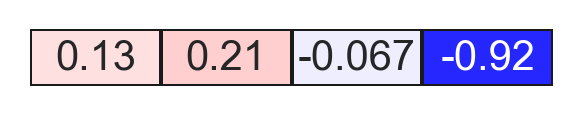

In [143]:
cat='KEGG_CELL_CYCLE'
p1=np.nanpercentile(clinical_order[cat],10)
p3=np.nanpercentile(clinical_order[cat],90)
sns_df=pd.DataFrame(clinical_order.groupby('cluster_c').mean()[cat]).T
sns_df.index=[cat]
fig=plt.figure(figsize=(2.25,0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df,vmin=p1,vmax=p3,cmap=bwr,cbar=False,ax=ax,linecolor='k',linewidths=0.5,
           annot=sns_df,fmt='.2g' )
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('')
ax.set_yticks([])
ax.set_xticks([])

ax.tick_params(labelsize=10)

In [144]:
a=clinical_order[clinical_order['cluster_c']=='C4'][cat].dropna().values
b=clinical_order[clinical_order['cluster_c'].isin(['C1','C2','C3'])][cat].dropna().values
_,p1=kstest_normal(a)
_,p2=kstest_normal(b)
if (p1>0.05)&(p2>0.05):
    _,p=stats.ttest_ind(a,b,nan_policy='omit')
    print("T-test p=",p)
else:
    _,p=stats.mannwhitneyu(a,b)
    print('MW test p=',p)

T-test p= 1.9456615072056088e-07


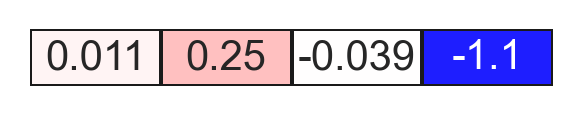

In [145]:
cat='HALLMARK_G2M_CHECKPOINT'
p1=np.nanpercentile(clinical_order[cat],10)
p3=np.nanpercentile(clinical_order[cat],90)
sns_df=pd.DataFrame(clinical_order.groupby('cluster_c').mean()[cat]).T
sns_df.index=[cat]
fig=plt.figure(figsize=(2.25,0.25))
ax=fig.add_subplot(111)
sns.heatmap(sns_df,vmin=p1,vmax=p3,cmap=bwr,cbar=False,ax=ax,linecolor='k',linewidths=0.5,
           annot=sns_df,fmt='.2g' )
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('')
ax.set_yticks([])
ax.set_xticks([])

ax.tick_params(labelsize=10)

In [146]:
a=clinical_order[clinical_order['cluster_c']=='C4'][cat].dropna().values
b=clinical_order[clinical_order['cluster_c'].isin(['C1','C2','C3'])][cat].dropna().values
_,p1=kstest_normal(a)
_,p2=kstest_normal(b)
# print(cat,'KS test p=',p1,p2)
if (p1>0.05)&(p2>0.05):
    _,p=stats.ttest_ind(a,b,nan_policy='omit')
    print("T-test p=",p)
else:
    _,p=stats.mannwhitneyu(a,b)
    print('MW test p=',p)

MW test p= 2.078320099260525e-07


## Comparison to CRP-based, ITI-based, combined diagnosis

In [147]:
Counter(clinical_order['HGEC_add'])

Counter({0: 257, 1: 25})

In [148]:
clinical_order['AKPP_mut']=((clinical_order['ARID1A_mut']==1)|(clinical_order['KRAS_mut']==1)|\
(clinical_order['PTEN_mut']==1)|(clinical_order['PIK3CA_mut']==1)).astype(int)

### CRP-based

In [149]:
Counter(clinical_order['HGEC'])

Counter({0: 267, 1: 15})

In [150]:
cats=['Number','TP53_mut','BRCA12_alt','CCNE1_amp2','AKPP_mut']

In [151]:
np.min(np.array(ct))

3

HGEC        0  1
TP53_mut        
0          34  7
1         233  8 Chi-sq p= 0.0002858561196171564
HGEC          0   1
BRCA12_alt         
0           174  11
1            93   4 Fisher p= 0.5897094077936046
HGEC          0   1
CCNE1_amp2         
0.0         225  12
1.0          42   3 Fisher p= 0.7149748539158588
HGEC        0  1
AKPP_mut        
0         246  8
1          21  7 Chi-sq p= 1.0101160528937151e-06


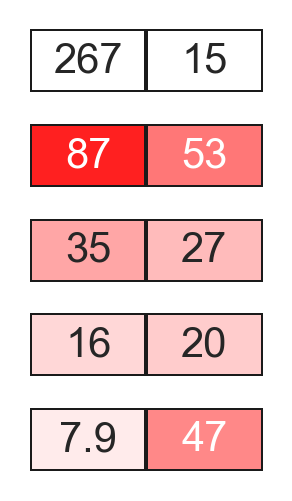

In [152]:
fig=plt.figure(figsize=(1,0.39*len(cats)))

for i,cat in enumerate(cats):
    ax=fig.add_subplot(len(cats),1,i+1)
    if i==0:
        sns_df=pd.DataFrame([[267,15]])
        sns.heatmap(data=sns_df,annot=sns_df,ax=ax,cbar=False,cmap=wk,
                    vmin=267,linecolor='k',linewidths=0.5,fmt='1d')
    else:
        ct=pd.crosstab(clinical_order['HGEC'],clinical_order[cat]).T
        
        if np.min(np.array(ct))<5:
            p=stats.fisher_exact(ct)[1]
            print(ct,'Fisher p=',p)
        else:
            p=stats.chi2_contingency(ct,correction=False)[1]
            print(ct,'Chi-sq p=',p)
            
        sns_df=ct/np.sum(ct,axis=0)*100
        sns_df=pd.DataFrame(sns_df.iloc[1,:]).T
        sns.heatmap(sns_df,vmin=0,vmax=100,cmap=wr,cbar=False,ax=ax,linecolor='k',linewidths=0.5,
                   annot=sns_df)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_yticks([])
    ax.set_xticks([])
    
plt.subplots_adjust(hspace=0.5)

In [153]:
cats=['HRD_score','ploidy','MATH','KEGG_CELL_CYCLE','HALLMARK_G2M_CHECKPOINT','WT1_log']

HRD_score MW test p= 0.022231929946080742
ploidy MW test p= 0.00014066679189191398
MATH MW test p= 5.0857255212198655e-05
KEGG_CELL_CYCLE MW test p= 0.5493672911466652
HALLMARK_G2M_CHECKPOINT T-test p= 0.5198116271774511
WT1_log MW test p= 0.00027152637746584966


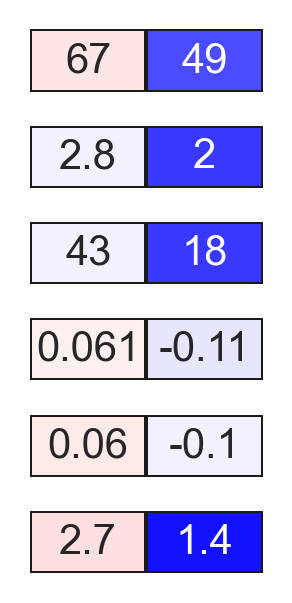

In [154]:
fig=plt.figure(figsize=(1,0.40*len(cats)))

for i,cat in enumerate(cats):
    p1=np.nanpercentile(clinical_order[cat],10)
    p3=np.nanpercentile(clinical_order[cat],90)
    sns_df=pd.DataFrame(clinical_order.groupby('HGEC').mean()[cat]).T
    sns_df.index=[cat]
    ax=fig.add_subplot(len(cats),1,i+1)
    sns.heatmap(sns_df,vmin=p1,vmax=p3,cmap=bwr,cbar=False,ax=ax,linecolor='k',linewidths=0.5,
           annot=sns_df,fmt='.2g' )
    ax.xaxis.set_ticks_position('top')
    ax.set_xlabel('')
    ax.set_yticks([])
    ax.set_xticks([])
    a=clinical_order[clinical_order['HGEC']==1][cat].dropna().values
    b=clinical_order[clinical_order['HGEC']==0][cat].dropna().values
    
    _,p1=kstest_normal(a)
    _,p2=kstest_normal(b)
    if (p1>0.05)&(p2>0.05):
        _,p=stats.ttest_ind(a,b,nan_policy='omit')
        print(cat,"T-test p=",p)
    else:
        _,p=stats.mannwhitneyu(a,b)
        print(cat,'MW test p=',p)
    
plt.subplots_adjust(hspace=0.55)

### ITI-based

In [155]:
Counter(clinical_order['HGEC2'])

Counter({0: 266, 1: 16})

In [156]:
cats=['Number','TP53_mut','BRCA12_alt','CCNE1_amp2','AKPP_mut']

HGEC2       0  1
TP53_mut        
0          34  7
1         232  9 Chi-sq p= 0.0006424746427066937
HGEC2         0   1
BRCA12_alt         
0           173  12
1            93   4 Fisher p= 0.5894916611906518
HGEC2         0   1
CCNE1_amp2         
0.0         222  15
1.0          44   1 Fisher p= 0.4819018568059192
HGEC2       0  1
AKPP_mut        
0         246  8
1          20  8 Chi-sq p= 3.4177573202451564e-08


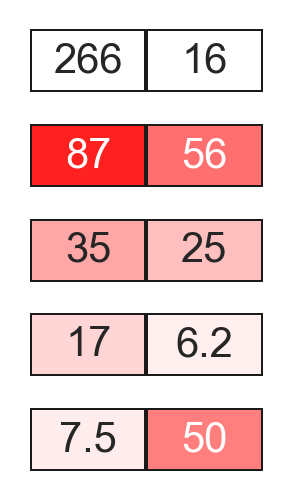

In [157]:
fig=plt.figure(figsize=(1,0.39*len(cats)))

for i,cat in enumerate(cats):
    ax=fig.add_subplot(len(cats),1,i+1)
    if i==0:
        sns_df=pd.DataFrame([[266,16]])
        sns.heatmap(data=sns_df,annot=sns_df,ax=ax,cbar=False,cmap=wk,
                    vmin=266,linecolor='k',linewidths=0.5,fmt='1d')
    else:
        ct=pd.crosstab(clinical_order['HGEC2'],clinical_order[cat]).T
        
        if np.min(np.array(ct))<5:
            p=stats.fisher_exact(ct)[1]
            print(ct,'Fisher p=',p)
        else:
            p=stats.chi2_contingency(ct,correction=False)[1]
            print(ct,'Chi-sq p=',p)
       
        sns_df=ct/np.sum(ct,axis=0)*100
        sns_df=pd.DataFrame(sns_df.iloc[1,:]).T
        sns.heatmap(sns_df,vmin=0,vmax=100,cmap=wr,cbar=False,ax=ax,linecolor='k',linewidths=0.5,
                   annot=sns_df)

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_yticks([])
    ax.set_xticks([])

plt.subplots_adjust(hspace=0.5)

In [158]:
cats=['HRD_score','ploidy','MATH','KEGG_CELL_CYCLE','HALLMARK_G2M_CHECKPOINT','WT1_log']

HRD_score MW test p= 0.1755956411020907
ploidy MW test p= 0.03273428361147881
MATH MW test p= 0.04416513839125935
KEGG_CELL_CYCLE MW test p= 0.21950080355781865
HALLMARK_G2M_CHECKPOINT MW test p= 0.23096829136975472
WT1_log MW test p= 0.020772686467135048


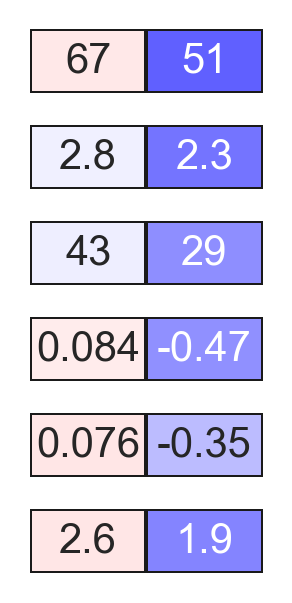

In [159]:
fig=plt.figure(figsize=(1,0.4*len(cats)))

for i,cat in enumerate(cats):
    p1=np.nanpercentile(clinical_order[cat],10)
    p3=np.nanpercentile(clinical_order[cat],90)
    sns_df=pd.DataFrame(clinical_order.groupby('HGEC2').mean()[cat]).T
    sns_df.index=[cat]
    ax=fig.add_subplot(len(cats),1,i+1)
    sns.heatmap(sns_df,vmin=p1,vmax=p3,cmap=bwr,cbar=False,ax=ax,linecolor='k',linewidths=0.5,
           annot=sns_df,fmt='.2g' )
    ax.xaxis.set_ticks_position('top')
    ax.set_xlabel('')
    ax.set_yticks([])
    ax.set_xticks([])
    a=clinical_order[clinical_order['HGEC2']==1][cat].dropna().values
    b=clinical_order[clinical_order['HGEC2']==0][cat].dropna().values
    _,p1=kstest_normal(a)
    _,p2=kstest_normal(b)
    if (p1>0.05)&(p2>0.05):
        _,p=stats.ttest_ind(a,b,nan_policy='omit')
        print(cat,"T-test p=",p)
    else:
        _,p=stats.mannwhitneyu(a,b)
        print(cat,'MW test p=',p)
    
plt.subplots_adjust(hspace=0.5)

### combined

In [160]:
Counter(clinical_order['HGEC_add'])

Counter({0: 257, 1: 25})

In [161]:
cats=['Number','TP53_mut','BRCA12_alt','CCNE1_amp2','AKPP_mut']

HGEC_add    0   1
TP53_mut         
0          30  11
1         227  14 Chi-sq p= 1.2006012615605673e-05
HGEC_add      0   1
BRCA12_alt         
0           167  18
1            90   7 Chi-sq p= 0.48060444794789126
HGEC_add      0   1
CCNE1_amp2         
0.0         215  22
1.0          42   3 Fisher p= 0.7768739701234026
HGEC_add    0   1
AKPP_mut         
0         241  13
1          16  12 Chi-sq p= 2.5988198120372078e-11


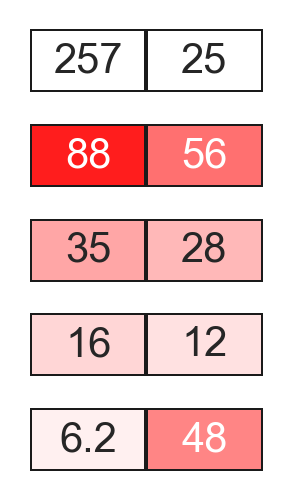

In [162]:
fig=plt.figure(figsize=(1,0.39*len(cats)))

for i,cat in enumerate(cats):
    ax=fig.add_subplot(len(cats),1,i+1)
    if i==0:
        sns_df=pd.DataFrame([[257,25]])
        sns.heatmap(data=sns_df,annot=sns_df,ax=ax,cbar=False,cmap=wk,
                    vmin=257,linecolor='k',linewidths=0.5,fmt='1d')
    else:
        ct=pd.crosstab(clinical_order['HGEC_add'],clinical_order[cat]).T
                
        if np.min(np.array(ct))<5:
            p=stats.fisher_exact(ct)[1]
            print(ct,'Fisher p=',p)
        else:
            p=stats.chi2_contingency(ct,correction=False)[1]
            print(ct,'Chi-sq p=',p)
       
        sns_df=ct/np.sum(ct,axis=0)*100
        sns_df=pd.DataFrame(sns_df.iloc[1,:]).T
        sns.heatmap(sns_df,vmin=0,vmax=100,cmap=wr,cbar=False,ax=ax,linecolor='k',linewidths=0.5,
                   annot=sns_df)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_yticks([])
    ax.set_xticks([])
    
plt.subplots_adjust(hspace=0.5)

In [163]:
cats=['HRD_score','ploidy','MATH','KEGG_CELL_CYCLE','HALLMARK_G2M_CHECKPOINT','WT1_log']

HRD_score MW test p= 0.049031130412590614
ploidy MW test p= 0.00011645480283196365
MATH MW test p= 0.00031694069963290796
KEGG_CELL_CYCLE MW test p= 0.2957556170847303
HALLMARK_G2M_CHECKPOINT T-test p= 0.12542980517245123
WT1_log MW test p= 0.0005316616007624648


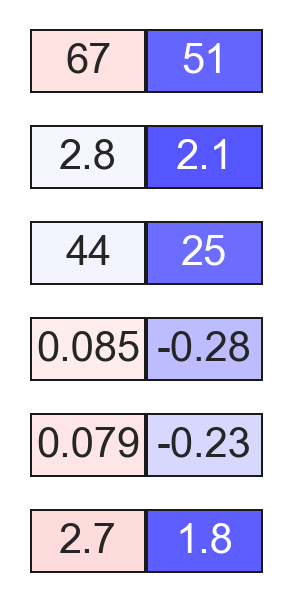

In [164]:
fig=plt.figure(figsize=(1,0.4*len(cats)))

for i,cat in enumerate(cats):
    p1=np.nanpercentile(clinical_order[cat],10)
    p3=np.nanpercentile(clinical_order[cat],90)
    sns_df=pd.DataFrame(clinical_order.groupby('HGEC_add').mean()[cat]).T
    sns_df.index=[cat]
    ax=fig.add_subplot(len(cats),1,i+1)
    sns.heatmap(sns_df,vmin=p1,vmax=p3,cmap=bwr,cbar=False,ax=ax,linecolor='k',linewidths=0.5,
           annot=sns_df,fmt='.2g' )
    ax.xaxis.set_ticks_position('top')
    ax.set_xlabel('')
    ax.set_yticks([])
    ax.set_xticks([])
    a=clinical_order[clinical_order['HGEC_add']==1][cat].dropna().values
    b=clinical_order[clinical_order['HGEC_add']==0][cat].dropna().values
    _,p1=kstest_normal(a)
    _,p2=kstest_normal(b)
    if (p1>0.05)&(p2>0.05):
        _,p=stats.ttest_ind(a,b,nan_policy='omit')
        print(cat,"T-test p=",p)
    else:
        _,p=stats.mannwhitneyu(a,b)
        print(cat,'MW test p=',p)
    
plt.subplots_adjust(hspace=0.5)

## Clinical features

[0 0 0 0 0 0 0 0 0 0] ['C1', 'C2', 'C3', 'C4']
KM plot stratified by cluster_c
cluster_c multivariate log rank p= 0.025311810656292358


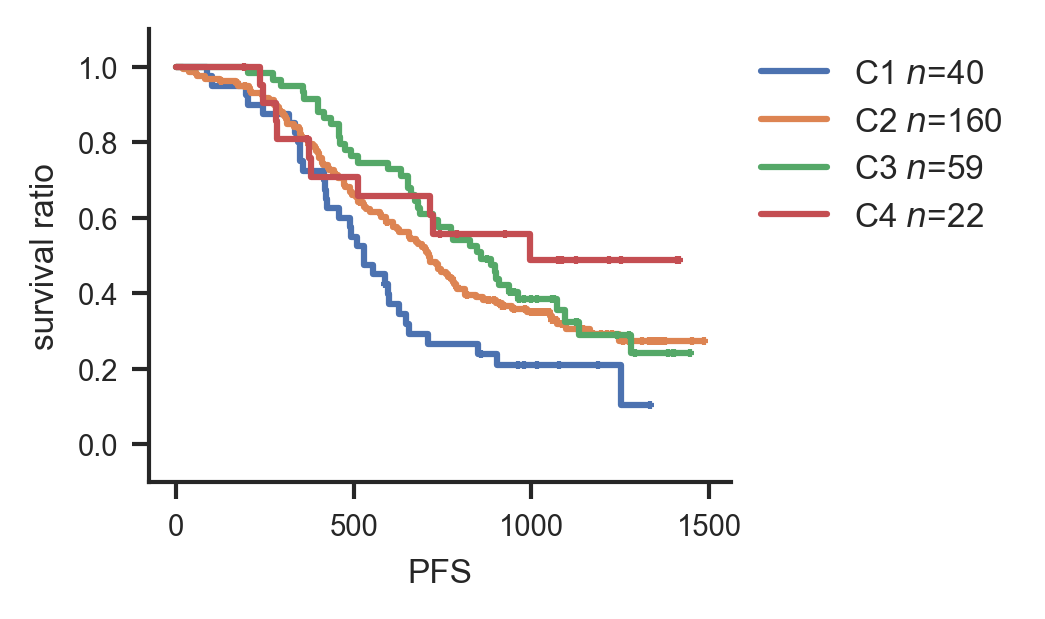

In [165]:
plt_df=clinical_order#[clinical2['cluster'].isin(['HGSC','Endo_G1', 'Endo_G2', 'Endo_G3'])]
group_order=['C1','C2','C3','C4']#,'C5']
fig=plt.figure(figsize=(2.5,2))
ax=fig.add_subplot(111)
KMcurve(data=plt_df, category='cluster_c',duration='PFS',event='Prog',ax=ax,group_order=group_order,linewidth=1.5)
ax.set_ylim(-0.1,1.1)
ax.legend(bbox_to_anchor=(1,1))

[0 0 0 0 0 0 0 0 0 0] ['C1', 'C2', 'C3', 'C4']
KM plot stratified by cluster_c
cluster_c multivariate log rank p= 0.02109515893931198


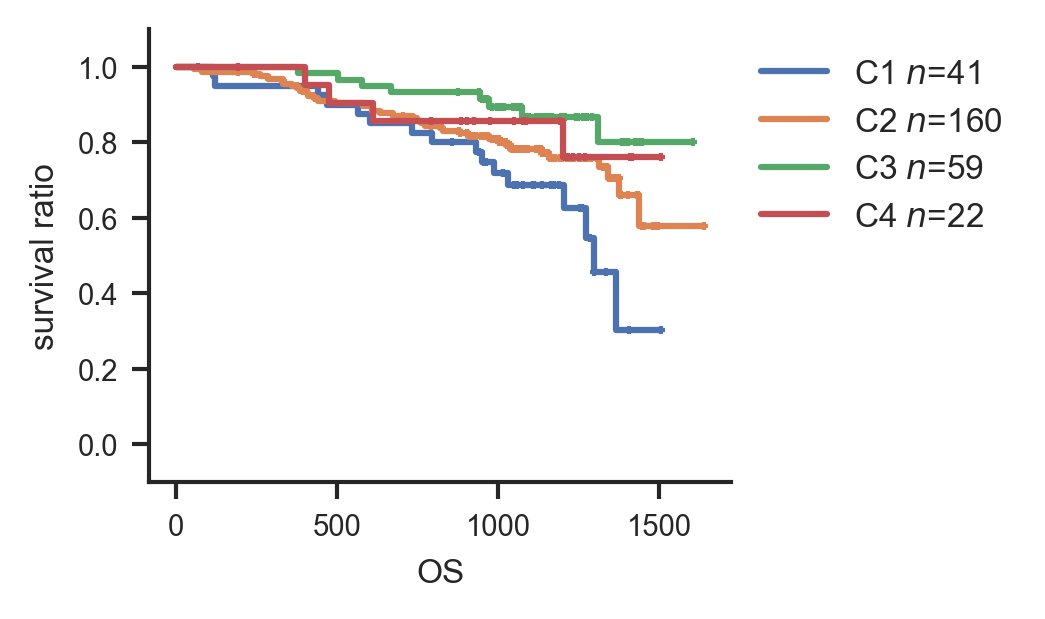

In [166]:
plt_df=clinical_order#[clinical2['cluster'].isin(['HGSC','Endo_G1', 'Endo_G2', 'Endo_G3'])]
group_order=['C1','C2','C3','C4']#,'C5']
fig=plt.figure(figsize=(2.5,2))
ax=fig.add_subplot(111)
KMcurve(data=plt_df, category='cluster_c',duration='OS',event='Death',ax=ax,group_order=group_order,linewidth=1.5)
ax.set_ylim(-0.1,1.1)
ax.legend(bbox_to_anchor=(1,1))

[0 0 0 0 0 0 0 0 0 0] ['C1', 'C2', 'C3', 'C4']
KM plot stratified by cluster_c
cluster_c multivariate log rank p= 0.036478558812150355


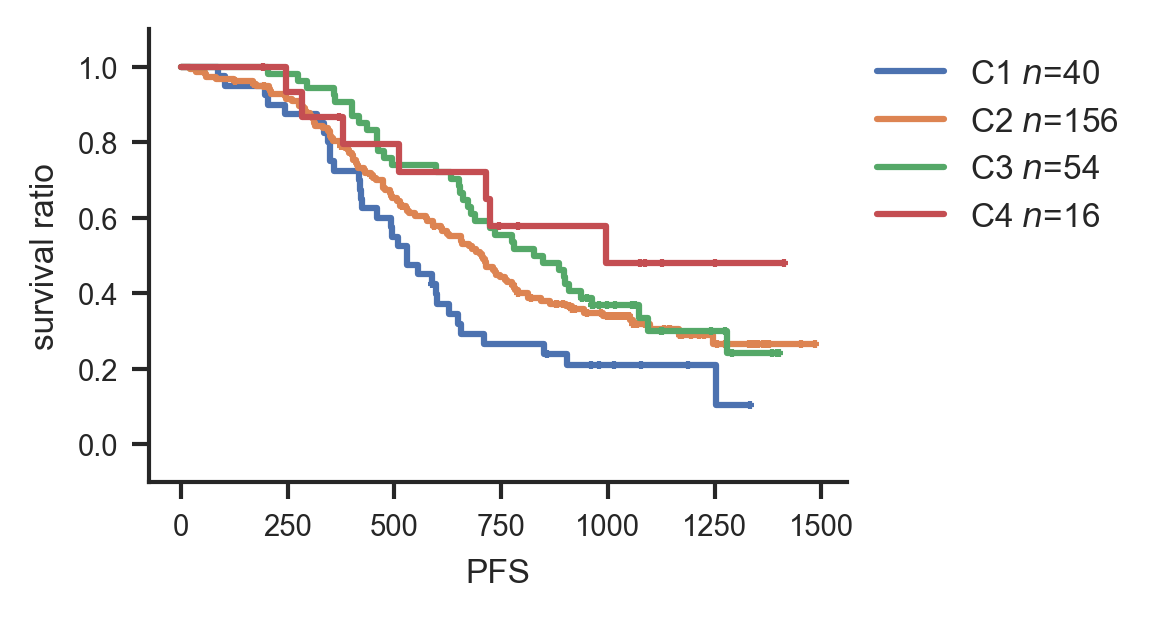

In [167]:
plt_df=clinical_order[clinical_order['HGSC']==1]#[clinical2['cluster'].isin(['HGSC','Endo_G1', 'Endo_G2', 'Endo_G3'])]
group_order=['C1','C2','C3','C4']#,'C5']
fig=plt.figure(figsize=(3,2))
ax=fig.add_subplot(111)
KMcurve(data=plt_df, category='cluster_c',duration='PFS',event='Prog',ax=ax,group_order=group_order,linewidth=1.5)
ax.set_ylim(-0.1,1.1)
ax.legend(bbox_to_anchor=(1,1))

[0 0 0 0 0 0 0 0 0 0] ['C1', 'C2', 'C3', 'C4']
KM plot stratified by cluster_c
cluster_c multivariate log rank p= 0.03095532274444181


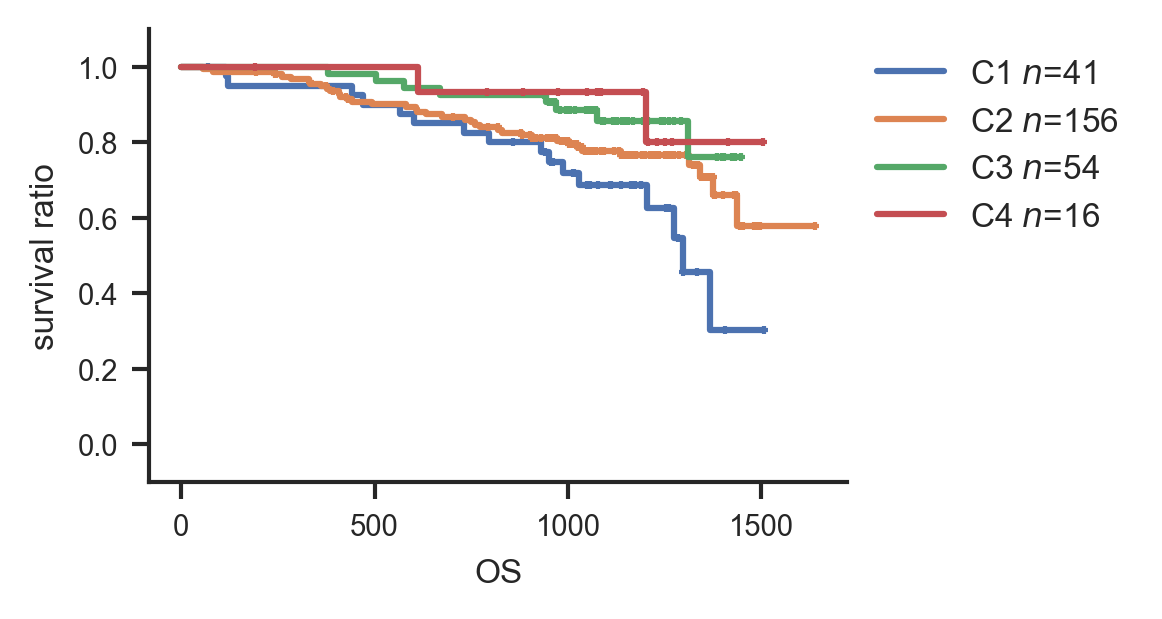

In [168]:
plt_df=clinical_order[clinical_order['HGSC']==1]#[clinical2['cluster'].isin(['HGSC','Endo_G1', 'Endo_G2', 'Endo_G3'])]
group_order=['C1','C2','C3','C4']#,'C5']
fig=plt.figure(figsize=(3,2))
ax=fig.add_subplot(111)
KMcurve(data=plt_df, category='cluster_c',duration='OS',event='Death',ax=ax,group_order=group_order,linewidth=1.5)
ax.set_ylim(-0.1,1.1)
ax.legend(bbox_to_anchor=(1,1))

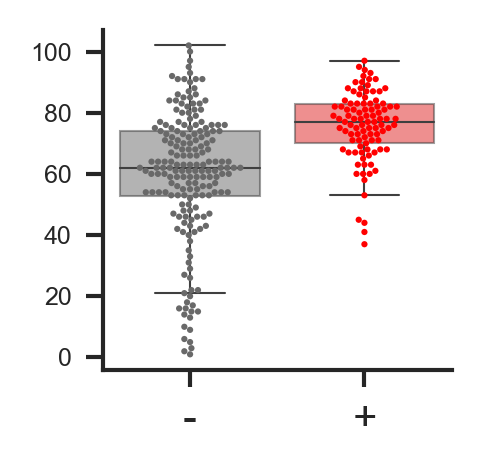

In [169]:
flag="BRCA12_alt"
value="HRD_score"
plt_df=clinical_esr.copy()
cat=flag
val=value
#order=[]
#hue=
palette=['dimgrey','red']
fig=plt.figure(figsize=(1.5,1.5))
ax=fig.add_subplot(1,1,1)
sns.boxplot(x=cat,y=val,data=plt_df,boxprops={'alpha':0.5},sym='',palette=palette)#,order=order,hue=hue,)
sns.swarmplot(x=cat,y=val,data=plt_df,s=1.5,palette=palette)#,order=order,hue=hue,dodge=True,palette=palette)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels(['-','+'])
ax.tick_params('x',labelsize=10)
ax.tick_params('y',labelsize=6)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


Sensitivity = 0.845,　Specificity = 0.383,　Threshold = 67, AUC = 0.758
Sensitivity = 0.742,　Specificity = 0.319,　Threshold = 71, AUC = 0.758


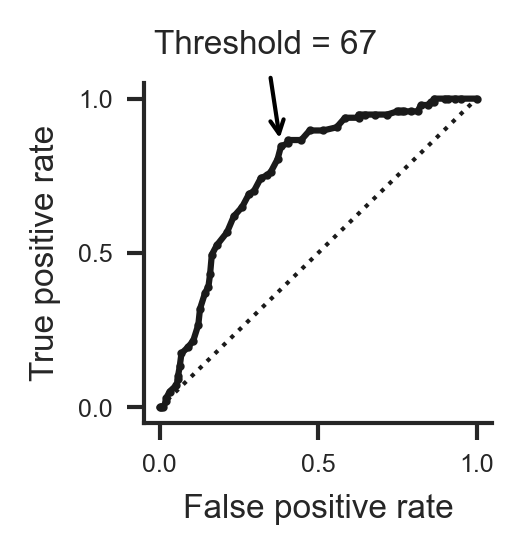

In [170]:
from sklearn.metrics import roc_curve,roc_auc_score,auc

flag="BRCA12_alt"
value="HRD_score"
plt_df=clinical_esr.copy()

plt_df=plt_df.loc[:,[flag,value]].dropna()
y_true=plt_df[flag]
y_score=plt_df[value]
fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc=roc_auc_score(y_true, y_score)

# Youdan index
yd_idx = np.argmax( abs(tpr -fpr) )
yd_threshold = thresholds[yd_idx]
print("Sensitivity = {:.3f},　Specificity = {:.3f},　Threshold = {:.3g}, AUC = {:.3f}".format(tpr[yd_idx],fpr[yd_idx],yd_threshold,auc))
# Optimal index
op_idx = np.argmin( (1-tpr)**2 + fpr**2)
op_threshold = thresholds[op_idx]
print("Sensitivity = {:.3f},　Specificity = {:.3f},　Threshold = {:.3g}, AUC = {:.3f}".format(tpr[op_idx],fpr[op_idx],thresholds[op_idx],auc))

# plot with Threshold
fig=plt.figure(figsize=(1.5,1.5))
ax=fig.add_subplot(111)
ax.plot(fpr, tpr, marker='o',ms=1,c='k',lw=1.5)
ax.set_xlabel('False positive rate',fontsize=8)
ax.set_ylabel('True positive rate',fontsize=8)
ax.plot( np.linspace(0,1), np.linspace(0,1), c="k",ls="dotted",lw=1)

arrow_dict = dict(color = "black",arrowstyle = "->",) #shrink=0.1,width=0,
ax.annotate("Threshold = {:.3g}".format(thresholds[yd_idx]),xy=(fpr[yd_idx],tpr[yd_idx]),
             size=8,xytext=(fpr[yd_idx]-0.4,tpr[yd_idx]+0.3), arrowprops = arrow_dict )

ax.set_xticks([0,0.5,1])
ax.set_yticks([0,0.5,1])
ax.tick_params(labelsize=6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [171]:
cat=[]
for idx in clinical_order.index:
    if clinical_order.loc[idx,'BRCA12_alt']==1:
        cat.append('HRD')
    elif  clinical_order.loc[idx,'HRD_score']>67:
        cat.append('HRD')
    elif clinical_order.loc[idx,'cluster_c']=='C4':
        cat.append('nonHRD_C4')
    else:
        cat.append('nonHRD_nonC4')
clinical_order['cat5']=cat

[0 1 1 1 1 1 1 1 1 0] ['HRD', 'nonHRD_nonC4', 'nonHRD_C4']
KM plot stratified by cat5
cat5 multivariate log rank p= 0.0013891988431604314


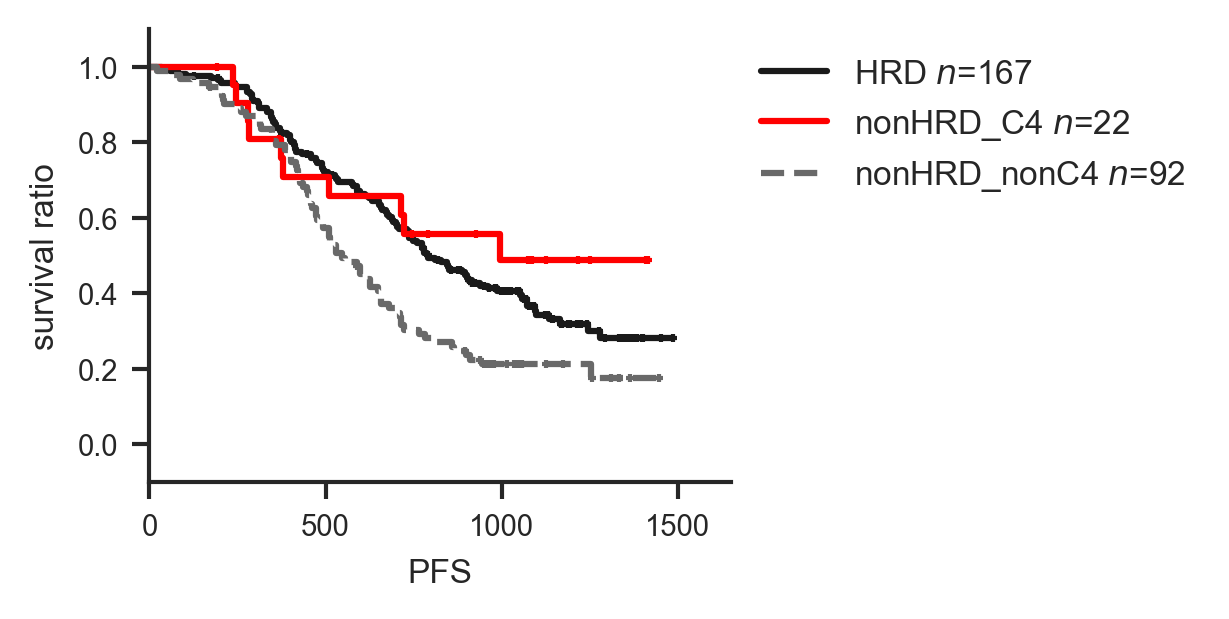

In [172]:
plt_df=clinical_order
fig=plt.figure(figsize=(2.5,2))
ax=fig.add_subplot(111)
group_order=['HRD',  'nonHRD_C4','nonHRD_nonC4']
KMcurve(data=plt_df, category='cat5',duration='PFS',event='Prog',ax=ax,group_order=group_order,
       colors=['k','red','dimgrey'],linewidth=1.5,linestyle=['solid','solid','dashed'])
ax.set_xlim(0,1650)
ax.set_ylim(-0.1,1.1)
ax.legend(bbox_to_anchor=(1,1))

[0 1 1 1 1 1 1 1 1 1] ['HRD', 'nonHRD_nonC4', 'nonHRD_C4']
KM plot stratified by cat5
cat5 multivariate log rank p= 0.009235488381553993


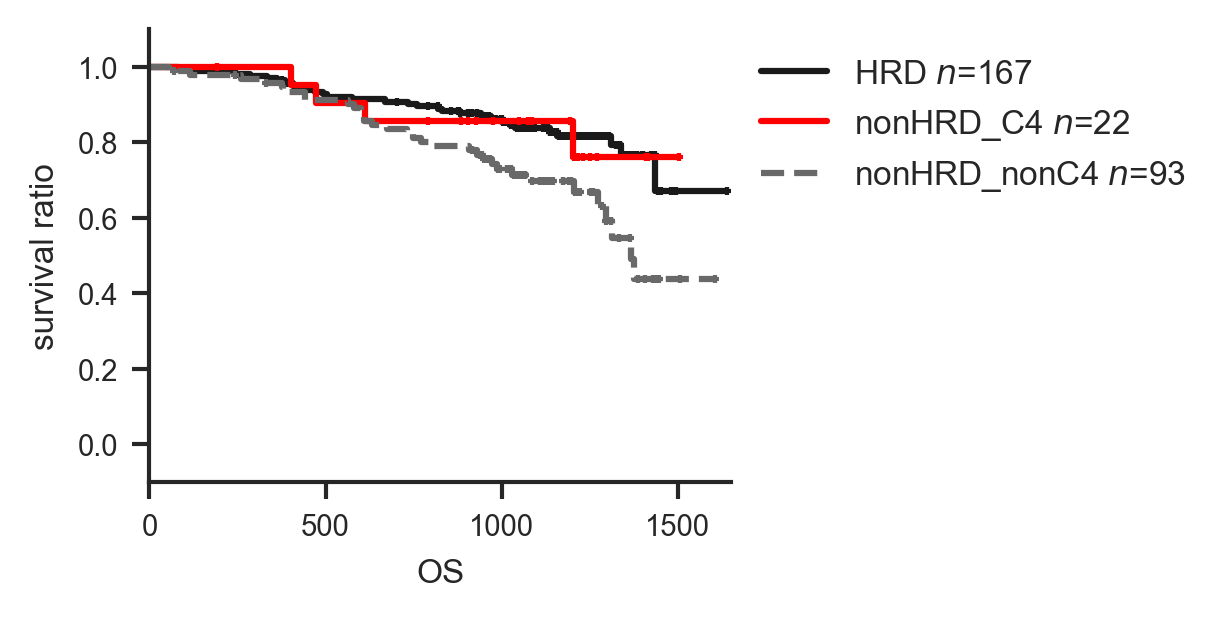

In [173]:
plt_df=clinical_order
fig=plt.figure(figsize=(2.5,2))
ax=fig.add_subplot(111)
group_order=['HRD',  'nonHRD_C4','nonHRD_nonC4']
KMcurve(data=plt_df, category='cat5',duration='OS',event='Death',ax=ax,group_order=group_order,
       colors=['k','red','dimgrey'],linewidth=1.5,linestyle=['solid','solid','dashed'])
ax.set_xlim(0,1650)
ax.set_ylim(-0.1,1.1)
ax.legend(bbox_to_anchor=(1,1))

In [174]:
cat=[]
for idx in clinical_order.index:
    if clinical_order.loc[idx,'HGEC']==1:
        cat.append('HGEC')
    elif clinical_order.loc[idx,'BRCA12_alt']==1:
        cat.append('HGSC_HRD')
    elif  clinical_order.loc[idx,'HRD_score']>67:
        cat.append('HGSC_HRD')
    elif clinical_order.loc[idx,'cluster_c']=='C4':
        cat.append('HGSC_nonHRD_C4')
    else:
        cat.append('HGSC_nonHRD_nonC4')
clinical_order['cat6']=cat

[0 1 1 1 1 1 1 1 1 0] ['HGSC_HRD', 'HGSC_nonHRD_nonC4', 'HGEC', 'HGSC_nonHRD_C4']
KM plot stratified by cat6
cat6 multivariate log rank p= 0.0005434051666702228


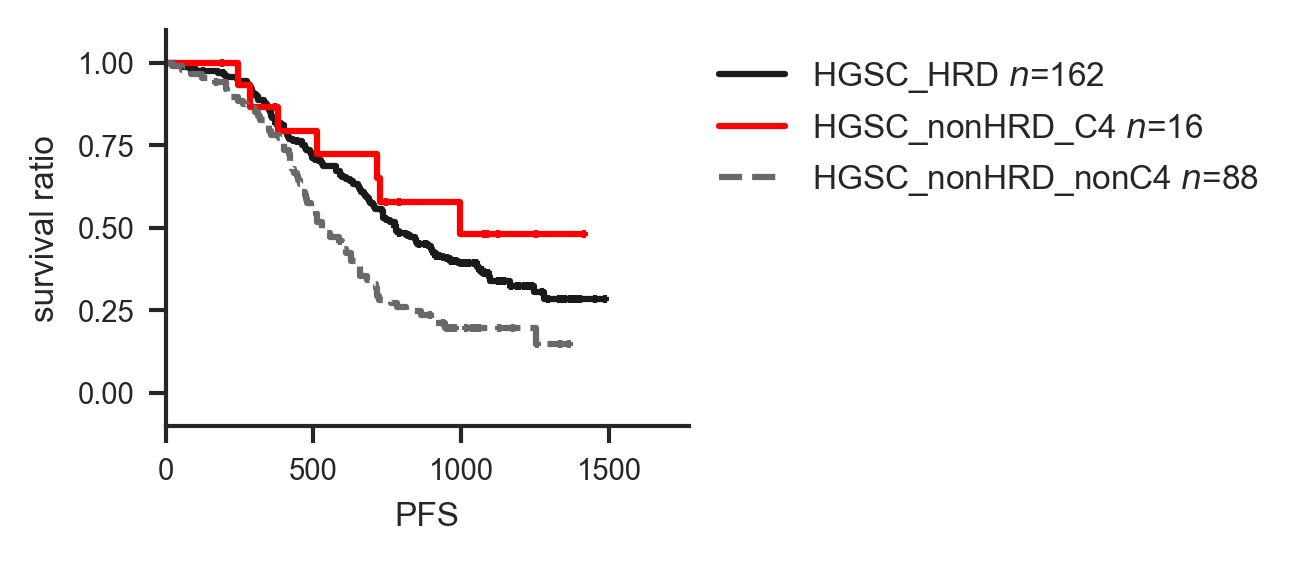

In [175]:
plt_df=clinical_order
fig=plt.figure(figsize=(2.25,1.75))
ax=fig.add_subplot(111)
group_order=['HGSC_HRD',  'HGSC_nonHRD_C4','HGSC_nonHRD_nonC4']
KMcurve(data=plt_df, category='cat6',duration='PFS',event='Prog',ax=ax,group_order=group_order,
       colors=['k','red','dimgrey'],linewidth=1.5,linestyle=['solid','solid','dashed'])
ax.set_xlim(0,1770)
ax.set_ylim(-0.1,1.1)
ax.legend(bbox_to_anchor=(1,1))

[0 1 1 1 1 1 1 1 1 1] ['HGSC_HRD', 'HGSC_nonHRD_nonC4', 'HGEC', 'HGSC_nonHRD_C4']
KM plot stratified by cat6
cat6 multivariate log rank p= 0.003858545965318076


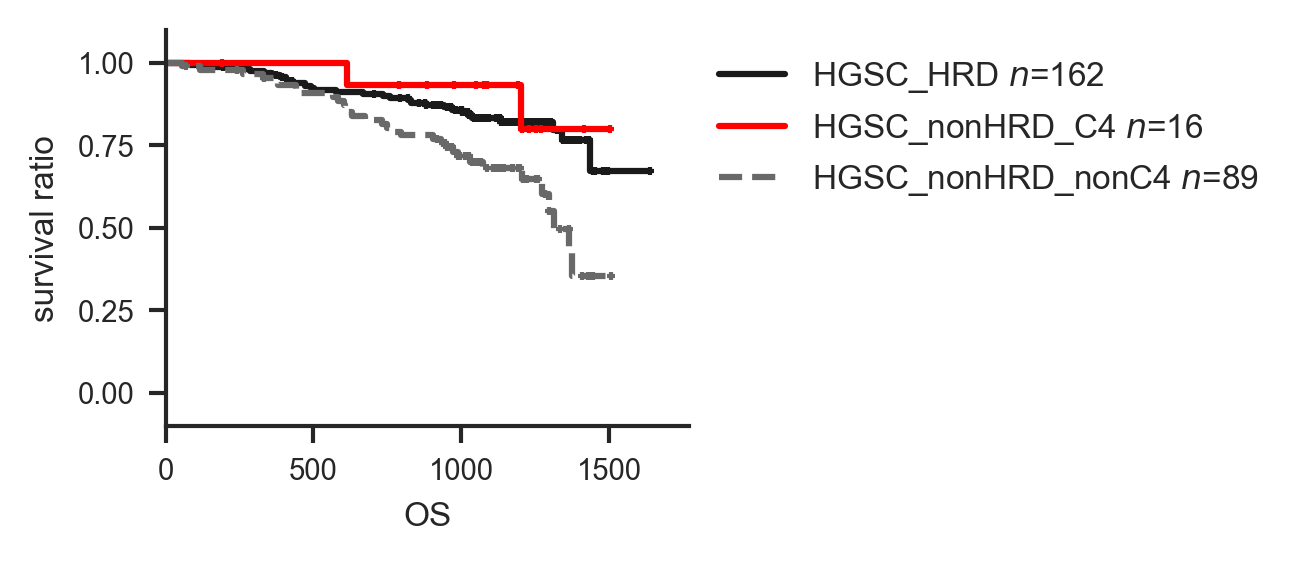

In [176]:
plt_df=clinical_order
fig=plt.figure(figsize=(2.25,1.75))
ax=fig.add_subplot(111)
group_order=['HGSC_HRD',  'HGSC_nonHRD_C4','HGSC_nonHRD_nonC4']
KMcurve(data=plt_df, category='cat6',duration='OS',event='Death',ax=ax,group_order=group_order,
       colors=['k','red','dimgrey'],linewidth=1.5,linestyle=['solid','solid','dashed'])
ax.set_xlim(0,1770)
ax.set_ylim(-0.1,1.1)
ax.legend(bbox_to_anchor=(1,1))

# EM/FT signature

In [177]:
met_sig_up=pd.read_csv('../code/EM_FT_methylation/Methyl-ssRSEA/JGOG3025_EM_FT_UP_score.txt',sep='\t',index_col=0)
met_sig_dn=pd.read_csv('../code/EM_FT_methylation/Methyl-ssRSEA/JGOG3025_FT_EM_UP_score.txt',sep='\t',index_col=0)
met_sig=pd.concat([met_sig_up,met_sig_dn],axis=1)
met_sig['GSE186458_EM_FT_metsig']=met_sig['GSE186458_EM_FT_UP']-met_sig['GSE186458_FT_EM_UP']
met_sig

GSE186458_EM_FT_UP  GSE186458_FT_EM_UP  GSE186458_EM_FT_metsig
R0001       -66194.334361        84081.833844          -150276.168205
R0003       -45365.666300       118804.755216          -164170.421516
R0004       -38805.093099       142936.972442          -181742.065541
R0006       -80789.426507       119638.466732          -200427.893239
R0011        50563.095425       118374.734700           -67811.639276
...                   ...                 ...                     ...
R0704       -25635.546914       127087.654123          -152723.201036
R0706         5309.863783        83487.148613           -78177.284830
R0707       -15162.034912       120525.934011          -135687.968923
R0709       -41251.038701       128441.613209          -169692.651910
R0710       -40199.401682       113998.491441          -154197.893123

[285 rows x 3 columns]

In [178]:
sil_sig=pd.read_csv('../code/EM_FT_methylation/ssGSEA/JGOG_EM_FT_promotor_genes_ssgsea_score_z.txt',sep='\t',index_col=0).T
sil_sig.columns=[x+'_ssgsea' for x in sil_sig.columns]

In [179]:
clinical_order=clinical_order.merge(met_sig,left_index=True,right_index=True,how='left')
clinical_order=clinical_order.merge(sil_sig,left_index=True,right_index=True,how='left')

MW test p= 0.00014345780043629623


Text(0.5, 1.0, 'EM/FT methylation score')

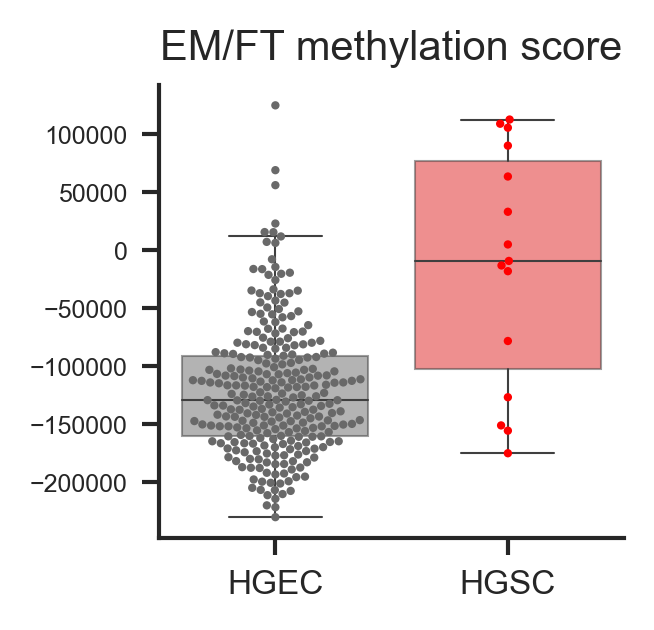

In [180]:
plt_df=clinical_order
cat='HGEC'
val='GSE186458_EM_FT_metsig'
#order=[]
hue='TP53_mut'
palette=['dimgrey','red']
fig=plt.figure(figsize=(2,2))
ax=fig.add_subplot(1,1,1)
sns.boxplot(x=cat,y=val,data=plt_df,boxprops={'alpha':0.5},sym='',palette=palette)#,order=orderpalette=palette)
sns.swarmplot(x=cat,y=val,data=plt_df,s=2,palette=palette)#,order=order,hue=hue,dodge=True,palette=palette)

a=plt_df[plt_df[cat]==1][val].dropna()
b=plt_df[plt_df[cat]==0][val].dropna()
_,p1=kstest_normal(a)
_,p2=kstest_normal(b)

if (p1>0.05)&(p2>0.05):
    _,p=stats.ttest_ind(a,b,nan_policy='omit')
    print("T-test p=",p)
else:
    _,p=stats.mannwhitneyu(a,b)
    print('MW test p=',p)

ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(labelsize=6)
ax.set_xticklabels(['HGEC','HGSC'],fontsize=8)
ax.spines['right' ].set_visible(False)
ax.spines['top' ].set_visible(False)
ax.set_title('EM/FT methylation score',fontsize=10)


MW test p= 0.0009973792558552548


Text(0.5, 1.0, 'EM/FT methylation score')

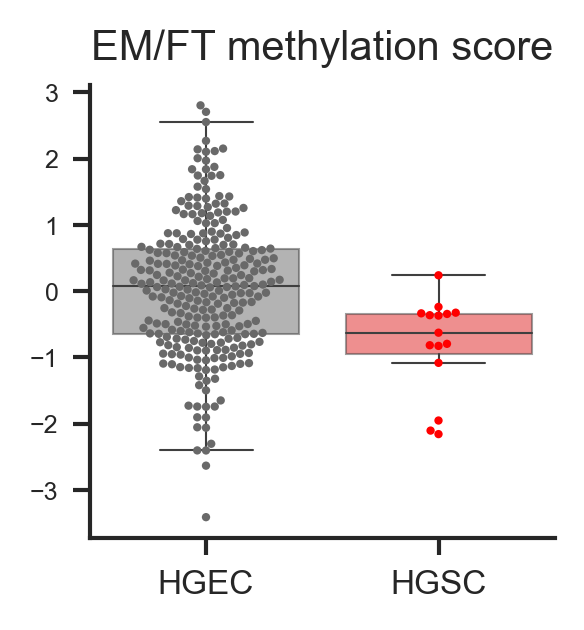

In [181]:
plt_df=clinical_order
cat='HGEC'
val='GSE186458_EM_FT_ssgsea'
#order=[]
hue='TP53_mut'
palette=['dimgrey','red']
fig=plt.figure(figsize=(2,2))
ax=fig.add_subplot(1,1,1)
sns.boxplot(x=cat,y=val,data=plt_df,boxprops={'alpha':0.5},sym='',palette=palette)#,order=orderpalette=palette)
sns.swarmplot(x=cat,y=val,data=plt_df,s=2,palette=palette)#,order=order,hue=hue,dodge=True,palette=palette)

a=plt_df[plt_df[cat]==1][val].dropna()
b=plt_df[plt_df[cat]==0][val].dropna()
_,p1=kstest_normal(a)
_,p2=kstest_normal(b)

if (p1>0.05)&(p2>0.05):
    _,p=stats.ttest_ind(a,b,nan_policy='omit')
    print("T-test p=",p)
else:
    _,p=stats.mannwhitneyu(a,b)
    print('MW test p=',p)

ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(labelsize=6)
ax.set_xticklabels(['HGEC','HGSC'],fontsize=8)
ax.spines['right' ].set_visible(False)
ax.spines['top' ].set_visible(False)
ax.set_title('EM/FT methylation score',fontsize=10)


GSE186458_EM_FT_metsig MW test p= 9.632461290067346e-10
GSE186458_EM_FT_ssgsea T-test p= 0.0017415535773056595


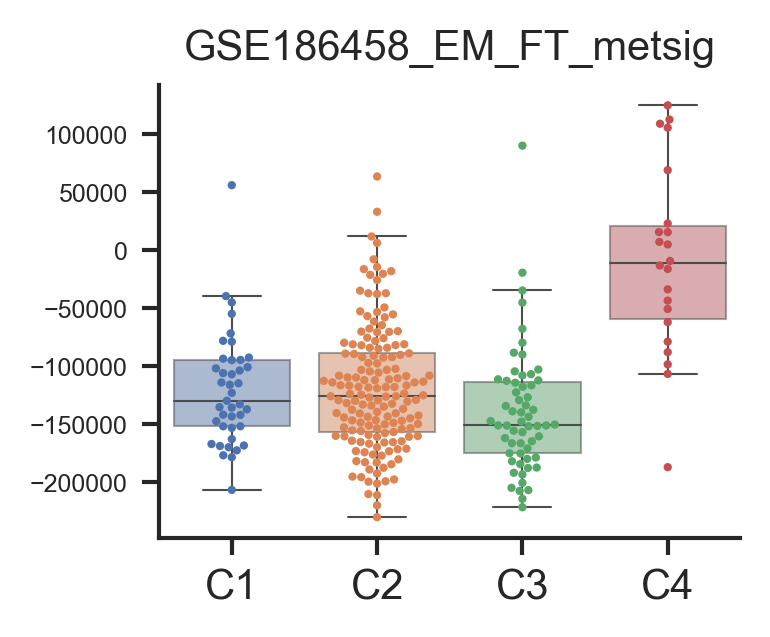

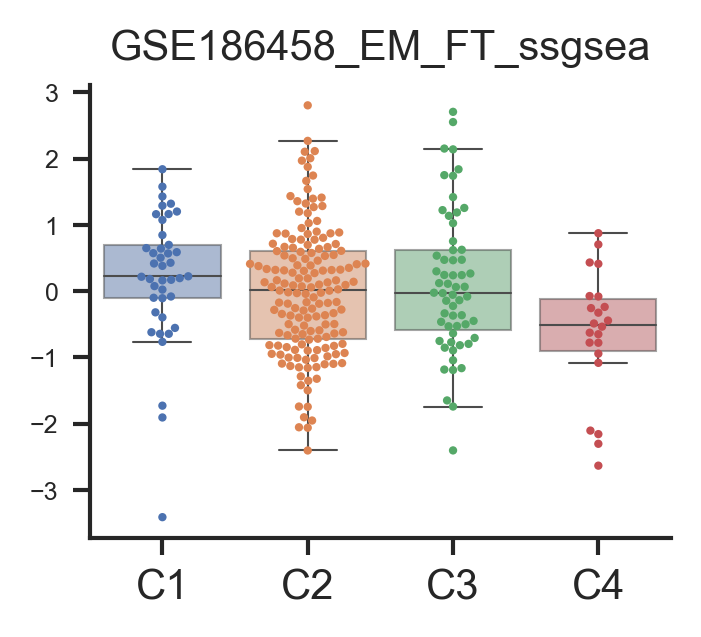

In [182]:
vals=['GSE186458_EM_FT_metsig','GSE186458_EM_FT_ssgsea'
     ]
for val in vals:
    plt_df=clinical_order
    cat='cluster_c'
    c_order=['C1','C2','C3','C4']
    fig=plt.figure(figsize=(2.5,2))
    ax=fig.add_subplot(1,1,1)
    sns.boxplot(x=cat,y=val,data=plt_df,boxprops={'alpha':0.5},sym='',order=c_order)#,hue=hue,palette=palette)
    sns.swarmplot(x=cat,y=val,data=plt_df,s=2,order=c_order)#,order=order,hue=hue,dodge=True,palette=palette)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(val,fontsize=10)
    ax.tick_params('y',labelsize=6)
    ax.tick_params('x',labelsize=10)
    
    ax.spines['top'   ].set_visible(False)# .set_color("w")
    ax.spines['right' ].set_visible(False)
    ax.legend([])
    
    a=plt_df[plt_df[cat]=='C4'][val].dropna().values
    b=plt_df[plt_df[cat].isin(['C1','C2','C3'])][val].dropna().values
    _,p1=kstest_normal(a)
    _,p2=kstest_normal(b)
    if (p1>0.05)&(p2>0.05):
        _,p=stats.ttest_ind(a,b,nan_policy='omit')
        print(val,"T-test p=",p)
    else:
        _,p=stats.mannwhitneyu(a,b)
        print(val,'MW test p=',p)

In [183]:
met_sil=pd.concat([met_sig_up,met_sig_dn,sil_sig],axis=1,join='inner')
met_sil['GSE186458_EM_FT_metsig']=met_sil['GSE186458_EM_FT_UP']-met_sil['GSE186458_FT_EM_UP']

r = -0.405, p = 1.151e-12
SpearmanrResult(correlation=-0.37563946084865024, pvalue=5.55371120530449e-11)


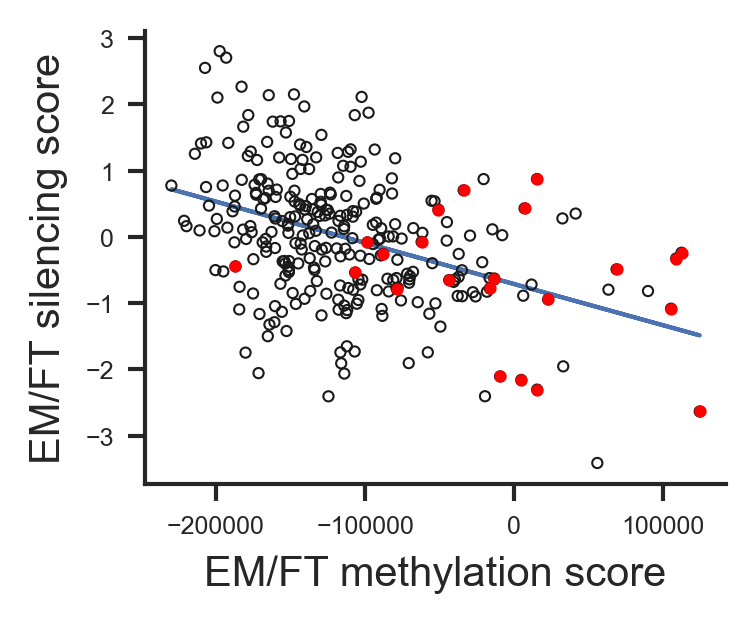

In [184]:
plt_df=met_sil.copy()
#plt_df=plt_df[plt_df[cat]=='']
val1,val2='GSE186458_EM_FT_metsig','GSE186458_EM_FT_ssgsea'
plt_df=plt_df[[val1,val2]].dropna()
x,y=plt_df[val1],plt_df[val2]

fig=plt.figure(figsize=(2.5,2))
ax=fig.add_subplot(111)
ax.scatter(x,y,s=6,ec='k',fc='None',lw=0.5)
ax.set_xlabel('EM/FT methylation score',fontsize=10)
ax.set_ylabel('EM/FT silencing score',fontsize=10)
ax.tick_params(labelsize=6)

# linear regression, Pearson correlation

plt_df2=clinical_order[clinical_order['cluster_c']=='C4']
plt_df2=plt_df2[[val1,val2]].dropna()
x2,y2=plt_df2[val1],plt_df2[val2]
ax.scatter(x2,y2,s=6,ec='red',fc='red',lw=0.5)

# linear regression, Pearson correlation

ax.spines['top'   ].set_visible(False)# .set_color("w")
ax.spines['right' ].set_visible(False)
ax.legend([])

lr=stats.linregress(x,y)
a,b,r,p=lr.slope,lr.intercept, lr.rvalue,lr.pvalue
ax.plot(x,a*x+b,lw=1,zorder=0)
print('r = {:.3f}, p = {:.3e}'.format(r,p))
print(stats.spearmanr(x,y))

# Machine learning

## JGOG internal validation

In [185]:
cnv_jgog=pd.read_csv('../data/JGOG_282_ascat_spmg.CNV48.matrix.txt'
                     ,sep='\t',index_col=0)
cnv_jgog_r=cnv_jgog.apply(lambda x: x/np.sum(x),axis=1)
np.sum(cnv_jgog)

0:homdel:0-100kb        182
0:homdel:100kb-1Mb      995
0:homdel:>1Mb          1792
1:LOH:0-100kb           376
1:LOH:100kb-1Mb        2579
1:LOH:1Mb-10Mb         6567
1:LOH:10Mb-40Mb        4167
1:LOH:>40Mb             781
2:LOH:0-100kb           385
2:LOH:100kb-1Mb        3430
2:LOH:1Mb-10Mb         5748
2:LOH:10Mb-40Mb        1242
2:LOH:>40Mb             138
3-4:LOH:0-100kb         423
3-4:LOH:100kb-1Mb      2574
3-4:LOH:1Mb-10Mb       3482
3-4:LOH:10Mb-40Mb       740
3-4:LOH:>40Mb            55
5-8:LOH:0-100kb         142
5-8:LOH:100kb-1Mb       657
5-8:LOH:1Mb-10Mb        735
5-8:LOH:10Mb-40Mb       111
5-8:LOH:>40Mb             3
9+:LOH:0-100kb           34
9+:LOH:100kb-1Mb        139
9+:LOH:1Mb-10Mb          45
9+:LOH:10Mb-40Mb          1
9+:LOH:>40Mb              0
2:het:0-100kb           168
2:het:100kb-1Mb        2524
2:het:1Mb-10Mb         6385
2:het:10Mb-40Mb        3392
2:het:>40Mb            1136
3-4:het:0-100kb         595
3-4:het:100kb-1Mb      4935
3-4:het:1Mb-10Mb    

In [186]:
X=cnv_jgog_r.loc[clinical_order.index,:]
y=clinical_order['cluster_c_int']

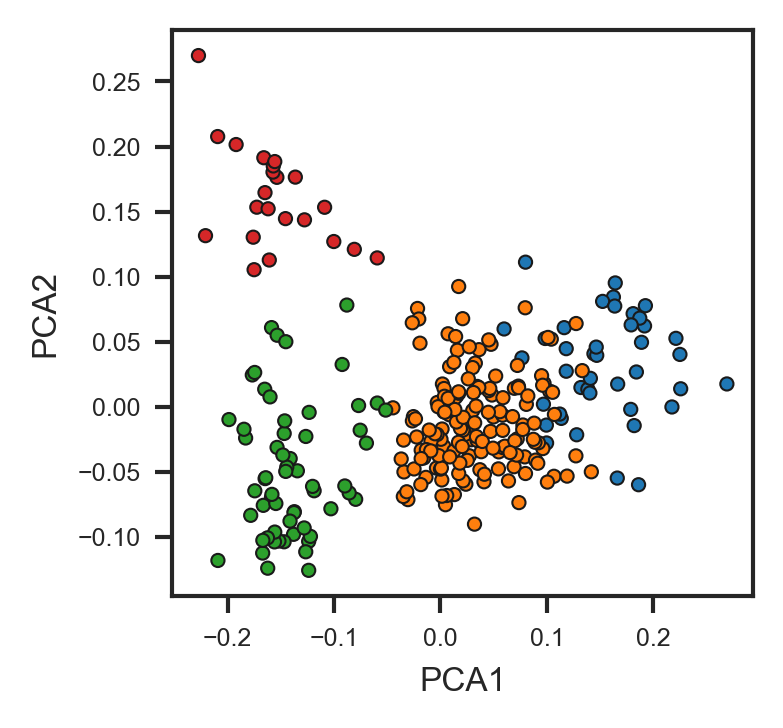

In [187]:
### pca
from sklearn.decomposition import PCA

data=X
pca =PCA(n_components=2)
pca.fit(data)
X2=pca.transform(data)

colors=y.replace({0:'tab:blue',1:'tab:orange',2:'tab:green',3:'tab:red'})

# plot
fig = plt.figure(figsize=(2.5,2.5))
ax = fig.add_subplot(1,1,1)    
ax.scatter(X2[:, 0], X2[:, 1],ec='k',fc=colors,s=10,lw=0.5)

ax.set_xlabel("PCA1",fontsize=8)
ax.set_ylabel("PCA2",fontsize=8)
ax.tick_params(labelsize=6)  

In [188]:
loo = LeaveOneOut()
adds=[]

for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    rc=RF(random_state=1,max_depth=3,class_weight='balanced')
    sc=SVC(random_state=1,class_weight='balanced')
    xc=XGB(random_state=1,use_label_encoder=False,eval_metric='mlogloss')
    kc=KN(n_neighbors=5)
    mc=MLP(random_state=1,max_iter=1000)
    
    rc.fit(X_train, y_train)
    xc.fit(X_train, y_train)
    sc.fit(X_train, y_train)
    kc.fit(X_train, y_train)
    mc.fit(X_train, y_train)
    
    y_pred_rc=rc.predict(X_test)
    y_pred_xc=xc.predict(X_test)
    y_pred_sc=sc.predict(X_test)
    y_pred_kc=kc.predict(X_test)
    y_pred_mc=mc.predict(X_test)
         
    add=pd.DataFrame(y_test)
    add['RFC']=y_pred_rc
    add['SVM']=y_pred_sc
    add['KNN']=y_pred_kc
    add['XGB']=y_pred_xc
    add['MLP']=y_pred_mc
    adds.append(add)

In [189]:
tmp1=pd.concat(adds)
tmp1

cluster_c_int  RFC  SVM  KNN  XGB  MLP
R0194              0    0    0    0    0    0
R0204              0    0    0    0    0    0
R0627              0    0    0    0    0    0
R0214              0    0    0    0    0    0
R0316              0    0    0    0    0    0
...              ...  ...  ...  ...  ...  ...
R0432              3    3    3    3    3    3
R0571              3    3    3    3    3    3
R0642              3    2    3    2    2    2
R0281              3    3    3    3    3    3
R0307              3    3    3    3    3    3

[282 rows x 6 columns]

In [190]:
for clf in tmp1.columns[1:]:
    cm=pd.DataFrame(metrics.confusion_matrix(tmp1['cluster_c_int'],tmp1[clf]))
    cm.index=['C'+str(i) for i in range(1,5)]
    cm.columns=['pC'+str(i) for i in range(1,5)]
    print(clf)
    display(cm)
    acs=metrics.accuracy_score(tmp1['cluster_c_int'],tmp1[clf])
    print(acs)

RFC


pC1  pC2  pC3  pC4
C1   37    4    0    0
C2    2  154    1    3
C3    0    5   54    0
C4    0    0    1   21

0.9432624113475178
SVM


pC1  pC2  pC3  pC4
C1   41    0    0    0
C2    4  156    0    0
C3    0    1   58    0
C4    0    0    0   22

0.9822695035460993
KNN


pC1  pC2  pC3  pC4
C1   34    7    0    0
C2    0  160    0    0
C3    0    3   56    0
C4    0    0    1   21

0.9609929078014184
XGB


pC1  pC2  pC3  pC4
C1   37    4    0    0
C2    2  157    1    0
C3    0    6   53    0
C4    0    0    1   21

0.950354609929078
MLP


pC1  pC2  pC3  pC4
C1   37    4    0    0
C2    1  159    0    0
C3    0    2   57    0
C4    0    0    2   20

0.9680851063829787


# TCGA-OV

In [191]:
c_tcga=pd.read_csv('../../tcga_ov_data_with_gm/TCGA-OV_clinical_genomic_info.txt',sep='\t',index_col=0)

In [192]:
p_tcga=pd.read_csv('../code/Machine_learning/TCGA-OV_555_predicted_cluster.txt',sep='\t',index_col=0)

In [193]:
c_tcga_preds=pd.merge(c_tcga,p_tcga,left_index=True,right_index=True,how='left')

In [194]:
cov=pd.read_csv('../parpi_treatment/TCGA_consensusOV.txt',sep='\t',index_col=0)
cov

consensusOV.subtypes
PID                              
TCGA-04-1331                  PRO
TCGA-04-1335                  DIF
TCGA-04-1336                  IMR
TCGA-04-1341                  PRO
TCGA-04-1342                  DIF
...                           ...
TCGA-61-2614                  PRO
TCGA-OY-A56P                  NaN
TCGA-OY-A56Q                  NaN
TCGA-VG-A8LO                  NaN
TCGA-WR-A838                  NaN

[410 rows x 1 columns]

In [195]:
c_tcga_preds_r=pd.merge(c_tcga_preds,cov,left_index=True,right_index=True,how='left')

In [196]:
pd.crosstab(c_tcga_preds_r['consensusOV.subtypes'],c_tcga_preds_r['P'])

P                     C1  C2  C3  C4  UD
consensusOV.subtypes                    
DIF                   15  44  34   6  13
IMR                   13  59  29   1   8
MES                   16  31  34   1   4
PRO                   20  26  19   1   9

## Check prediction 

/Users/tshiro/.pyenv/versions/miniforge3-4.10/envs/ngs/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 13.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/tshiro/.pyenv/versions/miniforge3-4.10/envs/ngs/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/tshiro/.pyenv/versions/miniforge3-4.10/envs/ngs/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/tshiro/.pyenv/versions/miniforge3-4.10/envs/ngs/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the marker

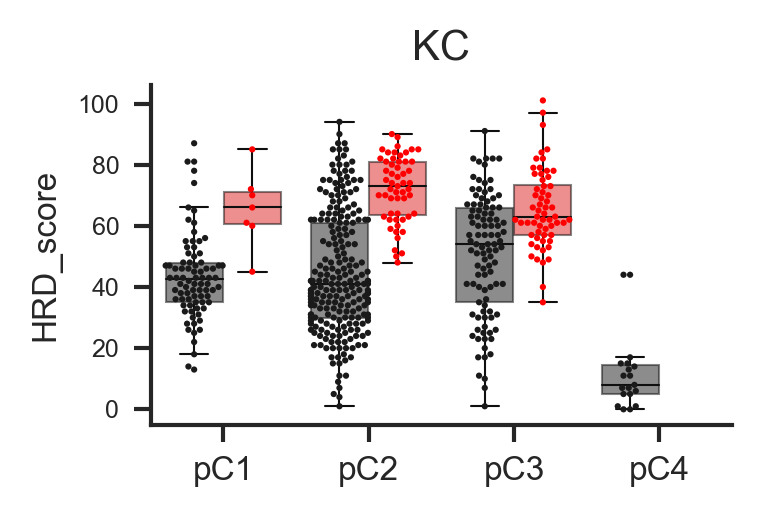

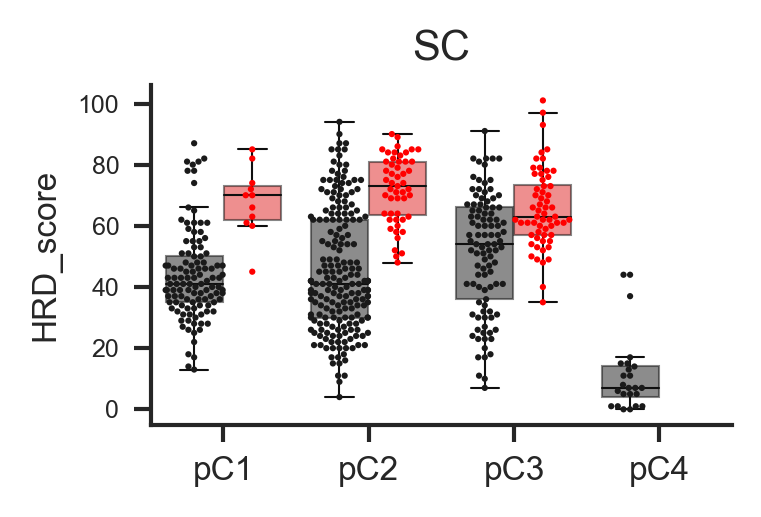

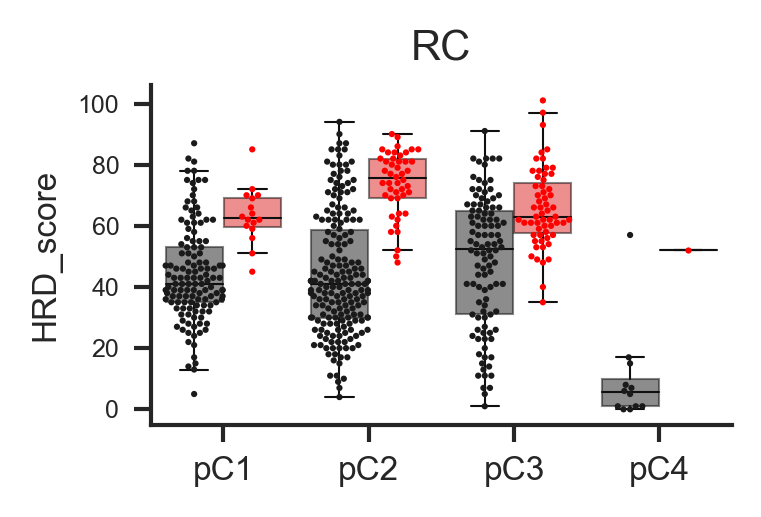

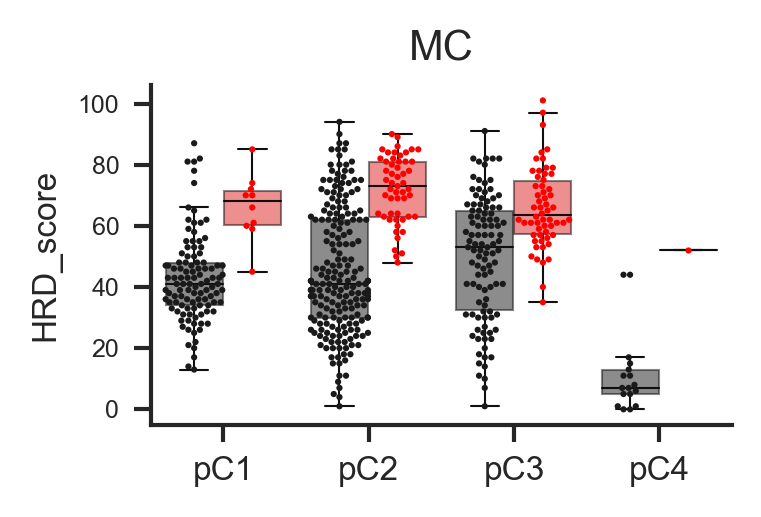

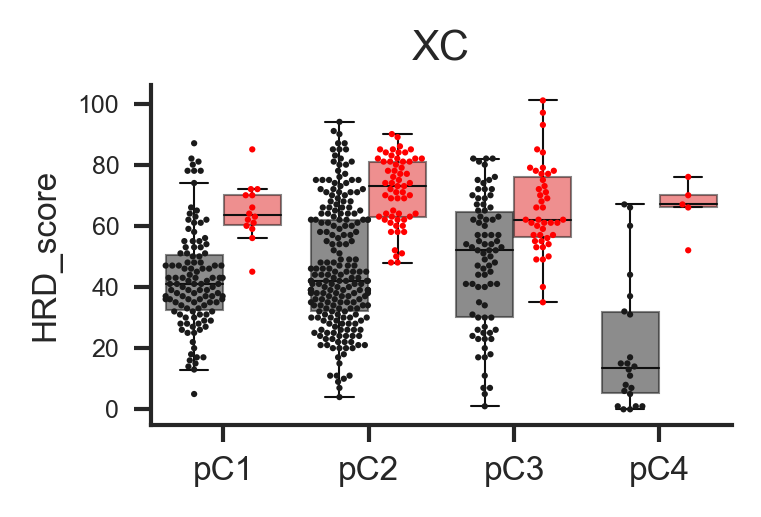

In [197]:
for cat in ['KC','SC','RC','MC','XC']:
    plt_df=c_tcga_preds
    val='HRD_score'
    hue='BRCA_alt'
    fig=plt.figure(figsize=(2.5,1.5))
    ax=fig.add_subplot(1,1,1)
    order=[0,1,2,3]
    xlabels=['pC1','pC2','pC3','pC4']
    hue_color=['k','red']
    sns.boxplot(x=cat,y=val,data=plt_df,boxprops={'alpha':0.5},sym='',order=order,hue=hue,palette=hue_color)
    sns.swarmplot(x=cat,y=val,data=plt_df,s=1.5,order=order,hue=hue,dodge=True,palette=hue_color)#,,hue=hue,palette=palette)
    ax.set_xlabel('')
    ax.set_ylabel(val)
    ax.tick_params('y',labelsize=6)
    ax.set_xticklabels(xlabels,fontsize=8)
    ax.set_title(cat,fontsize=10)


    ax.spines['top'   ].set_visible(False)# .set_color("w")
    ax.spines['right' ].set_visible(False)
    ax.legend([])

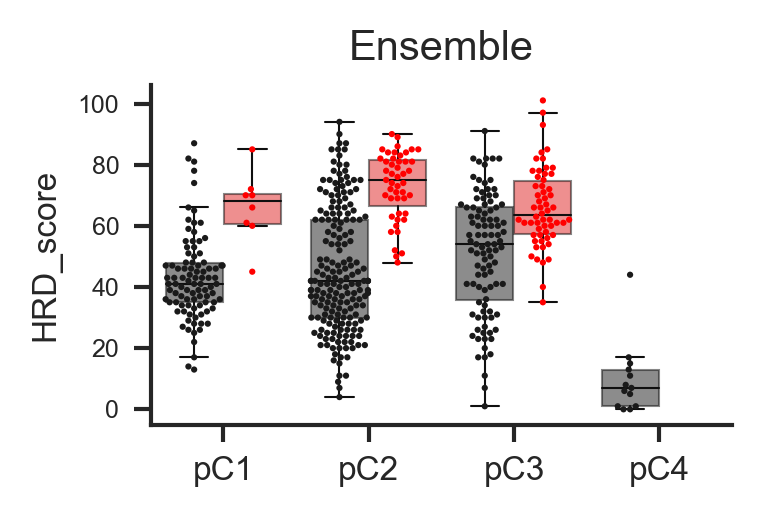

In [198]:
for cat in ['P']:
    plt_df=c_tcga_preds
    val='HRD_score'
    hue='BRCA_alt'
    fig=plt.figure(figsize=(2.5,1.5))
    ax=fig.add_subplot(1,1,1)
    order=['C1','C2','C3','C4']
    hue_color=['k','red']
    sns.boxplot(x=cat,y=val,data=plt_df,boxprops={'alpha':0.5},sym='',order=order,hue=hue,palette=hue_color)
    sns.swarmplot(x=cat,y=val,data=plt_df,s=1.5,order=order,hue=hue,dodge=True,palette=hue_color)#,,hue=hue,palette=palette)
    ax.set_xlabel('')
    ax.set_ylabel(val)
    ax.tick_params('y',labelsize=6)
    ax.set_title('Ensemble',fontsize=10)
    ax.set_xticklabels(xlabels,fontsize=8)
    #ax.set_ylim(-3,3)
    ax.spines['top'   ].set_visible(False)# .set_color("w")
    ax.spines['right' ].set_visible(False)
    ax.legend([])

HRD_score MW test p= 1.3410692574747559e-08
ploidy MW test p= 0.0027918270277038377


/Users/tshiro/.pyenv/versions/miniforge3-4.10/envs/ngs/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 9.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/tshiro/.pyenv/versions/miniforge3-4.10/envs/ngs/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 39.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


MATH MW test p= 0.00012886787905299303
JGOG_C4_signature MW test p= 0.013087874649454306
GSE186458_EM_FT2_ssgsea T-test p= 0.0033057619426461256
HALLMARK_G2M_CHECKPOINT T-test p= 0.013627294156923318
KEGG_CELL_CYCLE T-test p= 0.0024926877827328195
WT1 MW test p= 0.007452823544526288


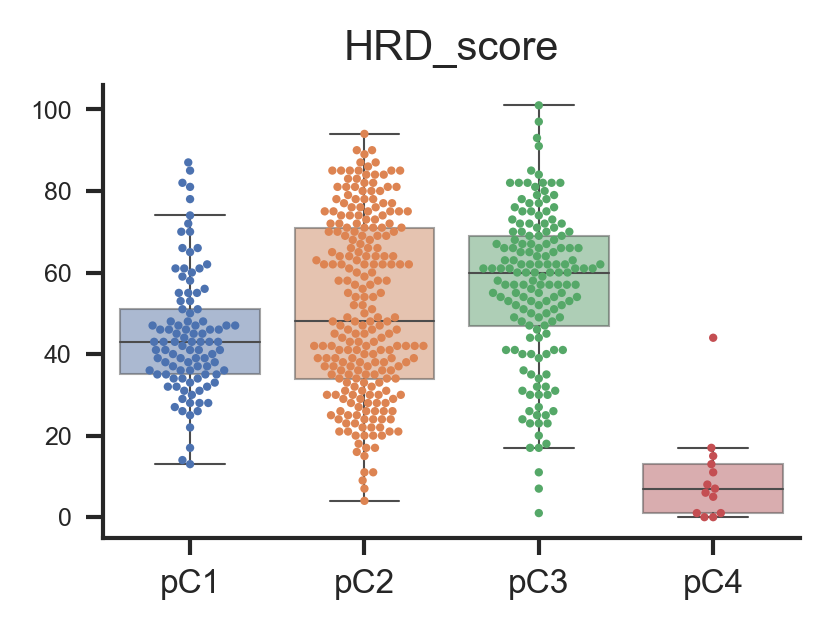

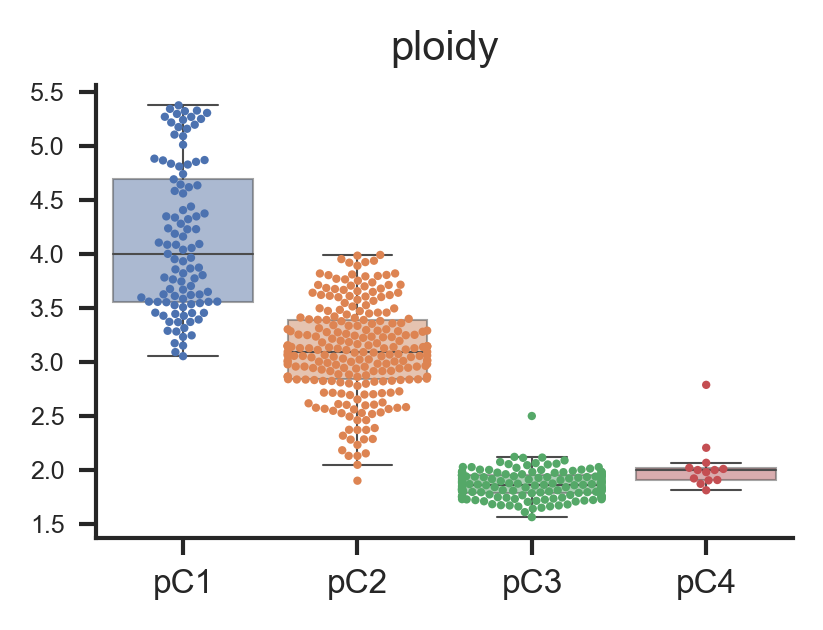

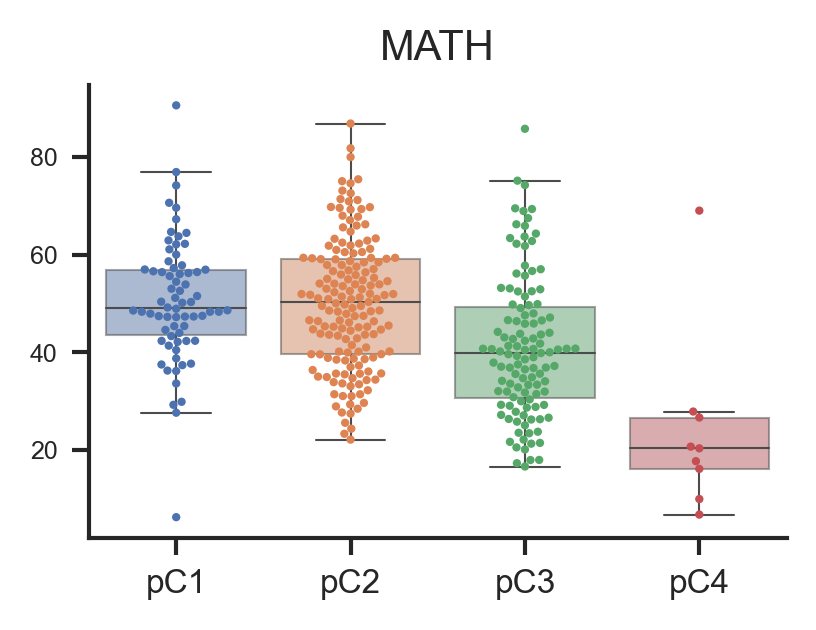

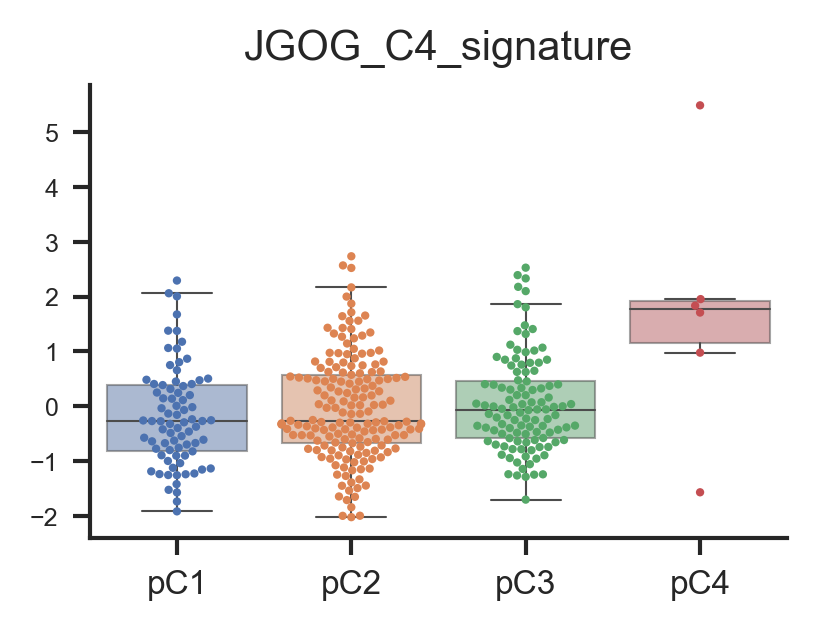

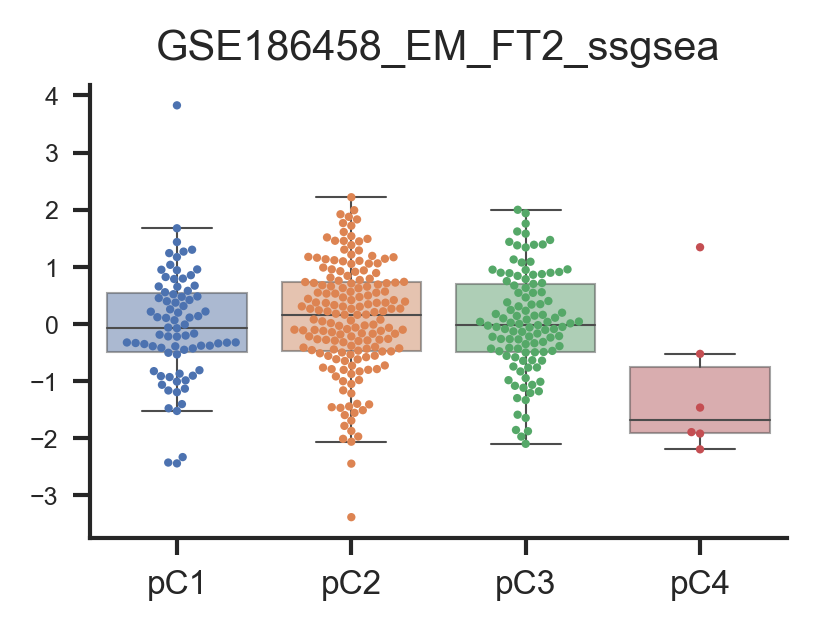

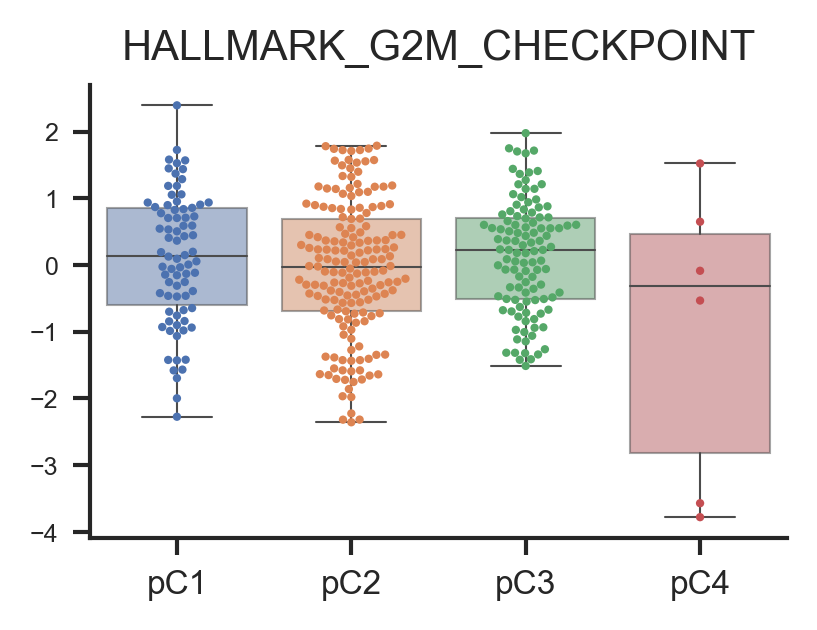

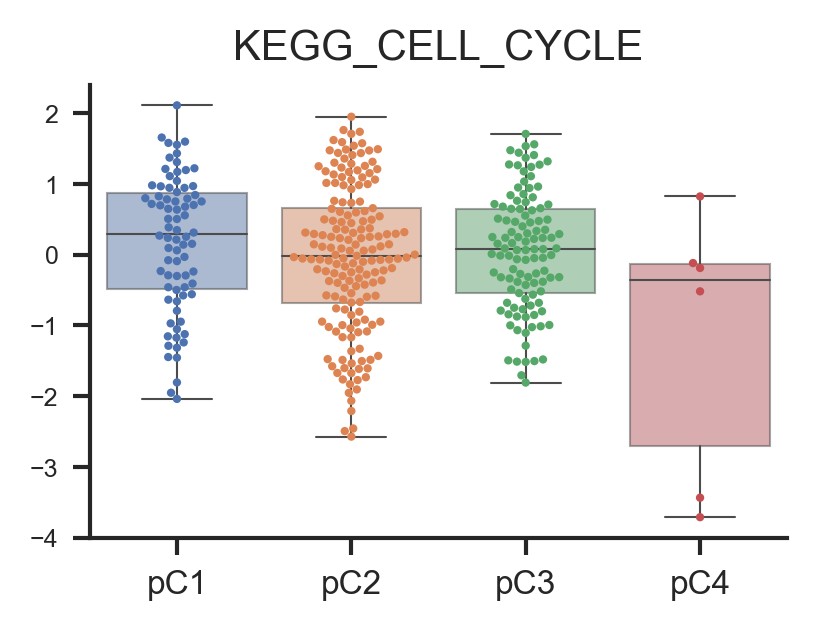

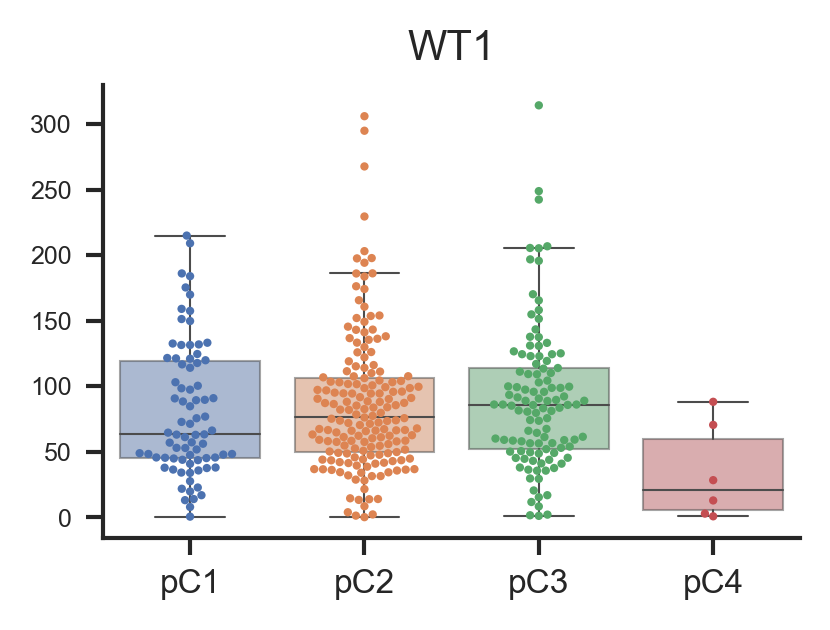

In [199]:
for val in ['HRD_score','ploidy','MATH',
            'JGOG_C4_signature','GSE186458_EM_FT2_ssgsea',
            'HALLMARK_G2M_CHECKPOINT','KEGG_CELL_CYCLE','WT1'
            ]:
    plt_df=c_tcga_preds
    cat='P'
    fig=plt.figure(figsize=(3,2))
    ax=fig.add_subplot(1,1,1)
    order=['C1','C2','C3','C4']
    sns.boxplot(x=cat,y=val,data=plt_df,boxprops={'alpha':0.5},sym='',order=order)#,hue=hue)#,hue=hue,palette=palette)
    sns.swarmplot(x=cat,y=val,data=plt_df,s=2,order=order)#,hue=hue,dodge=True)#,,hue=hue,palette=palette)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params('y',labelsize=6)
    ax.tick_params('x',labelsize=10)
    ax.set_title(val,fontsize=10)
    ax.set_xticklabels(xlabels,fontsize=8)

    ax.spines['top'   ].set_visible(False)# .set_color("w")
    ax.spines['right' ].set_visible(False)
    ax.legend([])
    
    a=plt_df[plt_df[cat]=='C4'][val].dropna()
    b=plt_df[plt_df[cat].isin(['C1','C2','C3'])][val].dropna()
    
    _,p1=kstest_normal(a)
    _,p2=kstest_normal(b)
    
    if (p1>0.05)&(p2>0.05):
        _,p=stats.ttest_ind(a,b,nan_policy='omit')
        print(val, "T-test p=",p)
    else:
        _,p=stats.mannwhitneyu(a,b)
        print(val, 'MW test p=',p)

## Table

In [200]:
c_tcga_preds_mut=c_tcga_preds[~c_tcga_preds['TP53_mut'].isna()]

In [201]:
c_tcga_preds_mut['AKPP_mut']=(c_tcga_preds_mut['PIK3CA_mut']==1)|(c_tcga_preds_mut['KRAS_mut']==1)|\
(c_tcga_preds_mut['ARID1A_mut']==1)|(c_tcga_preds_mut['PTEN_mut']==1)


/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_86493/1493702391.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_tcga_preds_mut['AKPP_mut']=(c_tcga_preds_mut['PIK3CA_mut']==1)|(c_tcga_preds_mut['KRAS_mut']==1)|\


In [202]:
Counter( c_tcga_preds['P'] )

Counter({'UD': 47, 'C2': 236, 'C3': 158, 'C1': 101, 'C4': 13})

In [203]:
ct=pd.crosstab(c_tcga_preds['P'],c_tcga_preds['TP53_mut']).T
ct

P         C1   C2   C3  C4  UD
TP53_mut                      
0.0        4    8   10   6   7
1.0       66  154  108   4  28

In [204]:
ct2=pd.concat(  [ ct.loc[:,'C1':'C3'].apply(np.sum, axis=1), ct['C4']],axis=1)
print(ct2)
#stats.chi2_contingency(ct2,correction=False)[1]
stats.fisher_exact(ct2)[1]

            0  C4
TP53_mut         
0.0        22   6
1.0       328   4


2.1912261629086257e-05

In [205]:
add2=ct.iloc[1,:]/np.sum(ct,axis=0)*100
add2.name='TP53 mutation'
add2

P
C1    94.285714
C2    95.061728
C3    91.525424
C4    40.000000
UD    80.000000
Name: TP53 mutation, dtype: float64

In [206]:
cats=['Number','TP53_mut','BRCA_alt','CCNE1_amp2','AKPP_mut']

In [207]:
c_tcga_preds['BRCA_alt'].isna().sum()

1

            0  C4
TP53_mut         
0.0        22   6
1.0       328   4
2.1912261629086257e-05
            0  C4
BRCA_alt         
0.0       251  10
1.0        99   0
0.06767872597875627
              0  C4
CCNE1_amp2         
0           336  13
1           159   0
0.01207170626881417
            0  C4
AKPP_mut         
False     332   6
True       18   4
0.001741639012637476


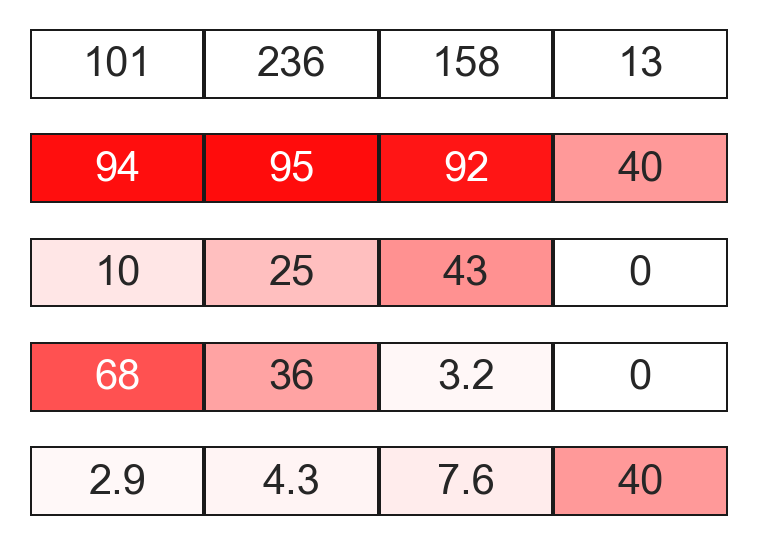

In [208]:
fig=plt.figure(figsize=(3,0.43*len(cats)))
for i,cat in enumerate(cats):
    ax=fig.add_subplot(len(cats),1,1+i)
    if cat=='Number':
        ct=pd.crosstab(c_tcga_preds['P'],c_tcga_preds['CCNE1_amp2']).T
        sns_df=pd.DataFrame(np.sum(ct)).T.drop('UD',axis=1)
        sns.heatmap(sns_df,vmin=200,vmax=200,cmap=wk,cbar=False,ax=ax,linecolor='k',linewidths=0.5,
           annot=sns_df.astype(int),fmt='.3g',xticklabels=0,yticklabels=0)
    elif ('_mut' in cat)|('_alt' in cat):
        ct=pd.crosstab(c_tcga_preds_mut['P'],c_tcga_preds_mut[cat]).T
        ct2=pd.concat(  [ ct.loc[:,'C1':'C3'].apply(np.sum, axis=1), ct['C4']],axis=1)
        ct3=ct.iloc[1,:]/np.sum(ct,axis=0)*100
        print(ct2)
        p=stats.fisher_exact(ct2)[1]
        print(p)
        sns_df=pd.DataFrame(ct3).T.drop('UD',axis=1)
        sns.heatmap(sns_df,vmin=0,vmax=100,cmap=wr,cbar=False,ax=ax,linecolor='k',linewidths=0.5,
           annot=sns_df,xticklabels=0,yticklabels=0)
    else:
        ct=pd.crosstab(c_tcga_preds['P'],c_tcga_preds[cat]).T
        ct2=pd.concat(  [ ct.loc[:,'C1':'C3'].apply(np.sum, axis=1), ct['C4']],axis=1)
        ct3=ct.iloc[1,:]/np.sum(ct,axis=0)*100
        print(ct2)
#        p=stats.chi2_contingency(ct2,correction=False)[1]
        p=stats.fisher_exact(ct2)[1]
        print(p)
        sns_df=pd.DataFrame(ct3).T.drop('UD',axis=1)
        sns.heatmap(sns_df,vmin=0,vmax=100,cmap=wr,cbar=False,ax=ax,linecolor='k',linewidths=0.5,
           annot=sns_df,xticklabels=0,yticklabels=0)
        
        
    ax.set_xlabel('')
plt.subplots_adjust(hspace=0.5)

In [209]:
cats=['HRD_score','ploidy','MATH','JGOG_C4_signature',
      'KEGG_CELL_CYCLE','HALLMARK_G2M_CHECKPOINT','WT1_log','GSE186458_EM_FT2_ssgsea']

HRD_score MW test p= 1.3410692574747559e-08
ploidy MW test p= 0.0027918270277038377
MATH MW test p= 0.00012886787905299303
JGOG_C4_signature MW test p= 0.013087874649454306
KEGG_CELL_CYCLE T-test p= 0.0024926877827328195
HALLMARK_G2M_CHECKPOINT T-test p= 0.013627294156923318
WT1_log MW test p= 0.007452823544526288
GSE186458_EM_FT2_ssgsea T-test p= 0.0033057619426461256


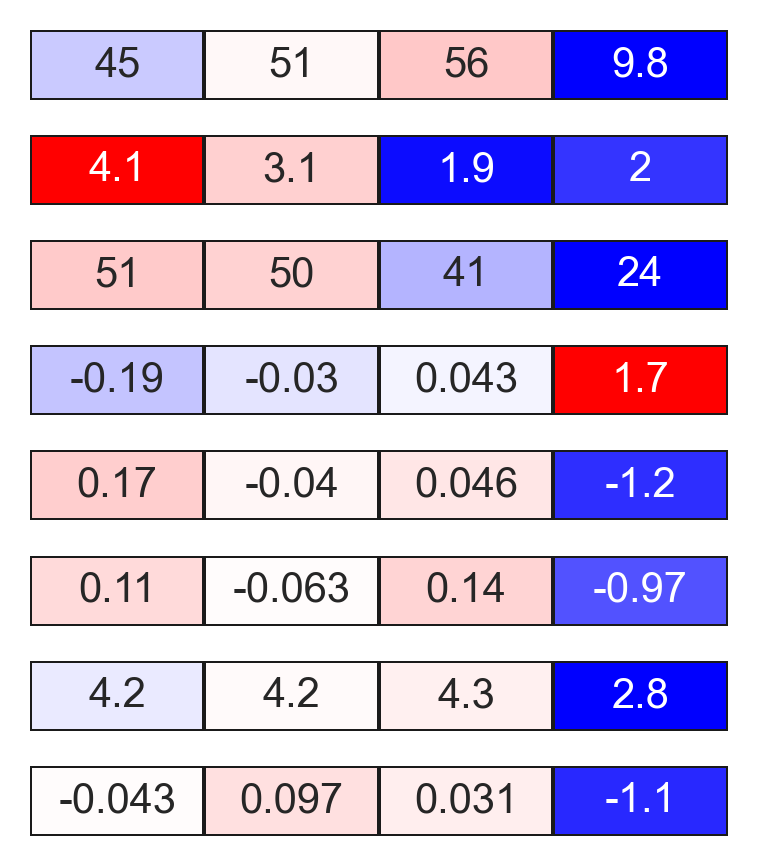

In [210]:
fig=plt.figure(figsize=(3,0.445*len(cats)))
for i,cat in enumerate(cats):
    p1=np.nanpercentile(c_tcga_preds[cat],10)
    p3=np.nanpercentile(c_tcga_preds[cat],90)
    sns_df=pd.DataFrame(c_tcga_preds.groupby('P').mean()[cat]).T.drop('UD',axis=1)
    sns_df.index=[cat]
    ax=fig.add_subplot(len(cats),1,i+1)
    sns.heatmap(sns_df,vmin=p1,vmax=p3,cmap=bwr,cbar=False,ax=ax,linecolor='k',linewidths=0.5,
               annot=sns_df,fmt='.2g' )
    ax.xaxis.set_ticks_position('top')
    ax.set_xlabel('')
    ax.set_yticks([])
    ax.set_xticks([])

    a=c_tcga_preds[c_tcga_preds['P']=='C4'][cat].dropna().values
    b=c_tcga_preds[c_tcga_preds['P'].isin(['C1','C2','C3'])][cat].dropna().values
    _,p1=kstest_normal(a)
    _,p2=kstest_normal(b)
    if (p1>0.05)&(p2>0.05):
        _,p=stats.ttest_ind(a,b,nan_policy='omit')
        print(cat,"T-test p=",p)
    else:
        _,p=stats.mannwhitneyu(a,b)
        print(cat,'MW test p=',p)
plt.subplots_adjust(hspace=0.5)

## Prognosis

[0 1 0 0 0 0 0 0 0 2] ['C2', 'C3', 'C1', 'C4']
KM plot stratified by P
P multivariate log rank p= 0.09109811599529985


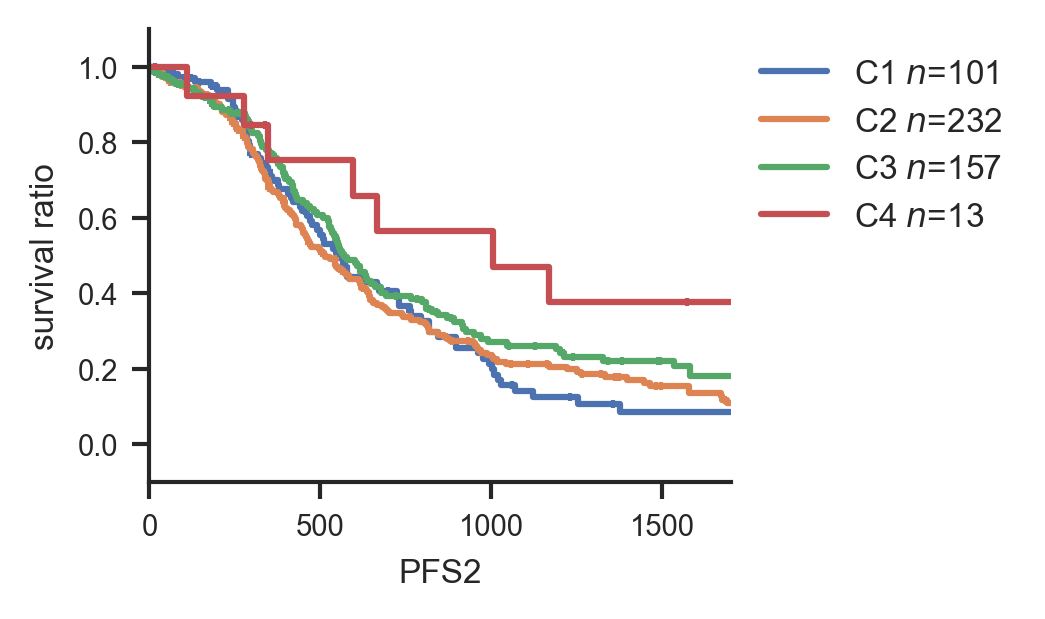

In [211]:
plt_df=c_tcga_preds[c_tcga_preds['P']!='UD']
fig=plt.figure(figsize=(2.5,2))
ax=fig.add_subplot(111)
KMcurve(data=plt_df, category='P',duration='PFS2',event='Rec',ax=ax,linewidth=1.5)
ax.set_xlim(0,1700)
ax.set_ylim(-0.1,1.1)
ax.legend(bbox_to_anchor=(1,1))


[0 1 0 0 0 0 0 0 0 2] ['C2', 'C3', 'C1', 'C4']
KM plot stratified by P
P multivariate log rank p= 0.03834821755197434


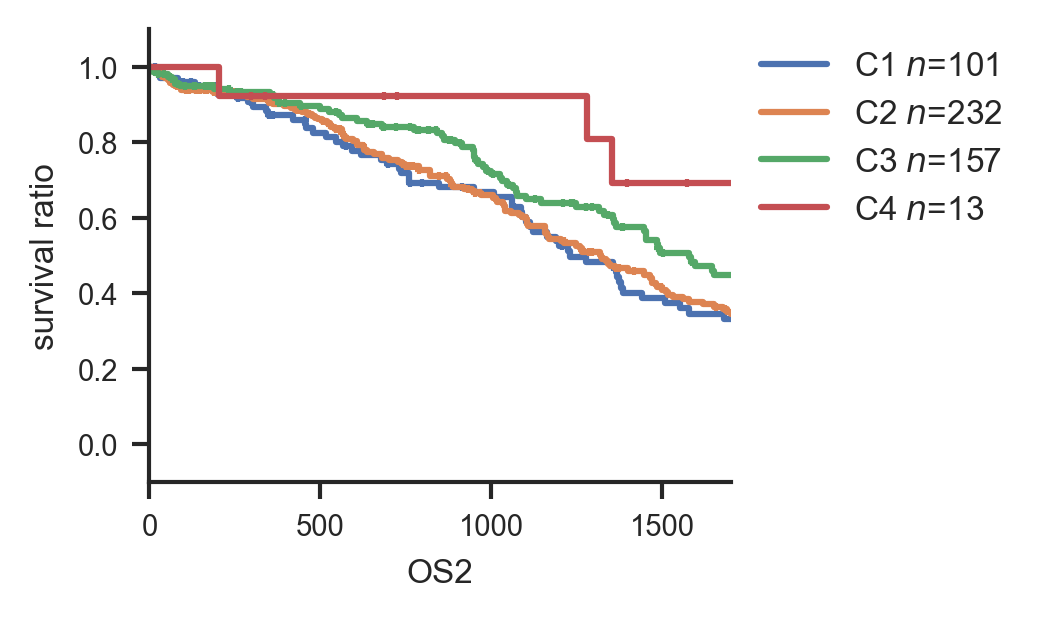

In [212]:
plt_df=c_tcga_preds[c_tcga_preds['P']!='UD']
fig=plt.figure(figsize=(2.5,2))
ax=fig.add_subplot(111)
KMcurve(data=plt_df, category='P',duration='OS2',event='Death',ax=ax,linewidth=1.5)
ax.set_xlim(0,1700)
ax.set_ylim(-0.1,1.1)
ax.legend(bbox_to_anchor=(1,0.5))


Sensitivity = 0.975,　Specificity = 0.389,　Threshold = 48, AUC = 0.837
Sensitivity = 0.861,　Specificity = 0.292,　Threshold = 56, AUC = 0.837


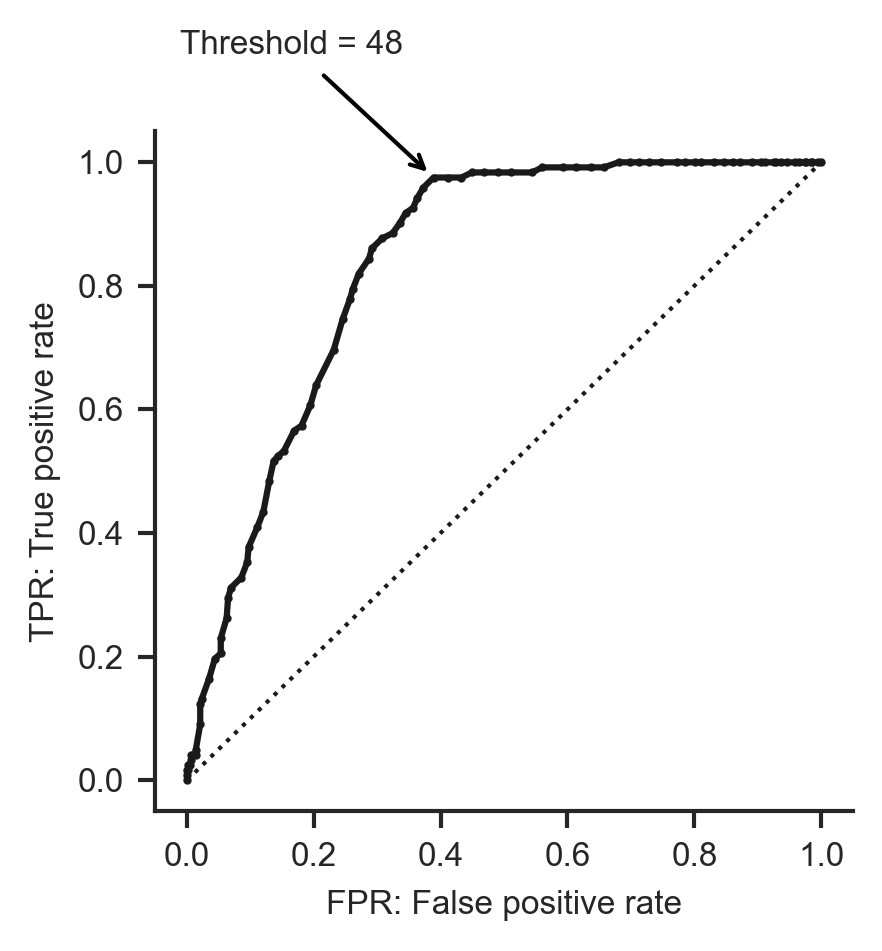

In [213]:
from sklearn.metrics import roc_curve,roc_auc_score,auc

flag="BRCA_alt"
value="HRD_score"
plt_df=c_tcga_preds.copy()

plt_df=plt_df.loc[:,[flag,value]].dropna()
y_true=plt_df[flag]
y_score=plt_df[value]
fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc=roc_auc_score(y_true, y_score)

# Youdan index
yd_idx = np.argmax( abs(tpr -fpr) )
yd_threshold = thresholds[yd_idx]
print("Sensitivity = {:.3f},　Specificity = {:.3f},　Threshold = {:.3g}, AUC = {:.3f}".format(tpr[yd_idx],fpr[yd_idx],yd_threshold,auc))
# Optimal index
op_idx = np.argmin( (1-tpr)**2 + fpr**2)
op_threshold = thresholds[op_idx]
print("Sensitivity = {:.3f},　Specificity = {:.3f},　Threshold = {:.3g}, AUC = {:.3f}".format(tpr[op_idx],fpr[op_idx],thresholds[op_idx],auc))

# plot with Threshold
fig=plt.figure(figsize=(3,3))
ax=fig.add_subplot(111)
ax.plot(fpr, tpr, marker='o',ms=1,c='k',lw=1.5)
ax.set_xlabel('FPR: False positive rate',fontsize=8)
ax.set_ylabel('TPR: True positive rate',fontsize=8)
ax.plot( np.linspace(0,1), np.linspace(0,1), c="k",ls="dotted",lw=1)

arrow_dict = dict(color = "black",arrowstyle = "->",) #shrink=0.1,width=0,
ax.annotate("Threshold = {:.3g}".format(thresholds[yd_idx]),xy=(fpr[yd_idx],tpr[yd_idx]),
             size=8,xytext=(fpr[yd_idx]-0.4,tpr[yd_idx]+0.2), arrowprops = arrow_dict )

ax.tick_params(labelsize=8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [214]:
cat=[]
for idx in c_tcga_preds.index:
    if c_tcga_preds.loc[idx,'BRCA_alt']==1:
        cat.append('HRD')
    elif c_tcga_preds.loc[idx,'HRD_score']>48:
        cat.append('HRD')
    elif c_tcga_preds.loc[idx,'P']=='C4':
        cat.append('nonHRD_C4')
    elif c_tcga_preds.loc[idx,'P']!='C4':
        cat.append('nonHRD_nonC4')
    else:
        cat.append(np.nan)
c_tcga_preds['test']=cat

[0 1 0 1 1 0 1 1 1 1] ['HRD', 'nonHRD_nonC4', 'nonHRD_C4']
KM plot stratified by test
test multivariate log rank p= 0.00024033801449839442


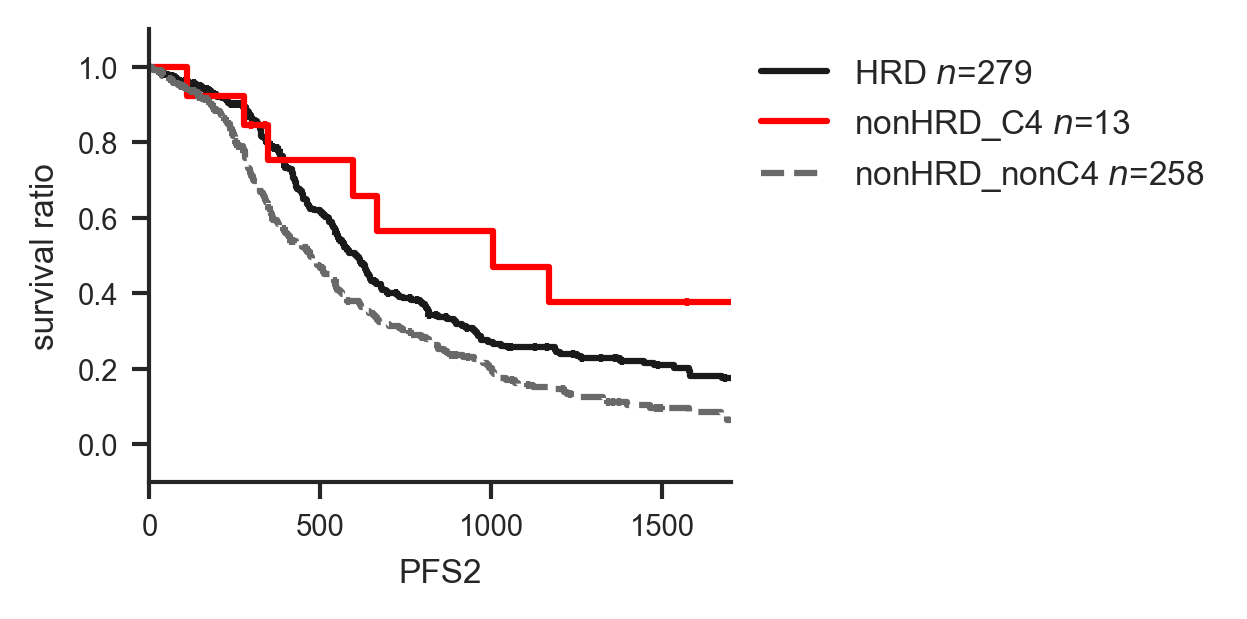

In [215]:
plt_df=c_tcga_preds
fig=plt.figure(figsize=(2.5,2))
ax=fig.add_subplot(111)

KMcurve(data=plt_df, category='test',duration='PFS2',event='Rec',ax=ax,
       colors=['k','red','dimgrey'],linewidth=1.5,linestyle=['solid','solid','dashed'])
ax.set_xlim(0,1700)
ax.set_ylim(-0.1,1.1)
ax.legend(bbox_to_anchor=(1,1))

[0 1 0 1 1 0 1 1 1 1] ['HRD', 'nonHRD_nonC4', 'nonHRD_C4']
KM plot stratified by test
test multivariate log rank p= 2.7548093289043886e-09


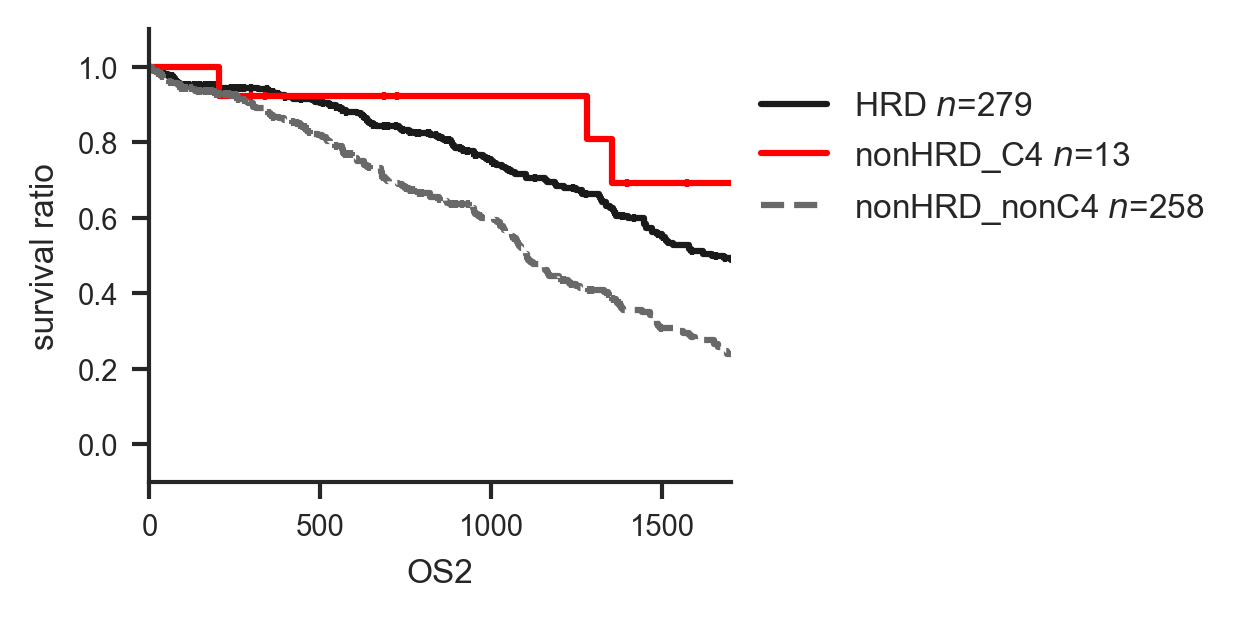

In [216]:
plt_df=c_tcga_preds
fig=plt.figure(figsize=(2.5,2))
ax=fig.add_subplot(111)
KMcurve(data=plt_df, category='test',duration='OS2',event='Death',ax=ax,
       colors=['k','red','dimgrey'],linewidth=1.5,linestyle=['solid','solid','dashed'])
ax.set_xlim(0,1700)
ax.set_ylim(-0.1,1.1)
ax.legend(bbox_to_anchor=(1,0.5))

# TCGA_UCEC

In [217]:
c_ucec=pd.read_csv('../data/TCGA-UCEC_518_clinical_genomic_info.txt',sep='\t',index_col=0)
c_ucec.shape

(518, 448)

In [218]:
p_ov_ucec=pd.read_csv('../code/Machine_learning/TCGA-OV-UCEC_842_predicted_cluster.txt',sep='\t',index_col=0)

## Results

In [219]:
c_ucec['GSE186458_EM/FT_z']=stats.zscore(c_ucec['GSE186458_EM/FT'],nan_policy='omit')
c_tcga['GSE186458_EM/FT_z']=np.nan
c_tcga['POLE_mut']=np.nan
c_tcga['MMR_mut']=np.nan
c_tcga['MLH1_methylation']=np.nan


In [220]:
tcga_ov_ucec=pd.concat([c_tcga,c_ucec],join='inner')
tcga_ov_ucec.shape

(1073, 278)

In [221]:
tcga_ov_ucec['UCEC']=(tcga_ov_ucec.index.isin(c_ucec.index)).astype(int)
tcga_ov_ucec['OV']=(tcga_ov_ucec.index.isin(c_tcga.index)).astype(int)
tcga_ov_ucec['UHGEC']=(tcga_ov_ucec.index.isin( c_ucec.index[c_ucec['hist_grade']=='Endo_G3'])).astype(int)
tcga_ov_ucec['UHGSC']=(tcga_ov_ucec.index.isin( c_ucec.index[c_ucec['hist_grade']=='HGSC'])).astype(int)

In [222]:
tcga_ov_ucec_preds=pd.merge(tcga_ov_ucec,p_ov_ucec,left_index=True,right_index=True,how='inner')

In [223]:
tcga_ov_ucec_preds['pC4']=((tcga_ov_ucec_preds['OV']==1)&(tcga_ov_ucec_preds['P']=='C4')).astype(int)
tcga_ov_ucec_preds['pC1']=((tcga_ov_ucec_preds['OV']==1)&(tcga_ov_ucec_preds['P']=='C1')).astype(int)
tcga_ov_ucec_preds['pC2']=((tcga_ov_ucec_preds['OV']==1)&(tcga_ov_ucec_preds['P']=='C2')).astype(int)
tcga_ov_ucec_preds['pC3']=((tcga_ov_ucec_preds['OV']==1)&(tcga_ov_ucec_preds['P']=='C3')).astype(int)
tcga_ov_ucec_preds['pUD']=((tcga_ov_ucec_preds['OV']==1)&(tcga_ov_ucec_preds['P']=='UD')).astype(int)
tcga_ov_ucec_preds['UpC4']=((tcga_ov_ucec_preds['OV']==0)&(tcga_ov_ucec_preds['P']=='C4')).astype(int)
tcga_ov_ucec_preds['UpC1']=((tcga_ov_ucec_preds['OV']==0)&(tcga_ov_ucec_preds['P']=='C1')).astype(int)
tcga_ov_ucec_preds['UpC2']=((tcga_ov_ucec_preds['OV']==0)&(tcga_ov_ucec_preds['P']=='C2')).astype(int)
tcga_ov_ucec_preds['UpC3']=((tcga_ov_ucec_preds['OV']==0)&(tcga_ov_ucec_preds['P']=='C3')).astype(int)
tcga_ov_ucec_preds['UpUD']=((tcga_ov_ucec_preds['OV']==0)&(tcga_ov_ucec_preds['P']=='UD')).astype(int)

## Check prediction

In [224]:
cnv_ov_ucec=pd.read_csv('../code/Machine_learning/TCGA-OV-UCEC_842_ascat_spmg_CNV48.matrix.combat_to_JGOG.tsv'
                        ,sep='\t',index_col=0)
cnv_ov_ucec_r=cnv_ov_ucec.apply(lambda x: x/np.sum(x),axis=1)

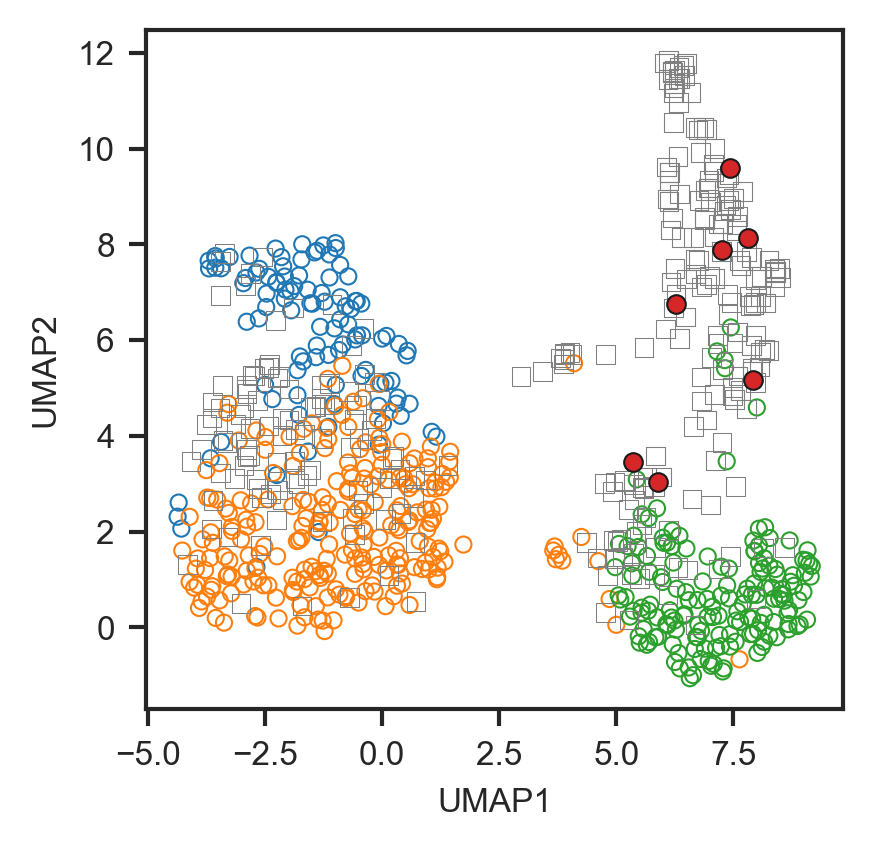

In [225]:
_RS=4
import umap

data1=cnv_ov_ucec_r
trans=umap.UMAP(random_state=_RS,n_components=2,
                n_neighbors=15,
                min_dist=0.5,
                metric='euclidean'
               ).fit(data1)
X2=trans.transform(data1)
c_df=tcga_ov_ucec_preds.loc[cnv_ov_ucec_r.index,:]

# plot
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(1,1,1)    

X=X2[c_df['pC1']==1]
ax.scatter(X[:, 0], X[:, 1],s=15,ec='tab:blue',fc='None',lw=0.5,)
X=X2[c_df['pC2']==1]
ax.scatter(X[:, 0], X[:, 1],s=15,ec='tab:orange',fc='None',lw=0.5,)
X=X2[c_df['pC3']==1]
ax.scatter(X[:, 0], X[:, 1],s=15,ec='tab:green',fc='None',lw=0.5,)

X=X2[c_df['UHGSC']==1]
ax.scatter(X[:, 0], X[:, 1],s=20,ec='grey',fc='None',lw=0.25,marker=',')
X=X2[c_df['UHGEC']==1]
ax.scatter(X[:, 0], X[:, 1],s=20,ec='grey',fc='None',lw=0.25,marker=',')

X=X2[(c_df['UHGSC']==1)&(c_df['UpC4']==1)]
ax.scatter(X[:, 0], X[:, 1],s=20,ec='grey',fc='None',lw=0.25,marker=',')

X=X2[(c_df['UHGEC']==1)&(c_df['UpC4']==1)]
ax.scatter(X[:, 0], X[:, 1],s=20,ec='grey',fc='None',lw=0.25,marker=',')

X=X2[c_df['pC4']==1]
ax.scatter(X[:, 0], X[:, 1],s=20,ec='k',fc='tab:red',lw=0.5,)

ax.set_xlabel("UMAP1",fontsize=8)
ax.set_ylabel("UMAP2",fontsize=8)
ax.tick_params(labelsize=8)  

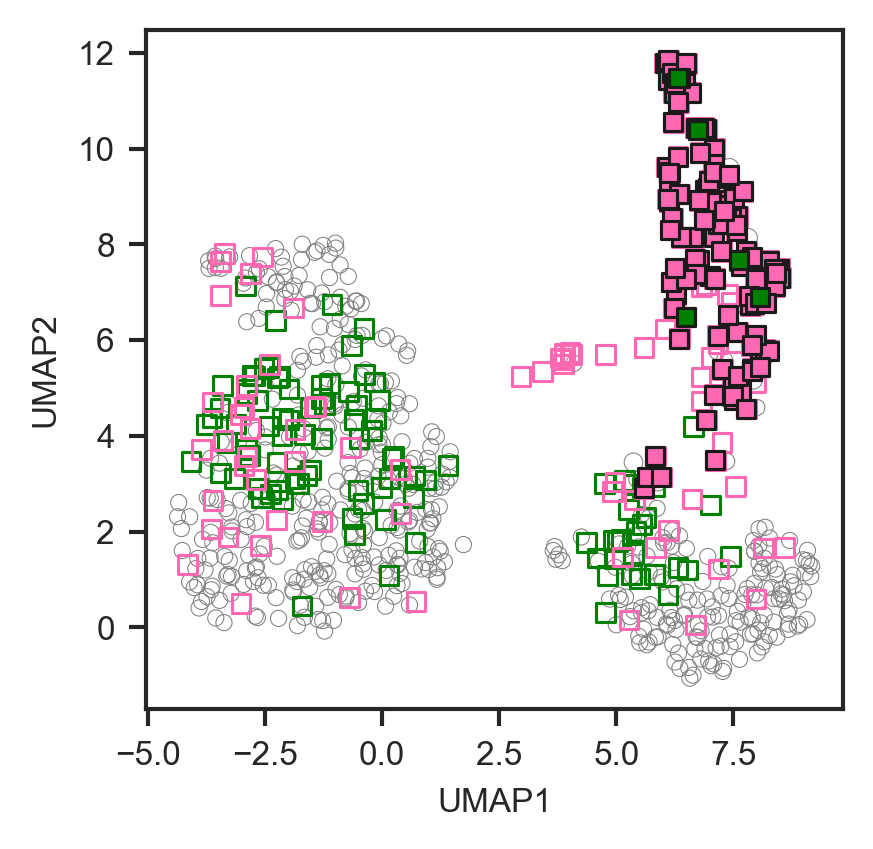

In [226]:
# TCGA-UCEC mapping
data1=cnv_ov_ucec_r
trans=umap.UMAP(random_state=_RS,n_components=2,
                n_neighbors=15,
                min_dist=0.5,
                metric='euclidean'
               ).fit(data1)
X2=trans.transform(data1)
c_df=tcga_ov_ucec_preds.loc[cnv_ov_ucec_r.index,:]

# plot
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(1,1,1)    
X=X2[c_df['pC1']==1]
ax.scatter(X[:, 0], X[:, 1],s=15,ec='grey',fc='None',lw=0.25,)
X=X2[c_df['pC2']==1]
ax.scatter(X[:, 0], X[:, 1],s=15,ec='grey',fc='None',lw=0.25,)
X=X2[c_df['pC3']==1]
ax.scatter(X[:, 0], X[:, 1],s=15,ec='grey',fc='None',lw=0.25,)
X=X2[c_df['pC4']==1]
ax.scatter(X[:, 0], X[:, 1],s=20,ec='grey',fc='None',lw=0.25,)

# UCEC
X=X2[c_df['UHGSC']==1]
ax.scatter(X[:, 0], X[:, 1],s=20,ec='green',fc='None',lw=0.75,marker=',')
X=X2[c_df['UHGEC']==1]
ax.scatter(X[:, 0], X[:, 1],s=20,ec='hotpink',fc='None',lw=0.75,marker=',')

# Up4
X=X2[(c_df['UHGEC']==1)&(c_df['UpC4']==1)]
ax.scatter(X[:, 0], X[:, 1],s=20,ec='k',fc='hotpink',lw=0.75,marker=',')
X=X2[(c_df['UHGSC']==1)&(c_df['UpC4']==1)]
ax.scatter(X[:, 0], X[:, 1],s=20,ec='k',fc='green',lw=0.75,marker=',')

ax.set_xlabel("UMAP1",fontsize=8)
ax.set_ylabel("UMAP2",fontsize=8)
ax.tick_params(labelsize=8)  

## Table

In [227]:
tcga_ucec_preds=tcga_ov_ucec_preds[tcga_ov_ucec_preds['UCEC']==1]

In [228]:
tcga_ucec_preds['GSE186458_EM_FT2_ssgsea_z']=stats.zscore(tcga_ucec_preds['GSE186458_EM_FT2_ssgsea'],nan_policy='omit')
tcga_ucec_preds['JGOG_C4_signature_z']=stats.zscore(tcga_ucec_preds['JGOG_C4_signature'],nan_policy='omit')
tcga_ucec_preds['KEGG_CELL_CYCLE_z']=stats.zscore(tcga_ucec_preds['KEGG_CELL_CYCLE'],nan_policy='omit')
tcga_ucec_preds['HALLMARK_G2M_CHECKPOINT_z']=stats.zscore(tcga_ucec_preds['HALLMARK_G2M_CHECKPOINT'],nan_policy='omit')
tcga_ucec_preds['WT1_log_z']=stats.zscore(tcga_ucec_preds['WT1_log'],nan_policy='omit')

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_86493/113983646.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tcga_ucec_preds['GSE186458_EM_FT2_ssgsea_z']=stats.zscore(tcga_ucec_preds['GSE186458_EM_FT2_ssgsea'],nan_policy='omit')
/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_86493/113983646.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tcga_ucec_preds['JGOG_C4_signature_z']=stats.zscore(tcga_ucec_preds['JGOG_C4_signature'],nan_policy='omit')
/var/folders/3g/5zyn6dld5rl1rc

In [229]:
tcga_ucec_preds.shape

(287, 298)

In [230]:
Counter(tcga_ucec_preds['P'])

Counter({'C4': 117, 'C1': 32, 'C2': 67, 'UD': 36, 'C3': 35})

In [231]:
Counter(tcga_ucec_preds['UHGEC'])

Counter({0: 104, 1: 183})

In [232]:
pd.crosstab(tcga_ucec_preds['P'],tcga_ucec_preds['UHGEC'])

UHGEC   0    1
P             
C1     22   10
C2     41   26
C3     20   15
C4      5  112
UD     16   20

In [233]:
# exclude hyper mutator
tcga_ucec_preds_nh=tcga_ucec_preds[(tcga_ucec_preds['MLH1_methylation']!=1)&(tcga_ucec_preds['MMR_mut']!=1)&(tcga_ucec_preds['POLE_mut']!=1)]


In [234]:
tcga_ucec_preds_mut=tcga_ucec_preds[~tcga_ucec_preds['TP53_mut'].isna()]
tcga_ucec_preds_mut['AKPP_mut']=(np.sum(tcga_ucec_preds_mut[['PIK3CA_mut','ARID1A_mut','KRAS_mut','PTEN_mut']],axis=1)>=1).astype(int)

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_86493/2083146398.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tcga_ucec_preds_mut['AKPP_mut']=(np.sum(tcga_ucec_preds_mut[['PIK3CA_mut','ARID1A_mut','KRAS_mut','PTEN_mut']],axis=1)>=1).astype(int)


In [235]:
tcga_ucec_preds_nh_mut=tcga_ucec_preds_nh[~tcga_ucec_preds_nh['TP53_mut'].isna()]
tcga_ucec_preds_nh_mut['AKPP_mut']=(np.sum(tcga_ucec_preds_nh_mut[['PIK3CA_mut','ARID1A_mut','KRAS_mut','PTEN_mut']],axis=1)>=1).astype(int)

/var/folders/3g/5zyn6dld5rl1rc3t1fmh0t240000gn/T/ipykernel_86493/3680557336.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tcga_ucec_preds_nh_mut['AKPP_mut']=(np.sum(tcga_ucec_preds_nh_mut[['PIK3CA_mut','ARID1A_mut','KRAS_mut','PTEN_mut']],axis=1)>=1).astype(int)


In [236]:
cats=['Number','UHGEC','TP53_mut','CCNE1_amp2','AKPP_mut']

        0   C4
UHGEC         
0      83    5
1      51  112 Chi-sq p= 1.2779704858703863e-21
            0  C4
TP53_mut         
0.0        19  88
1.0       111  23 Chi-sq p= 7.445337739591176e-24
              0   C4
CCNE1_amp2          
0           102  117
1            32    0 Fisher p= 3.568849798977027e-10
           0   C4
AKPP_mut         
0         65    2
1         65  109 Fisher p= 1.4774039009001346e-19


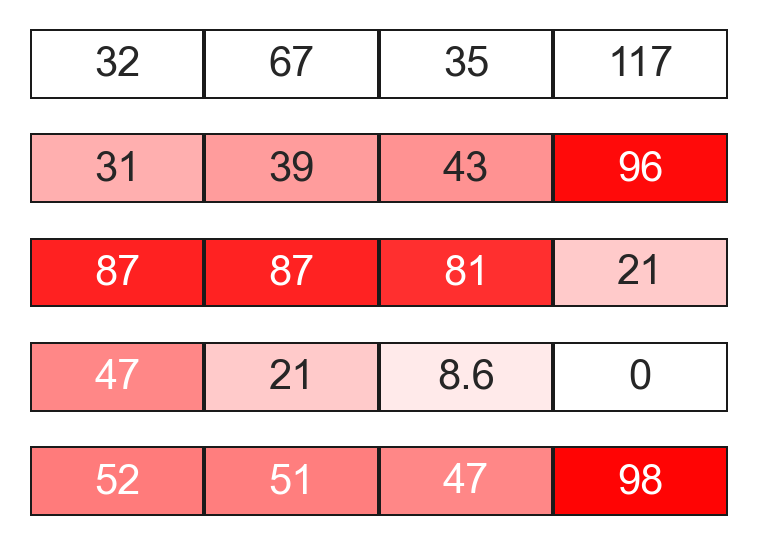

In [237]:
fig=plt.figure(figsize=(3,0.43*len(cats)))
for i,cat in enumerate(cats):
    ax=fig.add_subplot(len(cats),1,1+i)
    if cat=='Number':
        ct=pd.crosstab(tcga_ucec_preds['P'],tcga_ucec_preds['CCNE1_amp2']).T
        sns_df=pd.DataFrame(np.sum(ct)).T.drop('UD',axis=1)
        sns.heatmap(sns_df,vmin=200,vmax=200,cmap=wk,cbar=False,ax=ax,linecolor='k',linewidths=0.5,
           annot=sns_df.astype(int),fmt='.3g',xticklabels=0,yticklabels=0)
    elif '_mut' in cat:
        ct=pd.crosstab(tcga_ucec_preds_mut['P'],tcga_ucec_preds_mut[cat]).T
        ct2=pd.concat(  [ ct.loc[:,'C1':'C3'].apply(np.sum, axis=1), ct['C4']],axis=1)
        ct3=ct.iloc[1,:]/np.sum(ct,axis=0)*100        
        if np.min(np.array(ct2))<5:
            p=stats.fisher_exact(ct2)[1]
            print(ct2,'Fisher p=',p)
        else:
            p=stats.chi2_contingency(ct2,correction=False)[1]
            print(ct2,'Chi-sq p=',p)
        sns_df=pd.DataFrame(ct3).T.drop('UD',axis=1)
        sns.heatmap(sns_df,vmin=0,vmax=100,cmap=wr,cbar=False,ax=ax,linecolor='k',linewidths=0.5,
           annot=sns_df,xticklabels=0,yticklabels=0)
    else:
        ct=pd.crosstab(tcga_ucec_preds['P'],tcga_ucec_preds[cat]).T
        ct2=pd.concat(  [ ct.loc[:,'C1':'C3'].apply(np.sum, axis=1), ct['C4']],axis=1)
        ct3=ct.iloc[1,:]/np.sum(ct,axis=0)*100
        if np.min(np.array(ct2))<5:
            p=stats.fisher_exact(ct2)[1]
            print(ct2,'Fisher p=',p)
        else:
            p=stats.chi2_contingency(ct2,correction=False)[1]
            print(ct2,'Chi-sq p=',p)

        sns_df=pd.DataFrame(ct3).T.drop('UD',axis=1)
        sns.heatmap(sns_df,vmin=0,vmax=100,cmap=wr,cbar=False,ax=ax,linecolor='k',linewidths=0.5,
           annot=sns_df,xticklabels=0,yticklabels=0)
        
        
    ax.set_xlabel('')
plt.subplots_adjust(hspace=0.5)

        0  C4
UHGEC        
0      80   1
1      42  25 Fisher p= 2.153913303839973e-09
            0  C4
TP53_mut         
0.0        15  17
1.0       103   4 Fisher p= 7.504484893618263e-10
             0  C4
CCNE1_amp2        
0           90  26
1           32   0 Fisher p= 0.00123829570944392
           0  C4
AKPP_mut        
0         62   0
1         56  21 Fisher p= 1.1758180691262323e-06


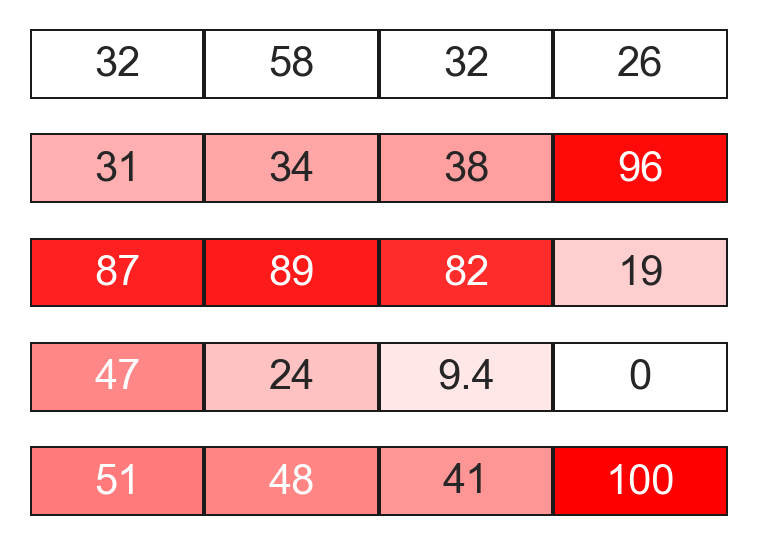

In [238]:
# exclude hyper mutator
cats=['Number','UHGEC','TP53_mut','CCNE1_amp2','AKPP_mut']

fig=plt.figure(figsize=(3,0.43*len(cats)))
for i,cat in enumerate(cats):
    ax=fig.add_subplot(len(cats),1,1+i)
    if cat=='Number':
        ct=pd.crosstab(tcga_ucec_preds_nh['P'],tcga_ucec_preds_nh['CCNE1_amp2']).T
        sns_df=pd.DataFrame(np.sum(ct)).T.drop('UD',axis=1)
        sns.heatmap(sns_df,vmin=200,vmax=200,cmap=wk,cbar=False,ax=ax,linecolor='k',linewidths=0.5,
           annot=sns_df.astype(int),fmt='.3g',xticklabels=0,yticklabels=0)
    
    elif '_mut' in cat:
        ct=pd.crosstab(tcga_ucec_preds_nh_mut['P'],tcga_ucec_preds_nh_mut[cat]).T
        ct2=pd.concat(  [ ct.loc[:,'C1':'C3'].apply(np.sum, axis=1), ct['C4']],axis=1)
        ct3=ct.iloc[1,:]/np.sum(ct,axis=0)*100
        if np.min(np.array(ct2))<5:
            p=stats.fisher_exact(ct2)[1]
            print(ct2,'Fisher p=',p)
        else:
            p=stats.chi2_contingency(ct2,correction=False)[1]
            print(ct2,'Chi-sq p=',p)
        sns_df=pd.DataFrame(ct3).T.drop('UD',axis=1)
        sns.heatmap(sns_df,vmin=0,vmax=100,cmap=wr,cbar=False,ax=ax,linecolor='k',linewidths=0.5,
            annot=sns_df.astype(int),fmt='.3g',xticklabels=0,yticklabels=0)
    else:
        ct=pd.crosstab(tcga_ucec_preds_nh['P'],tcga_ucec_preds_nh[cat]).T
        ct2=pd.concat(  [ ct.loc[:,'C1':'C3'].apply(np.sum, axis=1), ct['C4']],axis=1)
        ct3=ct.iloc[1,:]/np.sum(ct,axis=0)*100
        if np.min(np.array(ct2))<5:
            p=stats.fisher_exact(ct2)[1]
            print(ct2,'Fisher p=',p)
        else:
            p=stats.chi2_contingency(ct2,correction=False)[1]
            print(ct2,'Chi-sq p=',p)
        sns_df=pd.DataFrame(ct3).T.drop('UD',axis=1)
        sns.heatmap(sns_df,vmin=0,vmax=100,cmap=wr,cbar=False,ax=ax,linecolor='k',linewidths=0.5,
           annot=sns_df,xticklabels=0,yticklabels=0)       
        
    ax.set_xlabel('')
plt.subplots_adjust(hspace=0.5)

In [239]:
cats=['HRD_score','ploidy','MATH','JGOG_C4_signature_z',
      'KEGG_CELL_CYCLE_z','HALLMARK_G2M_CHECKPOINT_z','WT1_log_z','GSE186458_EM/FT_z','GSE186458_EM_FT2_ssgsea_z']

HRD_score MW test p= 7.519895065983265e-40
ploidy MW test p= 7.376068930986272e-15
MATH MW test p= 1.5824971896285118e-19
JGOG_C4_signature_z T-test p= 1.3525198547323962e-21
KEGG_CELL_CYCLE_z T-test p= 0.17222548893688125
HALLMARK_G2M_CHECKPOINT_z MW test p= 0.22281291801731384
WT1_log_z MW test p= 4.6716264947495163e-07
GSE186458_EM/FT_z MW test p= 1.088557152553067e-12
GSE186458_EM_FT2_ssgsea_z T-test p= 2.0466588572215506e-07


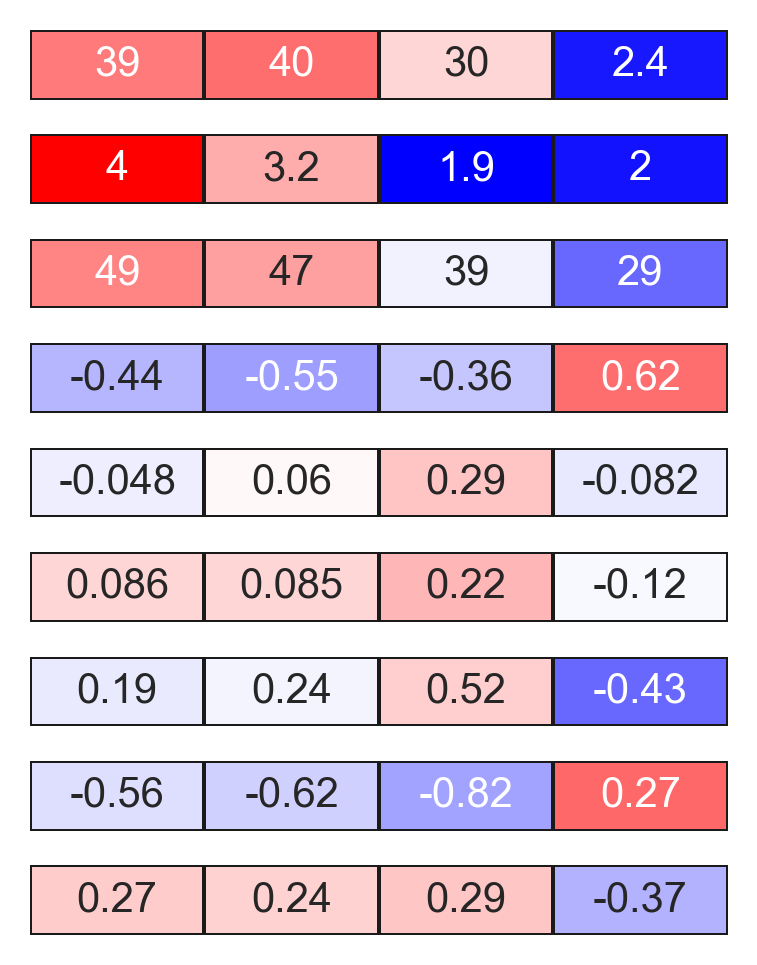

In [240]:
fig=plt.figure(figsize=(3,0.444*len(cats)))
for i,cat in enumerate(cats):
    p1=np.nanpercentile(tcga_ucec_preds[cat],10)
    p3=np.nanpercentile(tcga_ucec_preds[cat],90)
    sns_df=pd.DataFrame(tcga_ucec_preds.groupby('P').mean()[cat]).T.drop('UD',axis=1)
    sns_df.index=[cat]    
    ax=fig.add_subplot(len(cats),1,i+1)
    sns.heatmap(sns_df,vmin=p1,vmax=p3,cmap=bwr,cbar=False,ax=ax,linecolor='k',linewidths=0.5,
               annot=sns_df,fmt='.2g' )
    ax.xaxis.set_ticks_position('top')
    ax.set_xlabel('')
    ax.set_yticks([])
    ax.set_xticks([])

    a=tcga_ucec_preds[tcga_ucec_preds['P']=='C4'][cat].dropna().values
    b=tcga_ucec_preds[tcga_ucec_preds['P'].isin(['C1','C2','C3'])][cat].dropna().values
    _,p1=kstest_normal(a)
    _,p2=kstest_normal(b)
    if (p1>0.05)&(p2>0.05):
        _,p=stats.ttest_ind(a,b,nan_policy='omit')
        print(cat,"T-test p=",p)
    else:
        _,p=stats.mannwhitneyu(a,b)
        print(cat,'MW test p=',p)
    
    
plt.subplots_adjust(hspace=0.5)

HRD_score MW test p= 2.2759237832084832e-14
ploidy MW test p= 4.11427375299266e-06
MATH T-test p= 3.790003485753944e-08
JGOG_C4_signature_z T-test p= 4.374527584740023e-08
KEGG_CELL_CYCLE_z T-test p= 0.0474919953545361
HALLMARK_G2M_CHECKPOINT_z MW test p= 0.04714533944243413
WT1_log_z MW test p= 0.0007989684388252992
GSE186458_EM/FT_z MW test p= 1.072269424640721e-07
GSE186458_EM_FT2_ssgsea_z T-test p= 0.00010315364912517988


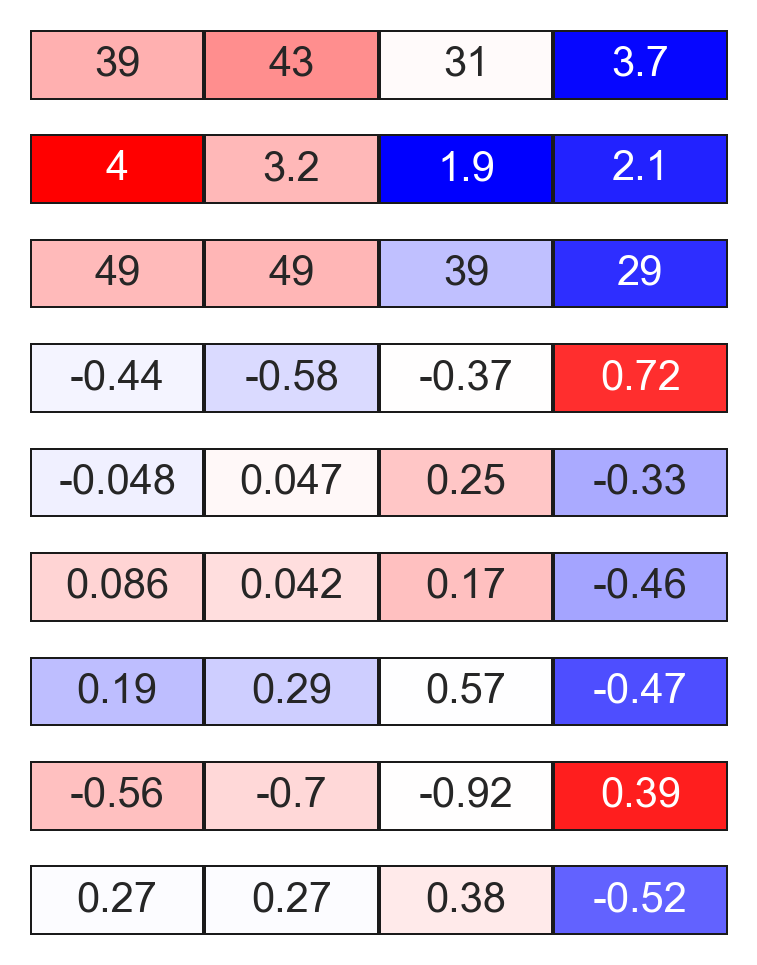

In [241]:
# exclude hyper mutator

fig=plt.figure(figsize=(3,0.444*len(cats)))
for i,cat in enumerate(cats):
    p1=np.nanpercentile(tcga_ucec_preds_nh[cat],10)
    p3=np.nanpercentile(tcga_ucec_preds_nh[cat],90)
    sns_df=pd.DataFrame(tcga_ucec_preds_nh.groupby('P').mean()[cat]).T.drop('UD',axis=1)
    sns_df.index=[cat]    
    ax=fig.add_subplot(len(cats),1,i+1)
    sns.heatmap(sns_df,vmin=p1,vmax=p3,cmap=bwr,cbar=False,ax=ax,linecolor='k',linewidths=0.5,
               annot=sns_df,fmt='.2g' )
    ax.xaxis.set_ticks_position('top')
    ax.set_xlabel('')
    ax.set_yticks([])
    ax.set_xticks([])

    a=tcga_ucec_preds_nh[tcga_ucec_preds_nh['P']=='C4'][cat].dropna().values
    b=tcga_ucec_preds_nh[tcga_ucec_preds_nh['P'].isin(['C1','C2','C3'])][cat].dropna().values
    _,p1=kstest_normal(a)
    _,p2=kstest_normal(b)
    if (p1>0.05)&(p2>0.05):
        _,p=stats.ttest_ind(a,b,nan_policy='omit')
        print(cat,"T-test p=",p)
    else:
        _,p=stats.mannwhitneyu(a,b)
        print(cat,'MW test p=',p)
    
plt.subplots_adjust(hspace=0.5)

/Users/tshiro/.pyenv/versions/miniforge3-4.10/envs/ngs/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 49.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/tshiro/.pyenv/versions/miniforge3-4.10/envs/ngs/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 58.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


HRD_score
6.468133658061833e-56
ploidy
3.8932116839993686e-28
MATH
4.782254731252428e-21
JGOG_C4_signature
1.3525198547324157e-21
GSE186458_EM/FT_z
1.2804272473996866e-13
GSE186458_EM_FT2_ssgsea_z
2.0466588572215506e-07
KEGG_CELL_CYCLE
0.17222548893688125
HALLMARK_G2M_CHECKPOINT
0.06236396029274525


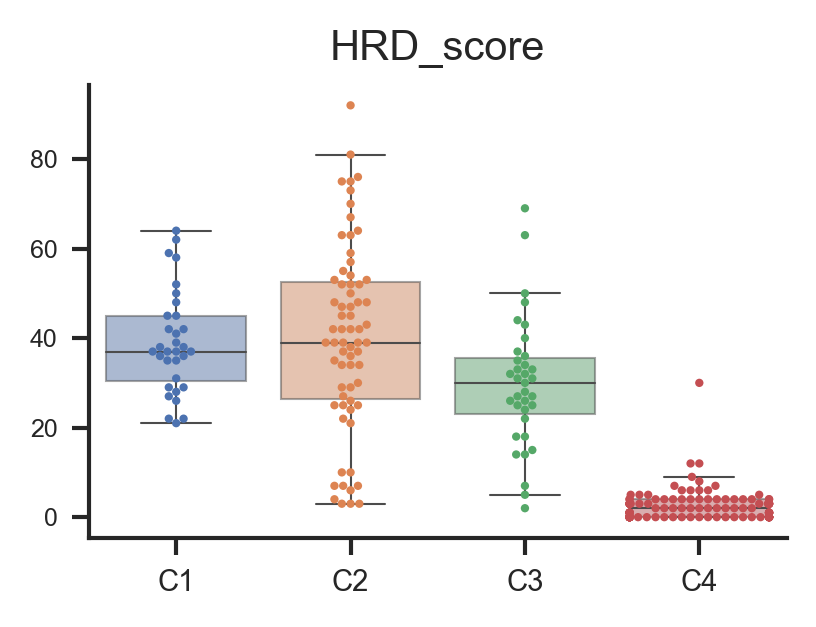

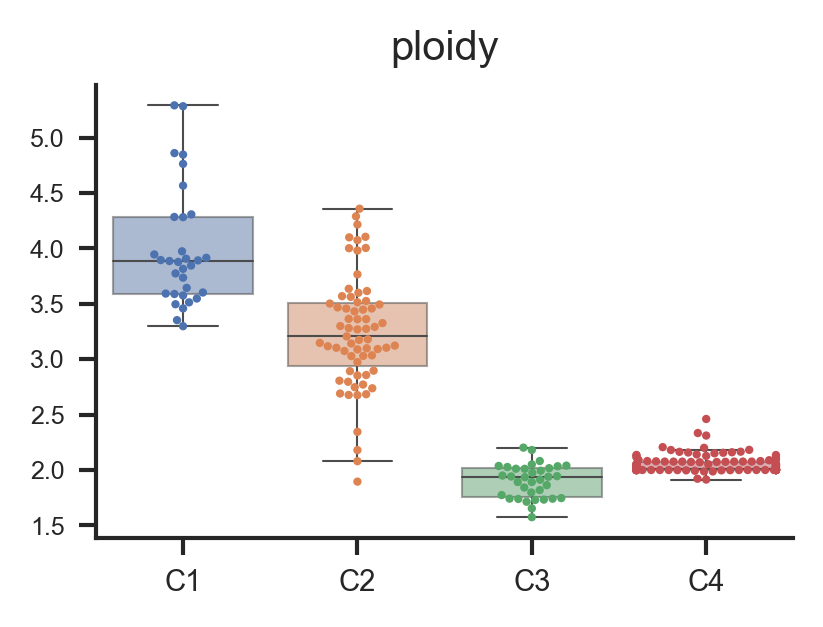

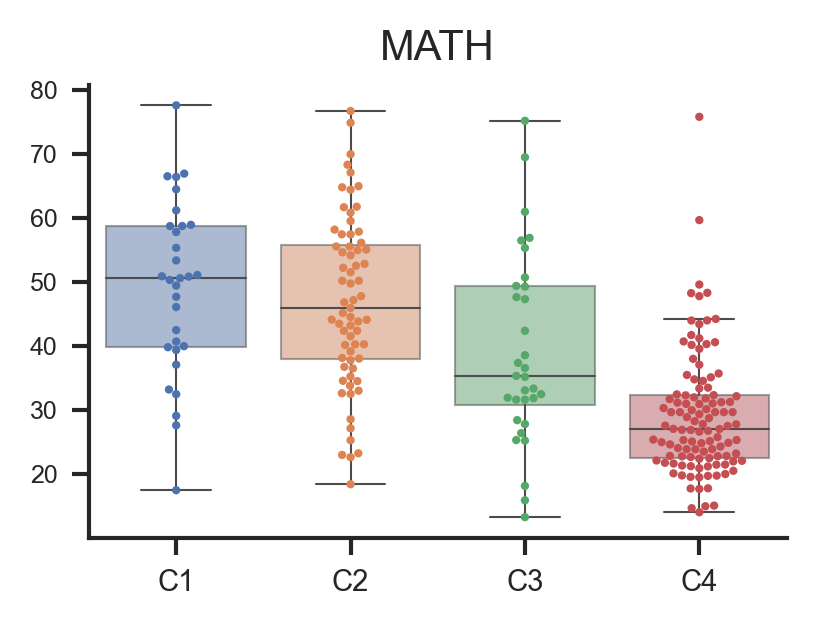

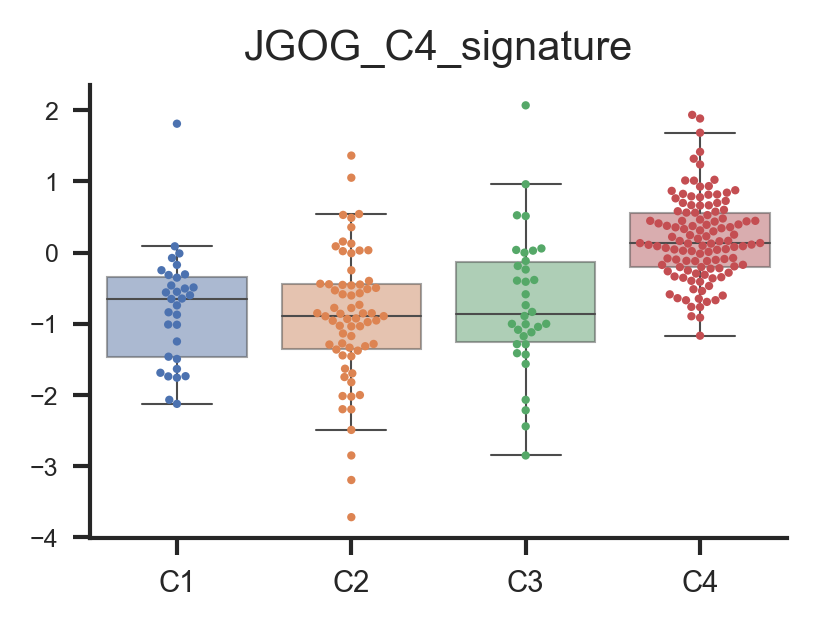

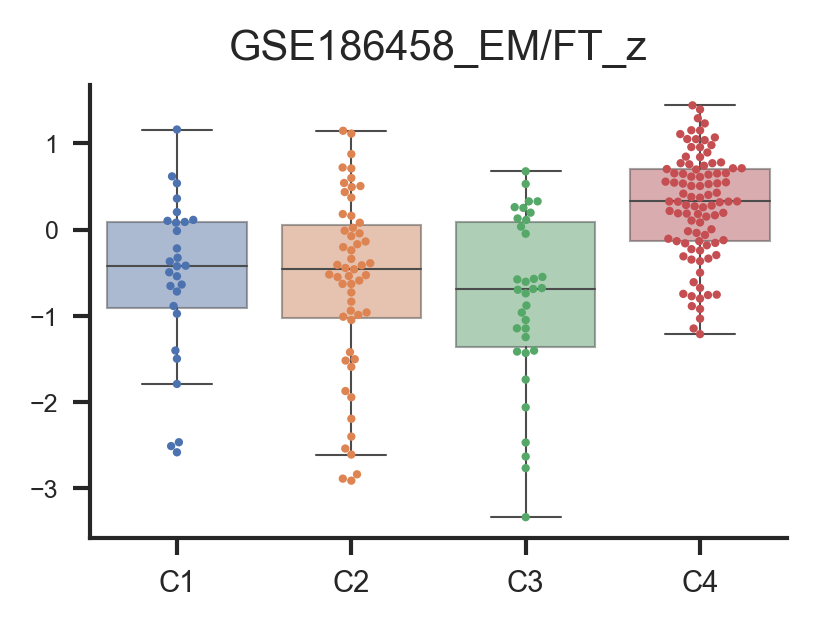

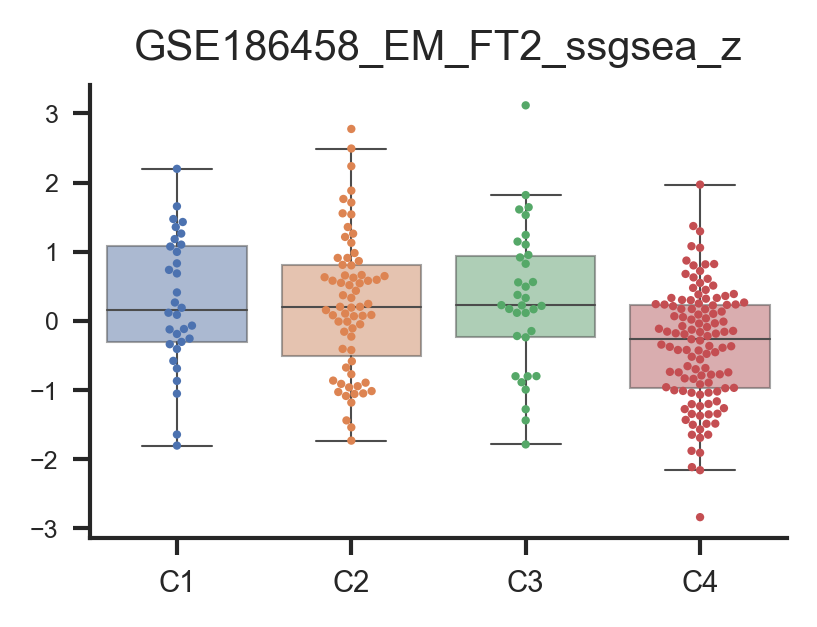

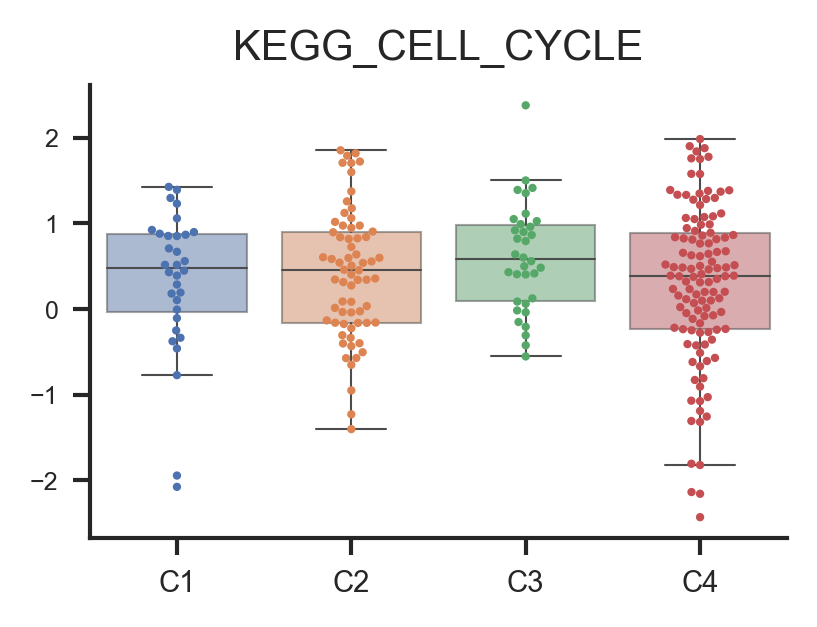

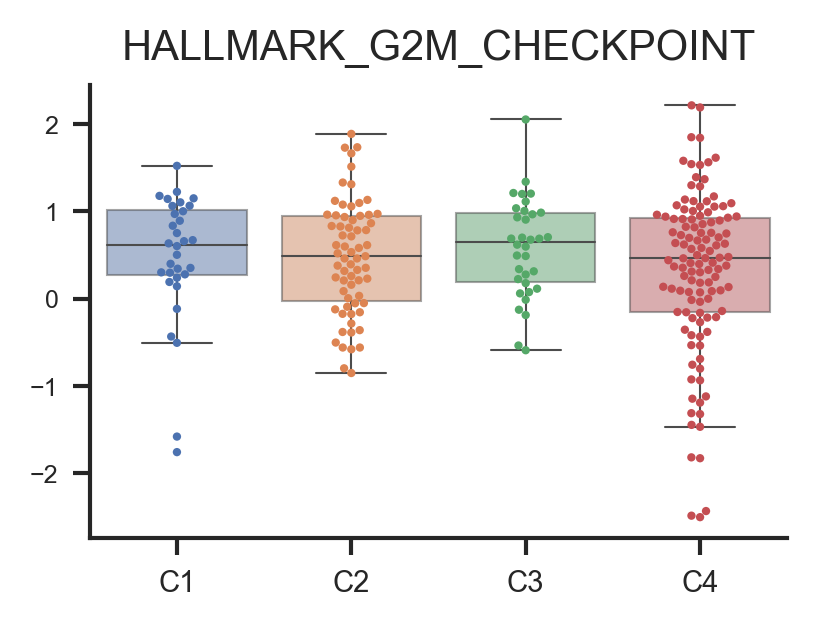

In [242]:
for val in ['HRD_score','ploidy','MATH',
            'JGOG_C4_signature','GSE186458_EM/FT_z','GSE186458_EM_FT2_ssgsea_z',
            'KEGG_CELL_CYCLE','HALLMARK_G2M_CHECKPOINT'
           ]:
    plt_df=tcga_ucec_preds
    #plt_df=c_tcga_preds[~c_tcga_preds.index.isin(g1_pids)]
    cat='P'
    fig=plt.figure(figsize=(3,2))
    ax=fig.add_subplot(1,1,1)
    order=['C1','C2','C3','C4']
    sns.boxplot(x=cat,y=val,data=plt_df,boxprops={'alpha':0.5},sym='',order=order)#,hue=hue)#,hue=hue,palette=palette)
    sns.swarmplot(x=cat,y=val,data=plt_df,s=2,order=order)#,hue=hue,dodge=True)#,,hue=hue,palette=palette)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params('y',labelsize=6)
    ax.set_title(val,fontsize=10)

    ax.spines['top'   ].set_visible(False)# .set_color("w")
    ax.spines['right' ].set_visible(False)
    ax.legend([])
    
    a=plt_df[plt_df[cat]=='C4'][val].dropna()
    b=plt_df[plt_df[cat].isin(['C1','C2','C3'])][val].dropna()
    _,p=stats.ttest_ind(a,b,nan_policy='omit')
    print(val)
    print(p)

## Prognosis

In [243]:
in_df=tcga_ucec_preds

[0 1 2 0 0 0 0 0 2 0] ['C4', 'C1', 'C2', 'C3']
KM plot stratified by P
P multivariate log rank p= 0.05809804705245539


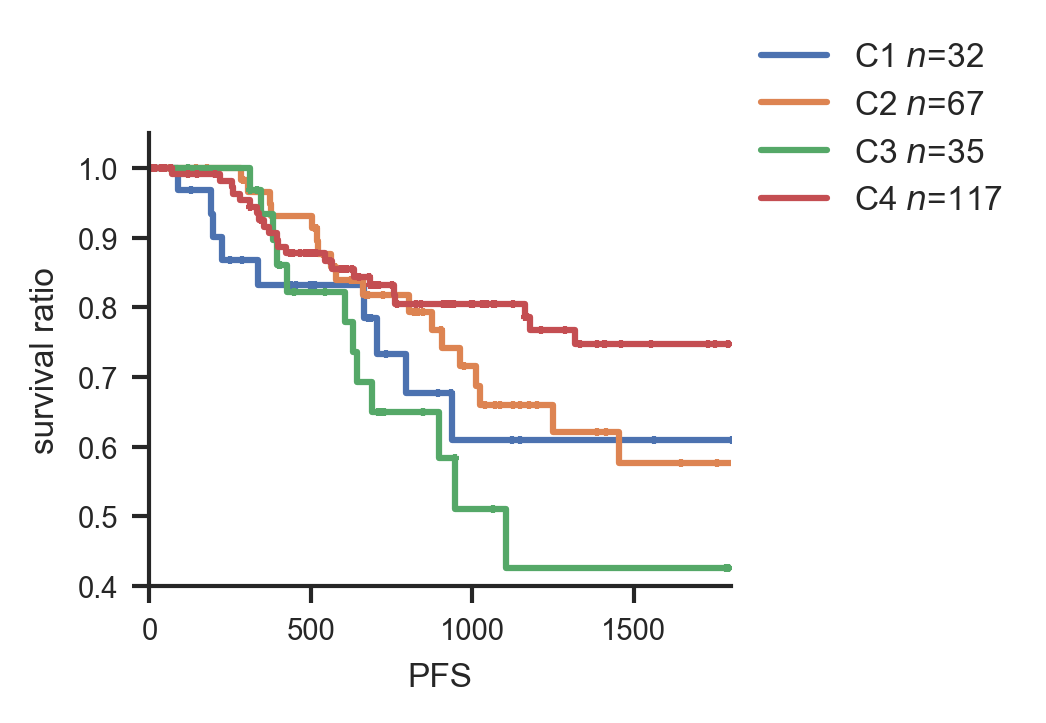

In [244]:
plt_df=in_df[in_df['P']!='UD']
fig=plt.figure(figsize=(2.5,2))
ax=fig.add_subplot(111)
KMcurve(data=plt_df, category='P',duration='PFS',event='Rec',ax=ax,linewidth=1.5)
ax.set_xlim(0,1800)
ax.set_ylim(0.4,1.05)
ax.legend(bbox_to_anchor=(1,0.75))


[0 1 2 0 0 0 0 0 2 0] ['C4', 'C1', 'C2', 'C3']
KM plot stratified by P
P multivariate log rank p= 0.01934670467870845


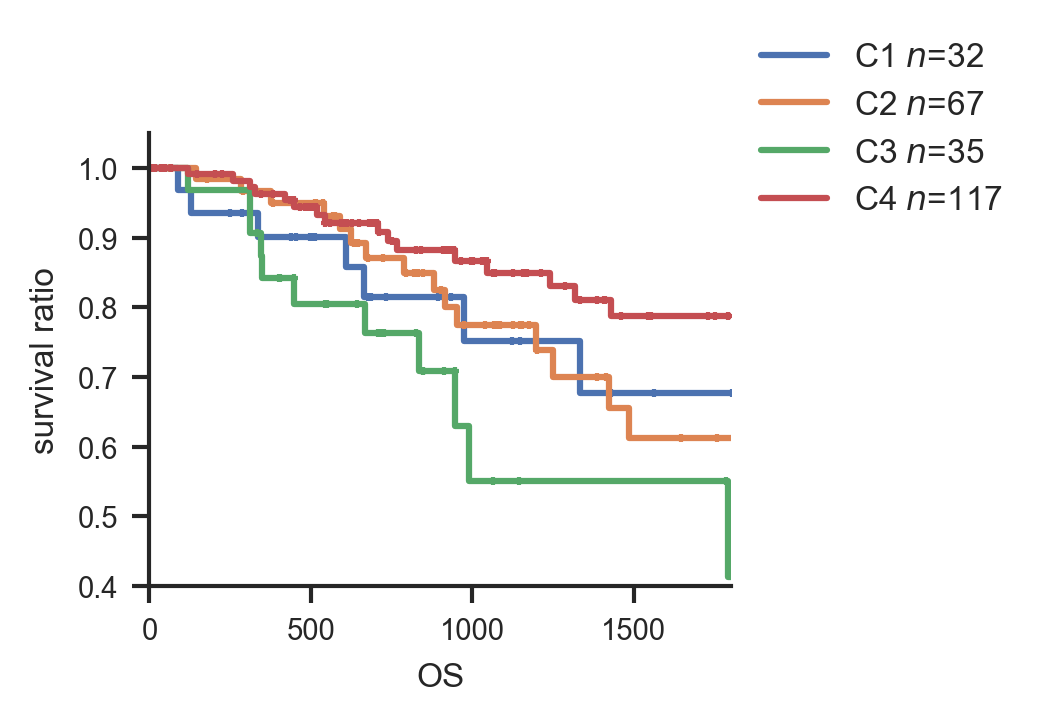

In [245]:
plt_df=in_df[in_df['P']!='UD']
fig=plt.figure(figsize=(2.5,2))
ax=fig.add_subplot(111)
KMcurve(data=plt_df, category='P',duration='OS',event='Death',ax=ax,linewidth=1.5)
ax.set_xlim(0,1800)
ax.set_ylim(0.4,1.05)
ax.legend(bbox_to_anchor=(1,0.75))


In [246]:
# exclude huper mutator
in_df=tcga_ucec_preds_nh

[0 1 1 0 0 0 2 3 0 1] ['C1', 'C2', 'C3', 'C4']
KM plot stratified by P
P multivariate log rank p= 0.5879357971764738


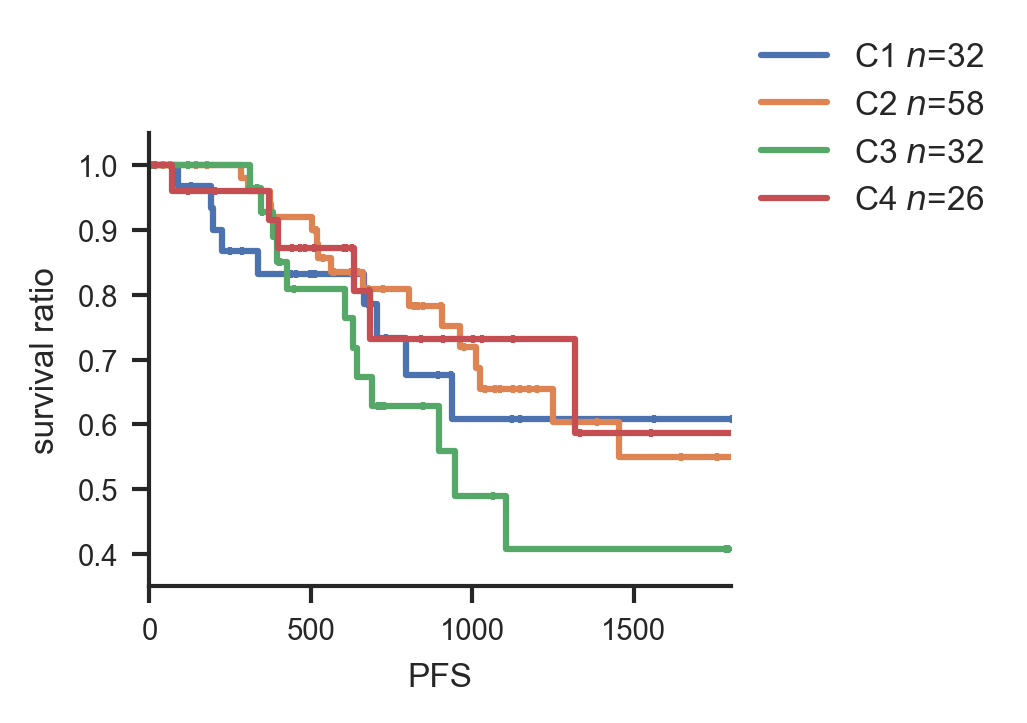

In [247]:
plt_df=in_df[in_df['P']!='UD']
fig=plt.figure(figsize=(2.5,2))
ax=fig.add_subplot(111)
KMcurve(data=plt_df, category='P',duration='PFS',event='Rec',ax=ax,linewidth=1.5)
ax.set_xlim(0,1800)
ax.set_ylim(0.35,1.05)
ax.legend(bbox_to_anchor=(1,0.75))


[0 1 1 0 0 0 2 3 0 1] ['C1', 'C2', 'C3', 'C4']
KM plot stratified by P
P multivariate log rank p= 0.37267599205068325


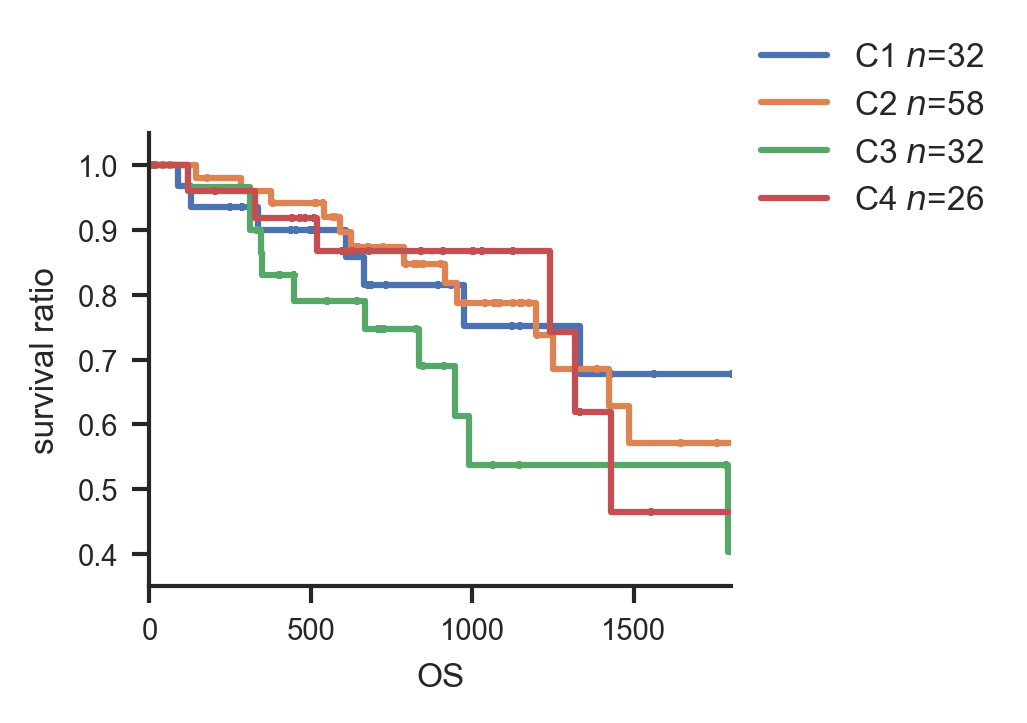

In [248]:
plt_df=in_df[in_df['P']!='UD']
fig=plt.figure(figsize=(2.5,2))
ax=fig.add_subplot(111)
KMcurve(data=plt_df, category='P',duration='OS',event='Death',ax=ax,linewidth=1.5)
ax.set_xlim(0,1800)
ax.set_ylim(0.35,1.05)
ax.legend(bbox_to_anchor=(1,0.75))


# Legends and Colorbar

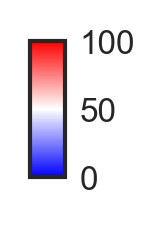

In [249]:
# colorbar
from matplotlib.colors import Normalize, TwoSlopeNorm
from matplotlib.colorbar import ColorbarBase
cmap=plt.get_cmap(bwr)
vmin=0
vmax=100
bounds=[0,50,100]
fontsize=8
label=""
orientation='vertical'
norm = Normalize(vmin=vmin, vmax=vmax)

fig=plt.figure(figsize=(0.15,0.6))
ax=fig.add_subplot(111)
cbar = ColorbarBase(ax, cmap=cmap, norm=norm,
ticks=bounds, orientation=orientation,label=label)
ax.tick_params(labelsize=fontsize,length=0)#,labelleft=True,labelright=False)

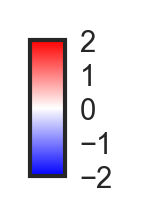

In [250]:
# colorbar
from matplotlib.colors import Normalize, TwoSlopeNorm
from matplotlib.colorbar import ColorbarBase
cmap=plt.get_cmap(bwr)
vmin=-2
vmax=2
bounds=[-2,-1,0,1,2]
fontsize=7
label=""
orientation='vertical'
norm = Normalize(vmin=vmin, vmax=vmax)

fig=plt.figure(figsize=(0.15,0.6))
ax=fig.add_subplot(111)
cbar = ColorbarBase(ax, cmap=cmap, norm=norm,
ticks=bounds, orientation=orientation,label=label)
ax.tick_params(labelsize=fontsize,length=0)#,labelleft=True,labelright=False)

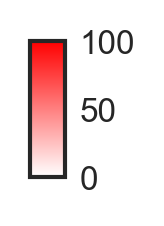

In [251]:
# colorbar
from matplotlib.colors import Normalize, TwoSlopeNorm
from matplotlib.colorbar import ColorbarBase
cmap=plt.get_cmap(wr)
vmin=0
vmax=100
bounds=[0,50,100]
fontsize=8
label=""
orientation='vertical'
norm = Normalize(vmin=vmin, vmax=vmax)

fig=plt.figure(figsize=(0.15,0.6))
ax=fig.add_subplot(111)
cbar = ColorbarBase(ax, cmap=cmap, norm=norm,
ticks=bounds, orientation=orientation,label=label)
ax.tick_params(labelsize=fontsize,length=0)#,labelleft=True,labelright=False)

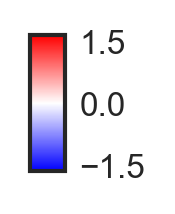

In [252]:
# colorbar
from matplotlib.colors import Normalize, TwoSlopeNorm
from matplotlib.colorbar import ColorbarBase
cmap=plt.get_cmap(bwr)
vmin=-1.65
vmax=1.65
bounds=[-1.5,0,1.5]
fontsize=8
label=""
orientation='vertical'
norm = Normalize(vmin=vmin, vmax=vmax)

fig=plt.figure(figsize=(0.15,0.6))
ax=fig.add_subplot(111)
cbar = ColorbarBase(ax, cmap=cmap, norm=norm,
ticks=bounds, orientation=orientation,label=label)
ax.tick_params(labelsize=fontsize,length=0)#,labelleft=True,labelright=False)

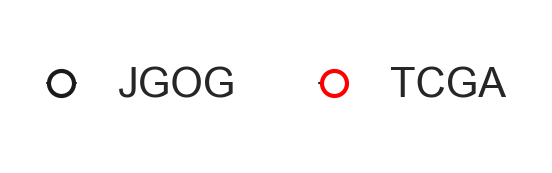

In [253]:
lg_colors=['k','red']
lg_labels=["JGOG","TCGA"]
lg_number=2

from matplotlib.lines import Line2D
custom_legends =[ Line2D([0],[0],marker='o',markerfacecolor='w',markeredgecolor=lg_colors[i],markersize=6,
                        label=lg_labels[i],
                        color="k"
                        ) for i in range(len(lg_labels))]
# plot
plt.figure(figsize=(1,0.5))
plt.legend(handles=custom_legends,loc="center",title="",fontsize=10,
           frameon=False,edgecolor="k", handlelength=0.7,ncol=2
           ,labelspacing=1,handletextpad=1)
plt.gca().set_axis_off()

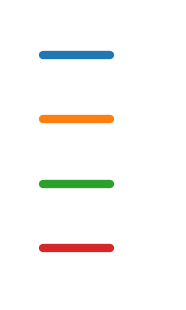

In [254]:
lg_colors=['tab:blue','tab:orange','tab:green','tab:red']
lg_labels=["","",'','']
lg_number=4

from matplotlib.lines import Line2D
custom_legends =[ Line2D([0],[0],color=lg_colors[i],linewidth=2, 
                        label=lg_labels[i],
                        marker='',
                        ) for i in range(lg_number) ]
# plot
plt.figure(figsize=(0.25,0.25))
plt.legend(handles=custom_legends,loc="center",title="",fontsize=8,
           frameon=False,edgecolor="k", handlelength=2
           ,labelspacing=1,handletextpad=1)
plt.gca().set_axis_off()

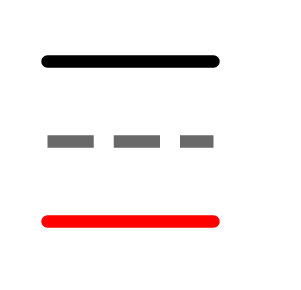

In [255]:
lg_colors=['black','dimgrey','red']
lg_labels=["","",'']
lg_number=3
line_styles=['solid','dashed','solid']

from matplotlib.lines import Line2D
custom_legends =[ Line2D([0],[0],color=lg_colors[i],linewidth=3,linestyle=line_styles[i], 
                        label=lg_labels[i],
                        marker='',
                        ) for i in range(lg_number) ]
# plot
plt.figure(figsize=(0.25,0.25))
plt.legend(handles=custom_legends,loc="center",title="",fontsize=10,
           frameon=False,edgecolor="k", handlelength=4
           ,labelspacing=1,handletextpad=1)
plt.gca().set_axis_off()

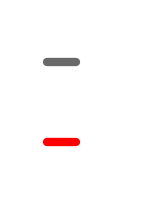

In [256]:
lg_colors=['dimgrey','red']
lg_labels=["",""]
lg_number=2

from matplotlib.lines import Line2D
custom_legends =[ Line2D([0],[0],color=lg_colors[i],linewidth=2,# linestyle="dotted", 
                        label=lg_labels[i],
                        marker='',
                        ) for i in range(lg_number) ]
# plot
plt.figure(figsize=(0.25,0.25))
plt.legend(handles=custom_legends,loc="center",title="",fontsize=10,
           frameon=False,edgecolor="k", handlelength=0.7
           ,labelspacing=1,handletextpad=1)
plt.gca().set_axis_off()

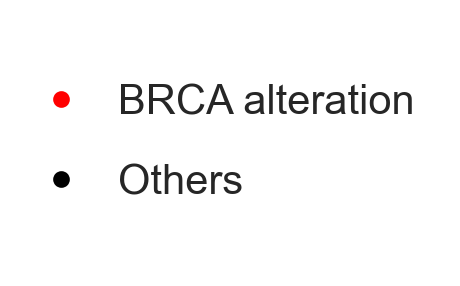

In [257]:
lg_colors=['red','black']
lg_labels=["BRCA alteration","Others"]
lg_number=2

from matplotlib.lines import Line2D
custom_legends =[ Line2D([0],[0],marker='o',markerfacecolor=lg_colors[i],
                         markeredgecolor=lg_colors[i],markersize=3,# markeredgecolor="k",
                         label=lg_labels[i],linewidth=0,
                         color="k"
                        ) for i in range(len(lg_labels))]
# plot
plt.figure(figsize=(1,1))
plt.legend(handles=custom_legends,loc="center",title="",fontsize=10,
           frameon=False,edgecolor="k", handlelength=0.7
           ,labelspacing=1,handletextpad=1)
plt.gca().set_axis_off()

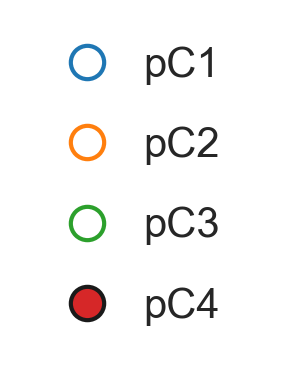

In [258]:
lg_colors=["tab:blue",'tab:orange','tab:green','k']
lg_labels=["pC1","pC2",'pC3','pC4']
lg_number=4

from matplotlib.lines import Line2D
custom_legends =[ Line2D([0],[0],marker='o',markerfacecolor=['w','w','w','tab:red'][i],markeredgecolor=lg_colors[i],markersize=8,# markeredgecolor="k",
                        label=lg_labels[i],
                        color="k"
                        ) for i in range(len(lg_labels))]
# plot
plt.figure(figsize=(1,1))
plt.legend(handles=custom_legends,loc="center",title="",fontsize=10,
           frameon=False,edgecolor="k", handlelength=0.7
           ,labelspacing=1,handletextpad=1)
plt.gca().set_axis_off()

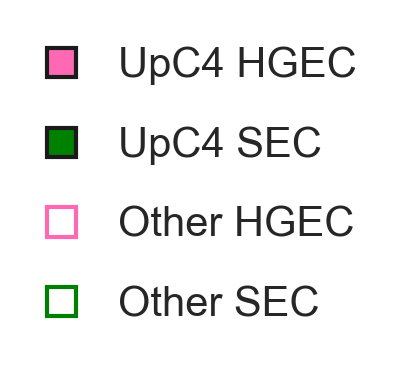

In [259]:
lg_colors=["k",'k','hotpink','green']
lg_colors2=["hotpink",'green','w','w']
lg_labels=["UpC4 HGEC","UpC4 SEC",'Other HGEC','Other SEC']
lg_number=4

from matplotlib.patches import Patch
custom_legends=[ Patch(facecolor=lg_colors2[i],edgecolor=lg_colors[i],label=lg_labels[i])
                 for i in range(lg_number) ]

# plot
plt.figure(figsize=(1,1))
plt.legend(handles=custom_legends,loc="center",title="",fontsize=10,
           frameon=False,edgecolor="k", handlelength=0.7
           ,labelspacing=1,handletextpad=1)
plt.gca().set_axis_off()

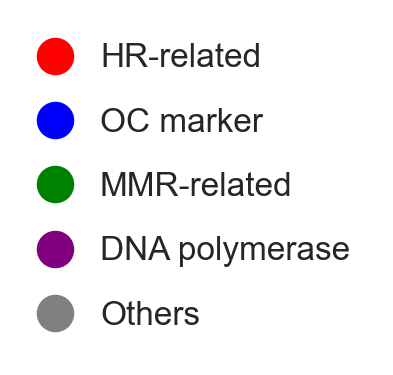

In [260]:
lg_colors=["red",'blue','green','purple','grey']
#lg_colors2=["green",'w','blue','w']
lg_labels=["HR-related","OC marker",'MMR-related','DNA polymerase','Others']
lg_number=5

from matplotlib.lines import Line2D
custom_legends =[ Line2D([0],[0],marker='o',markerfacecolor=lg_colors[i],markeredgecolor=lg_colors[i],markersize=8,# markeredgecolor="k",
                        label=lg_labels[i],
                        color="k"
                        ) for i in range(len(lg_labels))]
# plot
plt.figure(figsize=(1,1))
plt.legend(handles=custom_legends,loc="center",title="",fontsize=8,
           frameon=False,edgecolor="k", handlelength=0.7
           ,labelspacing=1,handletextpad=1)
plt.gca().set_axis_off()

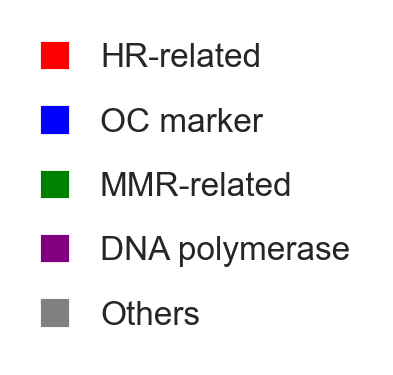

In [261]:
lg_colors=["red",'blue','green','purple','grey']
#lg_colors2=["green",'w','blue','w']
lg_labels=["HR-related","OC marker",'MMR-related','DNA polymerase','Others']
lg_number=5

from matplotlib.patches import Patch
custom_legends=[ Patch(facecolor=lg_colors[i],edgecolor=lg_colors[i],label=lg_labels[i])
                 for i in range(lg_number) ]

# plot
plt.figure(figsize=(1,1))
plt.legend(handles=custom_legends,loc="center",title="",fontsize=8,
           frameon=False,edgecolor="k", handlelength=0.7
           ,labelspacing=1,handletextpad=1)
plt.gca().set_axis_off()

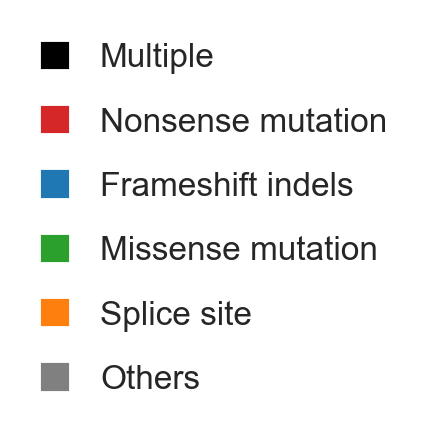

In [262]:
lg_colors=["black",'tab:red','tab:blue','tab:green','tab:orange','grey']
#lg_colors2=["green",'w','blue','w']
lg_labels=["Multiple","Nonsense mutation",'Frameshift indels','Missense mutation','Splice site','Others']
lg_number=6

from matplotlib.patches import Patch
custom_legends=[ Patch(facecolor=lg_colors[i],edgecolor=lg_colors[i],label=lg_labels[i])
                 for i in range(lg_number) ]

# plot
plt.figure(figsize=(1,1))
plt.legend(handles=custom_legends,loc="center",title="",fontsize=8,
           frameon=False,edgecolor="k", handlelength=0.7
           ,labelspacing=1,handletextpad=1)
plt.gca().set_axis_off()

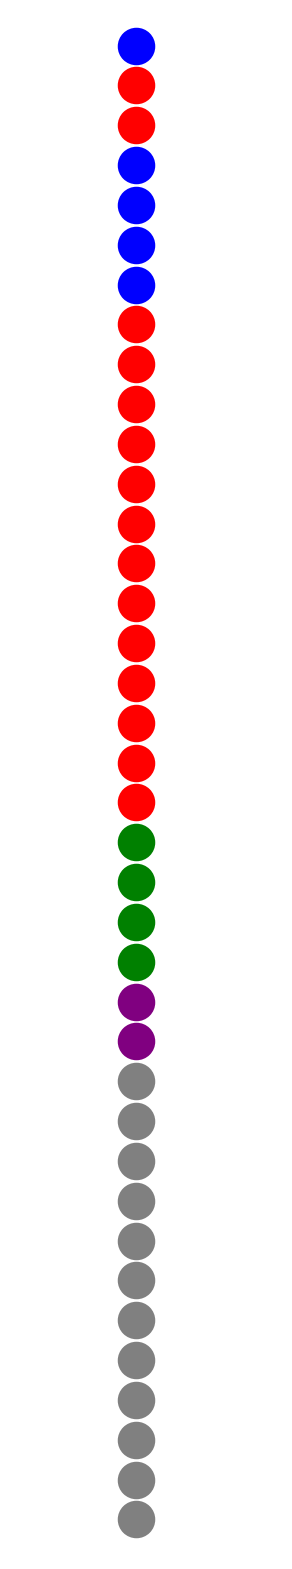

In [263]:
lg_colors=['blue']+["red"]*2+['blue']*4+['red']*13+\
['green']*4+['purple']*2+['grey']*12
lg_number=len(lg_colors)

from matplotlib.lines import Line2D
custom_legends =[ Line2D([0],[0],marker='o',markerfacecolor=lg_colors[i],
                         markeredgecolor=lg_colors[i],markersize=8,# markeredgecolor="k",
                        label=None,color="k"
                        ) for i in range(len(lg_colors))]
# plot
plt.figure(figsize=(1,1))
plt.legend(handles=custom_legends,loc="center",title="",fontsize=5,
           frameon=False,edgecolor="k", handlelength=0.7
           ,labelspacing=1,handletextpad=1)
plt.gca().set_axis_off()

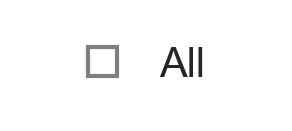

In [264]:
lg_colors=["tab:grey"]
lg_labels=["All"]
lg_number=1

from matplotlib.patches import Patch
custom_legends=[ Patch(facecolor='w',edgecolor=lg_colors[i],label=lg_labels[i])
                 for i in range(lg_number) ]

# plot
plt.figure(figsize=(1,0.25))
plt.legend(handles=custom_legends,loc="center",title="",fontsize=10,
           frameon=False,edgecolor="k", handlelength=0.7
           ,labelspacing=1,handletextpad=1)
plt.gca().set_axis_off()

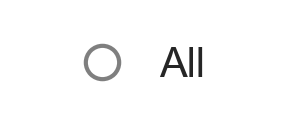

In [265]:
lg_colors=["tab:grey"]
lg_labels=["All"]
lg_number=1

from matplotlib.lines import Line2D
custom_legends =[ Line2D([0],[0],marker='o',markerfacecolor='w',markeredgecolor=lg_colors[i],markersize=8,# markeredgecolor="k",
                        label=lg_labels[i],
                        color="k"
                        ) for i in range(len(lg_labels))]
# plot
plt.figure(figsize=(1,0.25))
plt.legend(handles=custom_legends,loc="center",title="",fontsize=10,
           frameon=False,edgecolor="k", handlelength=0.7
           ,labelspacing=1,handletextpad=1)
plt.gca().set_axis_off()

# WT1 protein/mRNA in TCGA-OV

In [299]:
tcga_wt1_p=pd.read_csv('/Users/tshiro/Desktop/DRY/TCGA_analysis/OV/cBioPortal_2023/ov_tcga/data_protein_quantification.txt'
                     ,sep='\t',index_col=0)
tcga_wt1_p.index=[x.split('|')[0] for x in tcga_wt1_p.index]
tcga_wt1_p=tcga_wt1_p.loc[['WT1'],:].T
tcga_wt1_p.columns=['WT1_p']
tcga_wt1_p=tcga_wt1_p.sort_index()
tcga_wt1_p.index=[x[0:12] for x in tcga_wt1_p.index]
tcga_wt1_p=tcga_wt1_p[~tcga_wt1_p.index.duplicated()]

In [300]:
tcga_wt1_g=pd.read_csv('/Users/tshiro/Desktop/DRY/TCGA_analysis/OV/GDC2023/RNASeq_STAR/TCGA_OV_421_tpm_gs.txt'
                     ,sep='\t',index_col=0)
tcga_wt1_g.index=[x.split('|')[0] for x in tcga_wt1_g.index]
tcga_wt1_g=tcga_wt1_g.loc[['WT1'],:].T
tcga_wt1_g=tcga_wt1_g.drop(['gene_type','simple_ensg']).astype(float)
tcga_wt1_g['WT1_log']=np.log1p( tcga_wt1_g['WT1'] )
tcga_wt1_g=tcga_wt1_g.sort_index()
tcga_wt1_g.index=[x[0:12] for x in tcga_wt1_g.index]
tcga_wt1_g=tcga_wt1_g[~tcga_wt1_g.index.duplicated()]

In [301]:
tcga_wt1_gp=pd.merge(tcga_wt1_g,tcga_wt1_p,left_index=True,right_index=True,how='outer')
tcga_wt1_gp

WT1   WT1_log     WT1_p
TCGA-04-1331   74.7248  4.327106       NaN
TCGA-04-1332   98.6118  4.601281       NaN
TCGA-04-1337   36.7455  3.630866       NaN
TCGA-04-1338   62.1802  4.145991       NaN
TCGA-04-1341   62.1860  4.146083       NaN
...                ...       ...       ...
TCGA-61-2613       NaN       NaN -0.664281
TCGA-OY-A56P   88.3554  4.492622       NaN
TCGA-OY-A56Q  131.4531  4.886229       NaN
TCGA-VG-A8LO   85.7400  4.462915       NaN
TCGA-WR-A838  132.5763  4.894673       NaN

[464 rows x 3 columns]

r = 0.648, p = 1.31e-16


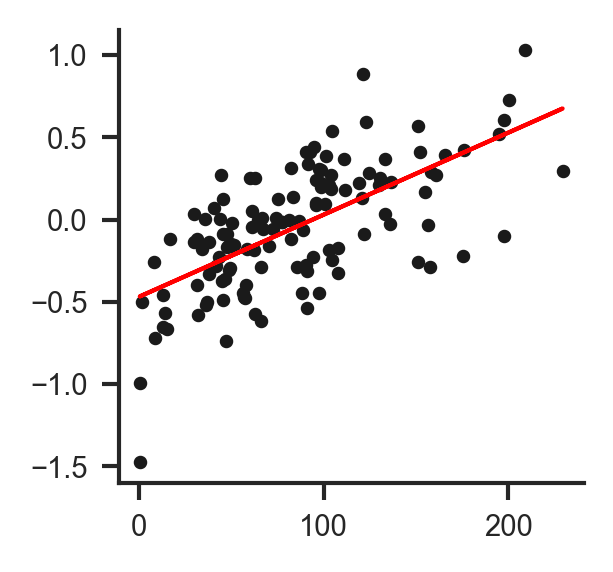

In [302]:
plt_df=tcga_wt1_gp.copy()
#plt_df=plt_df[plt_df[cat]=='']
val1,val2=['WT1','WT1_p']
plt_df=plt_df[[val1,val2]].dropna()
x,y=plt_df[val1],plt_df[val2]

fig=plt.figure(figsize=(2,2))
ax=fig.add_subplot(111)
ax.scatter(x,y,s=5,ec='k',fc="k")
ax.set_xlabel('')
ax.set_ylabel('')
# linear regression, Pearson correlation
lr=stats.linregress(x,y)
a,b,r,p=lr.slope,lr.intercept, lr.rvalue,lr.pvalue
ax.plot(x,a*x+b,lw=1,c='red')
ax.spines['right' ].set_visible(False)
ax.spines['top' ].set_visible(False)

print('r = {:.3f}, p = {:.2e}'.format(r,p))

# From SEER
* Data: SEER Research limited-FIeld Data, 22, Registries, Nov 2022 Sub[2000-2020]
* Selection:Site record ICD-O-3 2023 Revision='Ovary'
* Selection:ICD-O-3 Hist/behav, malignant='8380/3: Endometrioid carcinoma'
* Columns: Year of diagnosis
* Row: Grade Record(thru2017), 
* Row: Grade Pathological(2018+)

In [303]:
df=pd.read_csv('../data/SEER_HGEOC_2000_2017.txt',sep='\t').iloc[1:,:]
df['Count']=[int(x.replace(',','')) for x in df['Count']]
df['Count']=df['Count'].astype(int)
df=df[df['Year of diagnosis']!=0]
df=df[df['Grade Recode (thru 2017)']!=8]
df=df[df['Count']!=0]# drop blank

In [304]:
dict_year_grade={}
for idx in df.index:
    y=df.loc[idx,'Year of diagnosis']
    g=df.loc[idx,'Grade Recode (thru 2017)']
    if y not in dict_year_grade:
        dict_year_grade[y]={}
    dict_year_grade[y][g]=df.loc[idx,'Count']

In [305]:
df1=pd.DataFrame(dict_year_grade).T
df1.columns=['G1','G2','G3','G4']
df1

G1   G2   G3  G4
1   240  361  318  33
2   243  325  343  29
3   215  329  315  36
4   183  312  300  40
5   216  335  295  43
6   221  352  224  31
7   193  303  239  43
8   227  291  237  29
9   228  312  207  29
10  266  256  200  31
11  267  295  175  23
12  239  282  172  24
13  263  278  146  24
14  298  296  155  34
15  261  268  122  19
16  296  258  151  39
17  285  247  128  20
18  326  255  143  31

In [306]:
df=pd.read_csv('../data/SEER_HGEOC_2018_2020.txt',sep='\t')
df['Count']=[int(x.replace(',','')) for x in df['Count']]
df['Count']=df['Count'].astype(int)
df=df[df['Year of diagnosis']!=0]
df=df[df['Grade Pathological (2018+)']!=16]
df=df[df['Count']!=0]# drop blank

In [307]:
dict_year_grade={}
for idx in df.index:
    y=df.loc[idx,'Year of diagnosis']
    g=df.loc[idx,'Grade Pathological (2018+)']
    if y not in dict_year_grade:
        dict_year_grade[y]={}
    dict_year_grade[y][g]=df.loc[idx,'Count']

In [308]:
df2=pd.DataFrame(dict_year_grade).T
df2.columns=['G1','G2','G3','Unknown','Low','High']
df2

G1   G2   G3  Unknown  Low  High
19  296  257  132       83   11    27
20  399  295  114       82    4    14
21  331  261   99       63    3    11

In [309]:
df12=pd.concat([df1,df2]).fillna(0)
df12['G34']=df12['G3']+df12['G4']
df12['G34_ratio']=df12['G34']/np.sum(df12.loc[:,'G1':'G4'],axis=1)*100
df12.index=range(2000,2021)
df12

G1   G2   G3    G4  Unknown   Low  High    G34  G34_ratio
2000  240  361  318  33.0      0.0   0.0   0.0  351.0  36.869748
2001  243  325  343  29.0      0.0   0.0   0.0  372.0  39.574468
2002  215  329  315  36.0      0.0   0.0   0.0  351.0  39.217877
2003  183  312  300  40.0      0.0   0.0   0.0  340.0  40.718563
2004  216  335  295  43.0      0.0   0.0   0.0  338.0  38.020247
2005  221  352  224  31.0      0.0   0.0   0.0  255.0  30.797101
2006  193  303  239  43.0      0.0   0.0   0.0  282.0  36.246787
2007  227  291  237  29.0      0.0   0.0   0.0  266.0  33.928571
2008  228  312  207  29.0      0.0   0.0   0.0  236.0  30.412371
2009  266  256  200  31.0      0.0   0.0   0.0  231.0  30.677291
2010  267  295  175  23.0      0.0   0.0   0.0  198.0  26.052632
2011  239  282  172  24.0      0.0   0.0   0.0  196.0  27.336123
2012  263  278  146  24.0      0.0   0.0   0.0  170.0  23.909986
2013  298  296  155  34.0      0.0   0.0   0.0  189.0  24.137931
2014  261  268  122  19.0      0.0   0.0   0.0  141.0  21.044776
2015  296  258  151  39.0      0.0   0.0   0.0  190.0  25.537634
2016  285  247  128  20.0      0.0   0.0   0.0  148.0  21.764706
2017  326  255  143  31.0      0.0   0.0   0.0  174.0  23.046358
2018  296  257  132   0.0     83.0  11.0  27.0  132.0  19.270073
2019  399  295  114   0.0     82.0   4.0  14.0  114.0  14.108911
2020  331  261   99   0.0     63.0   3.0  11.0   99.0  14.327062

In [311]:
from statsmodels.stats.proportion import proportion_confint
cils,cihs=[],[]
for idx in df12.index:
    nobs=np.sum(df12.loc[idx,'G1':'G4'])
    count=df12.loc[idx,'G34']
    cil,cih=proportion_confint(count,nobs,alpha=0.05)
    cils.append(cil*100)
    cihs.append(cih*100)

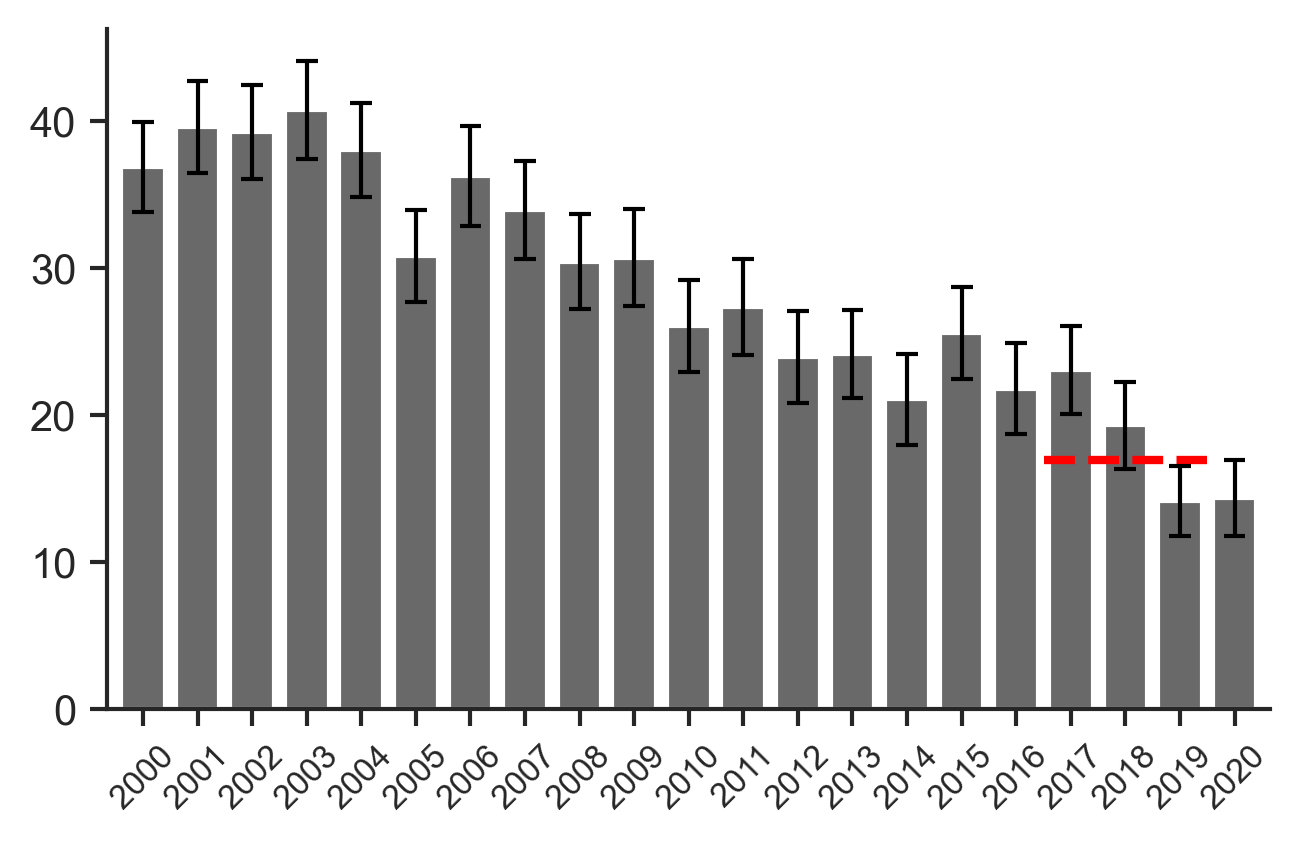

In [312]:
fig=plt.figure(figsize=(5,3))
ax=fig.add_subplot(111)
df12['G34_ratio'].plot.bar(ax=ax,color='dimgrey',width=0.8)
ax.spines['right' ].set_visible(False)
ax.spines['top' ].set_visible(False)
ax.tick_params('x',rotation=45,labelsize=8)
ax.tick_params('y',labelsize=10)

ax.hlines(xmin=16.5,xmax=19.5,y=16.9,lw=2,color='red',ls='dashed')
for i,(cil,cih) in enumerate(zip(cils,cihs)):
    ax.vlines(x=i,ymin=cil,ymax=cih,color='black',lw=1)
    ax.hlines(xmin=i-0.2,xmax=i+0.2,y=cil,color='black',lw=1)
    ax.hlines(xmin=i-0.2,xmax=i+0.2,y=cih,color='black',lw=1)